In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

from scipy.interpolate import interp1d
from scipy.special import spherical_jn

# Definir la función j0
def j0(x):
    return spherical_jn(0, x)

# Función para calcular la 2PCF a partir de P(k)
def calculate_2pcf(k_values, psl_values):
    # Interpolación de P(k)
    psl_interp = interp1d(k_values, psl_values, kind='cubic', fill_value="extrapolate")

    # Límites de k
    kmin_input = k_values[0]
    kmax_input = k_values[-1]

    # Constantes
    pi = np.pi
    pi2 = pi**2
    twopi2 = 2 * pi2

    # Configuración de r
    rmin = 1
    rmax = min(150, 1 / kmin_input)
    nrpoints = 150
    r_values = np.linspace(rmin, rmax, nrpoints)  # Valores de r

    # Configuración de k
    nkpoints = 3000
    kmin = max(0.00001, kmin_input)
    kmax = min(20, kmax_input)
    log_k_values = np.log10(kmin) + np.arange(nkpoints + 1) * (np.log10(kmax) - np.log10(kmin)) / nkpoints
    k_values_interp = 10**log_k_values  # Valores de k en escala logarítmica

    # Función de anti-aliasing
    R0 = 1
    def W(k):
        return np.exp(-(R0 * k)**2 / 2)

    # Cálculo de la correlación ξ(r)
    xi_values = []

    for r in r_values:
        xip = 0
        xiA = kmin**2 * psl_interp(kmin) * j0(kmin * r) * W(kmin)

        for i in range(1, len(k_values_interp)):
            k = k_values_interp[i]
            xiB = k**2 * psl_interp(k) * j0(k * r) * W(k)

            deltak = k_values_interp[i] - k_values_interp[i - 1]
            xip += (xiA + xiB) / 2 * deltak
            xiA = xiB

        xip /= twopi2
        xi_values.append((r, xip))

    # Interpolación de ξ(r)
    r_xi = np.array([x[0] for x in xi_values])
    xi_xi = np.array([x[1] for x in xi_values])
    xi_interp = interp1d(r_xi, xi_xi, kind='cubic', fill_value="extrapolate")

    return r_xi, xi_xi, xi_interp



In [3]:
# ==============================================
# Calcular modelo ΛCDM para comparación (versión mejorada)
# ==============================================
from classy import Class
cosmo_lcdm = Class()
import os
h_lcdm = 0.682
z_pk = 0
k_out = [0.5]  

# Configuración de parámetros ΛCDM
lcdm_params = {
    'output': 'mPk,tCl,pCl,lCl',
    'P_k_max_1/Mpc': 3.0,
    'k_output_values': str(k_out).strip('[]'),

    # Parámetros cosmológicos ΛCDM
    'h': 0.682,
    'Omega_b': 0.0484,
    'Omega_cdm': 0.2537,
    'Omega_Lambda': 0.695,
    #'Omega_fld': 0,
    #'Omega_smg': 0,  # para no activar MG en Hi_CLASS

    'A_s': 2.114e-9,
    'n_s': 0.970,
    'tau_reio': 0.0606,

    'compute damping scale': 'yes',
    'lensing': 'yes'
}

cosmo_lcdm.set(lcdm_params)
cosmo_lcdm.compute()

# Obtener el background para ΛCDM
background_lcdm = cosmo_lcdm.get_background()

# Extraer densidades de energía para ΛCDM
z_lcdm = background_lcdm['z']
a_lcdm = 1 / (1 + z_lcdm)
rho_gamma_lcdm = background_lcdm['(.)rho_g']
rho_nu_lcdm = background_lcdm['(.)rho_ur']
rho_rad_lcdm = rho_gamma_lcdm + rho_nu_lcdm
rho_b_lcdm = background_lcdm['(.)rho_b']
rho_cdm_lcdm = background_lcdm['(.)rho_cdm']
rho_lambda_lcdm = background_lcdm['(.)rho_lambda']
rho_crit_lcdm = background_lcdm['(.)rho_crit']

# Calcular fracciones de densidad
Omega_rad_lcdm = rho_rad_lcdm / rho_crit_lcdm
Omega_b_lcdm = rho_b_lcdm / rho_crit_lcdm
Omega_cdm_lcdm = rho_cdm_lcdm / rho_crit_lcdm
Omega_lambda_lcdm = rho_lambda_lcdm / rho_crit_lcdm

# Obtener espectros angulares del CMB
cls_lcdm = cosmo_lcdm.lensed_cl(2500)
ll_lcdm = cls_lcdm['ell'][2:]
clTT_lcdm = cls_lcdm['tt'][2:]
clEE_lcdm = cls_lcdm['ee'][2:]
clPP_lcdm = cls_lcdm['pp'][2:]

# Calcular P(k) y 2PCF para ΛCDM
k_arr = np.logspace(-4, np.log10(3), 2500)
Pk_lcdm = np.asarray([cosmo_lcdm.pk_lin(k*h_lcdm, z_pk)*h_lcdm**3 for k in k_arr])
r_xi_lcdm, xi_xi_lcdm, xi_interp_lcdm = calculate_2pcf(k_arr, Pk_lcdm)

# Guardar resultados ΛCDM en diccionario completo
lcdm_results = {
    'params': lcdm_params,
    'z': z_lcdm,
    'a': a_lcdm,
    # Densidades de energía
    'rho_gamma': rho_gamma_lcdm,
    'rho_nu': rho_nu_lcdm,
    'rho_rad': rho_rad_lcdm,
    'rho_b': rho_b_lcdm,
    'rho_cdm': rho_cdm_lcdm,
    'rho_lambda': rho_lambda_lcdm,
    'rho_crit': rho_crit_lcdm,
    # Fracciones de densidad
    'Omega_rad': Omega_rad_lcdm,
    'Omega_b': Omega_b_lcdm,
    'Omega_cdm': Omega_cdm_lcdm,
    'Omega_lambda': Omega_lambda_lcdm,
    # Espectros CMB
    'clTT': clTT_lcdm,
    'clEE': clEE_lcdm,
    'clPP': clPP_lcdm,
    'll': ll_lcdm,
    # Espectro de potencia y 2PCF
    'Pk': Pk_lcdm,
    'kk': k_arr,
    'r_xi': r_xi_lcdm,
    'xi_xi': xi_xi_lcdm,
    'xi_interp': xi_interp_lcdm
}
# Crear directorio para resultados si no existe
if not os.path.exists('results'):
    os.makedirs('results')
# Guardar resultados en archivo pickle
with open('results/lcdm_results.pkl', 'wb') as f:
    pickle.dump(lcdm_results, f)

print("Resultados completos de ΛCDM guardados en 'lcdm_results.pkl'")

Resultados completos de ΛCDM guardados en 'lcdm_results.pkl'


In [4]:
5.92*3

17.759999999999998

In [5]:
(1/3)*19.7e-17

6.566666666666667e-17

In [5]:
from classy import Class
#cosmo_lcdm = Class()
import os
h_lcdm = 0.682
z_pk = 0

k_out = [0.5]  


common_settings = {
    'output': 'mPk,tCl,pCl,lCl',
    'P_k_max_1/Mpc': 3.0,
    'k_output_values': str(k_out).strip('[]'),
    'h': 0.691,
    'Omega_fld': 0,
    'Omega_smg': -1,
    'Omega_Lambda': 0.70,
    'omega_b': 0.0226,
    'Omega_cdm': 0,
    'gravity_model': 'quintessence_monomial',
    'x0_schm': 1,
    #'theta_schm':(1/3)*1e-17, 
    'DM_schm': 0.26,
    'h_schm': 2,
    'V0_schm': 4.32,
    'lambda_schm': 1,
    #'sigma8':0.797,
   # Perturbaciones
    'A_s': 2.06e-9,
    'n_s': 0.972,
    'tau_reio': 0.0477,
    'compute damping scale': 'yes',
    'lensing':'yes',
    'output_background_smg': 10,

    #'non linear': 'halofit'
}

# Lista de valores para theta_schm
#x_variable = [(1/3)*17.76e-15, (1/3)*17.76e-16 ,(1/3)*17.76e-17, (1/3)*17.76e-18]
x_variable = [(1/3)*1e-15, (1/3)*1e-17, (1/3)*1e-19]#,(1/3)*1e-18]
#x_variable = [ 2.58e-14,2.58e-15,2.58e-16,2.58e-17,2.58e-18] #for theta
#x_variable = [0.0001, 0.001, 0.01,0.1,1,10,100] #for V_0
#x_variable = [ 0.003, 0.005,0.01,1] #for lambda


# Diccionario para guardar todos los resultados de tu modelo
model_results = {
    'params': x_variable,
    'z': [],
    'a': [],
    'phi': [],
    "phi'": [],
    'cs2': [],
    'X': [],
    # Densidades de energía
    'rho_gamma': [],
    'rho_nu': [],
    'rho_rad': [],
    'rho_b': [],
    'rho_lambda': [],
    'rho_phi': [],
    'p_phi': [],
    'rho_crit': [],
    # Fracciones de densidad
    'Omega_rad': [],
    'Omega_bar': [],
    'Omega_lambda': [],
    'Omega_sch': [],
    # Parámetros de estado
    'w_sch': [],
    'w': [],
    'rho_rel': [],
    'Neff': [],
    'N_phi': [],
    # Perturbaciones
    'Pk': [],
    'r_xi': [],
    'xi_xi': [],
    'kk': np.logspace(-4, np.log10(3), 2500),
    'clTT': [],
    'clEE': [],
    'clPP': [],
    'll': [],
    'xi_interp': []
}
# Background
phi_prime_all = []
phi_all = []
cs2_all = []
z_all = []
a_all = []
X_all = []
Omega_rad_all = []
Omega_bar_all = []
Omega_lambda_all = []
Omega_sch_all = []
w_sch_all = []
w_all = []
rho_rel_all = []
Neff_all = []
N_phi_all = []
N_phi_all2 = []
# Listas para perturbaciones lineales
clTT_all = []
clEE_all = []
clPP_all = []
Pk_all = []
ll_all = []

# Listas para 2PCF
r_xi_all = []
xi_xi_all = []
xi_interp_all = []





# ==============================================
# Ciclo para iterar sobre los diferentes valores de theta_schm
# ==============================================
for x in x_variable:
    common_settings['theta_schm'] = x  # Actualizar el valor de theta_schm
    
    # Crear una nueva instancia de Class y configurar
    cosmo = Class()
    cosmo.set(common_settings)
    cosmo.compute()
    
    # Obtener el background
    background = cosmo.get_background()

    # Extraer las cantidades necesarias del background
    z = background['z']                    # Redshift
    a = 1 / (1 + z)                        # Factor de escala
    rho_gamma = background['(.)rho_g']     # Densidad de energía de fotones
    rho_nu = background['(.)rho_ur']       # Densidad de energía de fotones 
    rad = rho_gamma + rho_nu              # Radiación total (fotones + neutrinos relativistas)
    bar = background['(.)rho_b']           # Densidad de energía bariónica
    lamb = background['(.)rho_lambda']     # Densidad de energía de la constante cosmológica
    rho_crit = background['(.)rho_crit']   # Densidad crítica
    rho_sch = background['(.)rho_smg']     # Densidad de energía del campo escalar (quintessencia)
    p_sch = background['(.)p_smg']         # Presión del campo escalar
    phi = background['phi_smg']
    phi_prime = background["phi'"]
    cs2 = background["c_s^2"]
    X = 0.5*(phi_prime/a)**2

    
    # Calcular las fracciones de densidad
    Omega_rad = rad / rho_crit
    Omega_bar = bar / rho_crit
    Omega_lambda = lamb / rho_crit
    Omega_sch = rho_sch / rho_crit
    Omega_gamma = rho_gamma / rho_crit
    # Calcular el parámetro de ecuación de estado w_sch
    w_sch = (p_sch - lamb) / (rho_sch + lamb)
    w = p_sch/rho_sch
    # Densidad relativista total
    rho_rel = rad + 3 * p_sch
    
    Neff = ((rho_rel-rho_gamma)/(rho_gamma))*(8/7)*(11/4)**(4/3)
    #N_phi = 3*(8/7)*(11/4)**(4/3)*( (1.23014e+10*2.7e-19**4)/(rho_gamma*a**4))
    x_N = 3*x
    N_phi2 = (6/7)*(11/4)**(4/3)*((Omega_sch)/Omega_gamma)*x_N**(1/3)
    N_phi = (8/7)*(11/4)**(4/3)*(3*p_sch/rho_gamma)
    # Guardar los resultados en las listas correspondientes
    z_all.append(z)
    a_all.append(a)
    phi_all.append(phi)
    cs2_all.append(cs2)
    phi_prime_all.append(phi_prime)
    X_all.append(X)
    Omega_rad_all.append(Omega_rad)
    Omega_bar_all.append(Omega_bar)
    Omega_lambda_all.append(Omega_lambda)
    Omega_sch_all.append(Omega_sch)
    w_sch_all.append(w_sch)
    w_all.append(w)
    rho_rel_all.append(rho_rel)
    Neff_all.append(Neff)
    N_phi_all.append(N_phi)
    N_phi_all2.append(N_phi2)
    
    # Ahora obtener los espectros angulares C_l
    cls = cosmo.lensed_cl(2500)  # Espectros angulares lensed hasta l=2500
    ll = cls['ell'][2:]  # Valores de l
    clTT = cls['tt'][2:]  # C_l^TT
    clEE = cls['ee'][2:]  # C_l^EE
    clPP = cls['pp'][2:]  # C_l^PP
    
    # Guardar C_l en las listas correspondientes
    clTT_all.append(clTT)
    clEE_all.append(clEE)
    clPP_all.append(clPP)
    ll_all.append(ll)

    # Obtener el espectro de potencia P(k)
    kk = np.logspace(-4, np.log10(3), 2500)  # Valores de k en h/Mpc
    Pk = []  # Inicializar lista para P(k)

    h = cosmo.h()  # Obtener h (para conversión de k)
    for k in kk:
        Pk.append(cosmo.pk(k * h, 0.) * h ** 3)  # P(k) en (Mpc/h)^3

    # Guardar los resultados de P(k)
    Pk_all.append(Pk)
    
    # Calcular la 2PCF para este modelo
    r_xi, xi_xi, xi_interp = calculate_2pcf(kk, Pk)
    r_xi_all.append(r_xi)
    xi_xi_all.append(xi_xi)
    xi_interp_all.append(xi_interp)
    
    model_results['z'].append(z)
    model_results['a'].append(a)
    model_results['phi'].append(phi)
    model_results["phi'"].append(phi_prime)
    model_results['cs2'].append(cs2)
    model_results['X'].append(X)
    # Densidades de energía
    model_results['rho_gamma'].append(rho_gamma)
    model_results['rho_nu'].append(rho_nu)
    model_results['rho_rad'].append(rad)
    model_results['rho_b'].append(bar)
    model_results['rho_lambda'].append(lamb)
    model_results['rho_phi'].append(rho_sch)
    model_results['p_phi'].append(p_sch)
    model_results['rho_crit'].append(rho_crit)
     # Abundancias
    model_results['Omega_rad'].append(Omega_rad)
    model_results['Omega_bar'].append(Omega_bar)
    model_results['Omega_lambda'].append(Omega_lambda)
    model_results['Omega_sch'].append(Omega_sch)
    # Parámetros de estado
    model_results['w_sch'].append(w_sch)
    model_results['w'].append(w)
    model_results['rho_rel'].append(rho_rel)
    model_results['Neff'].append(Neff)
    model_results['N_phi'].append(N_phi)
     # Perturbaciones
    model_results['Pk'].append(Pk)
    model_results['r_xi'].append(r_xi)
    model_results['xi_xi'].append(xi_xi)
    model_results['xi_interp'].append(xi_interp)
    model_results['clTT'].append(clTT)
    model_results['clEE'].append(clEE)
    model_results['clPP'].append(clPP)
    model_results['ll'].append(ll)
    
    # Limpiar la memoria de CLASS al final de cada ciclo
    cosmo.struct_cleanup()





# Guardar resultados de tu modelo
with open('results/exponential_results_theta.pkl', 'wb') as f:
    pickle.dump(model_results, f)



print("Resultados guardados exitosamente en:")
print("- results/model_results.pkl")


aquí voy y todo bien 2
aquí voy y todo bien 2
aquí voy y todo bien 2.02167
aquí voy y todo bien 2.11016
aquí voy y todo bien 2.06591
aquí voy y todo bien 2.08008
aquí voy y todo bien 2.073
aquí voy y todo bien 2.08008
aquí voy y todo bien 2
aquí voy y todo bien 2
aquí voy y todo bien 2.02167
aquí voy y todo bien 2.11016
aquí voy y todo bien 2.06591
aquí voy y todo bien 2.08008
aquí voy y todo bien 2.073
aquí voy y todo bien 2.08008
aquí voy y todo bien 2
aquí voy y todo bien 2
aquí voy y todo bien 2.02167
aquí voy y todo bien 2.11016
aquí voy y todo bien 2.06591
aquí voy y todo bien 2.08008
aquí voy y todo bien 2.073
aquí voy y todo bien 2.08008


Resultados guardados exitosamente en:
- results/model_results.pkl


/tmp/ipykernel_6462/1862050226.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(z,N_phi_all2[i][-1]*z/z,"--",label=r"$N _{\phi2}=$"+str(round(N_phi_all[i][0],2)))


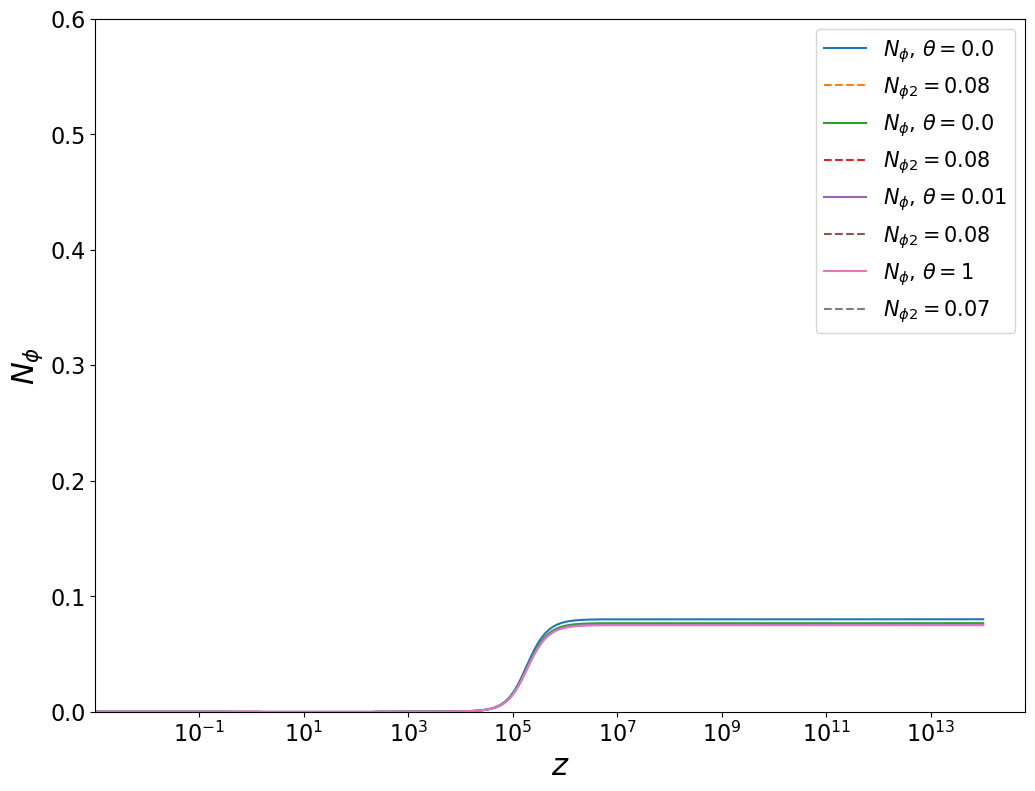

In [7]:
plt.figure(figsize=(12, 9))

plt.xscale("log")


#plt.plot(a,Neff13, color="red",label="Neff")
for i in range(len(Neff_all)):
#plt.plot(a,w_sch0,"--", color="purple",label="$\omega _{\phi}$")
    #plt.plot(z,Neff_all[i],"-",label=r"$N _{eff}$, $\theta = $"+str(x_variable[i]))
    plt.plot(z,N_phi_all[i],"-",label=r"$N _{\phi}$, $\theta = $"+str(np.round(x_variable[i],2)))
    plt.plot(z,N_phi_all2[i][-1]*z/z,"--",label=r"$N _{\phi2}=$"+str(round(N_phi_all[i][0],2)))
    
    
#plt.plot(a0,Neff0, color="red",label="Neff $\\theta=8.1 \\times 10^{-20}$")
#plt.plot(a,Neff15, color="green",label="Neff $\\theta=8.1 \\times 10^{-15}$")
#plt.plot(a,Neff17, color="purple",label="Neff $\\theta=8.1 \\times 10^{-17}$")
#plt.plot(a,Neff19, color="blue",label="Neff $\\theta=8.1 \\times 10^{-19}$")
#plt.axvline(x=10**9, ymin=0, ymax=3.8,color="purple", label="Nucleosíntesis", linestyle = '--', alpha=0.4)
#plt.axvline(x=1100, ymin=0, ymax=3.8, color='red',label="Recombinación", linestyle = '--', alpha=0.4)
#plt.axhline(3.33, color='black',label="$N_{eff}$=3.15", linestyle = '--', alpha=0.6)

plt.ylim(0,0.6)
#plt.plot(a,Neff, color="blue",label="Neff")
plt.tick_params(axis='both', which='major', labelsize=16)

#plt.title('Espectro de potencias', fontsize=20)
plt.xlabel('$z$',fontsize=22)
plt.ylabel('$N_{\phi}$',fontsize=22)
plt.legend(fontsize=15)

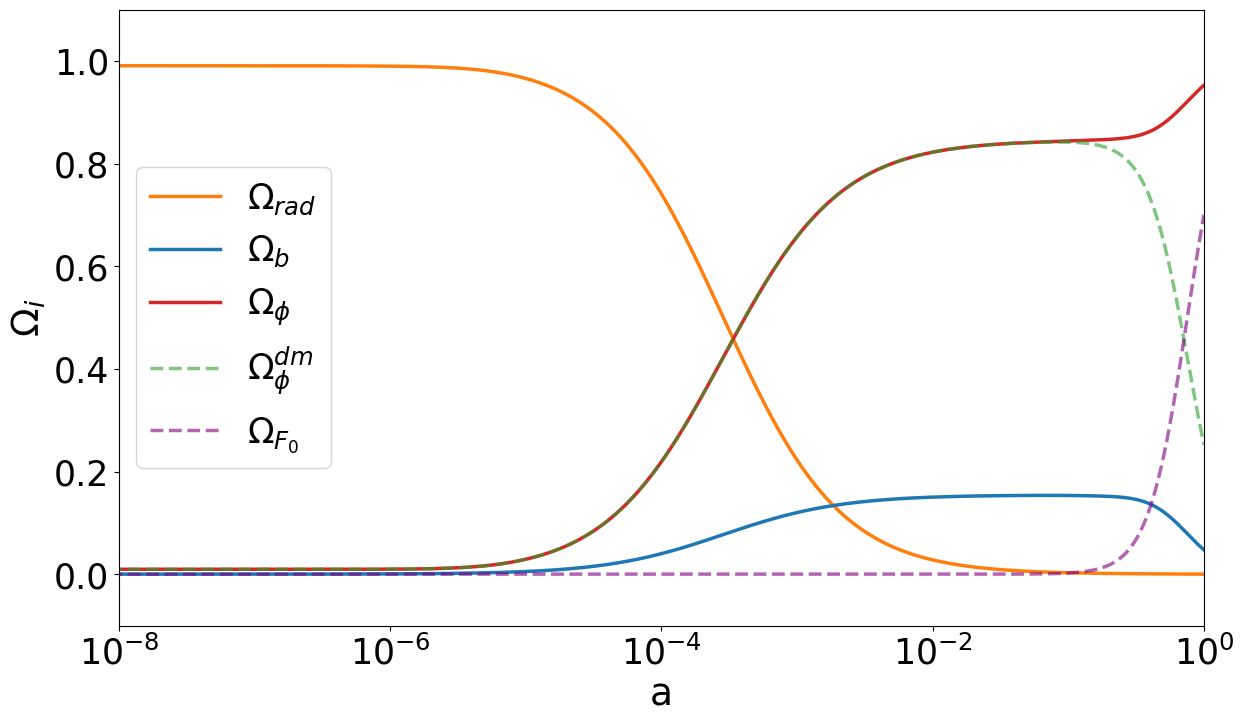

In [4]:
param_index=0
plt.figure(figsize=(14, 8))
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('a', fontsize=27)
plt.ylabel('$\Omega _i$', fontsize=27)
    
    # Obtener datos para el parámetro seleccionado
a = model_results['a'][param_index]
x_val = model_results['params'][param_index]
    
    # Graficar cada componente
plt.plot(a, model_results['Omega_rad'][param_index], label='$\Omega_{rad}$', linewidth=2.5, color='#FF7F0E')  # Naranja
plt.plot(a, model_results['Omega_bar'][param_index], label='$\Omega_{b}$', linewidth=2.5, color='#1F77B4')   # Azul
plt.plot(a, model_results['Omega_sch'][param_index]+model_results['Omega_lambda'][param_index], label='$\Omega_{\phi}$', linewidth=2.5, color='#D62728')  # Verde
plt.plot(a, model_results['Omega_sch'][param_index], label='$\Omega_{\phi}^{dm}$', linewidth=2.5, color='#2CA02C', linestyle = '--', alpha = 0.6)  # Verde
plt.plot(a, model_results['Omega_lambda'][param_index], label='$\Omega_{F_0}$', linewidth=2.5, color='purple', linestyle = '--', alpha = 0.6)  # Rojo
    
    
    # Líneas de referencia cosmológicas
    #plt.axvline(x=1/1100, color='gray', linestyle='--', alpha=0.7, label='Recombination')
    #plt.axvline(x=1/10**9, color='gray', linestyle=':', alpha=0.7, label='Nucleosynthesis')
    
    # Ajustar límites del eje y
plt.ylim(-0.1, 1.1)
plt.xlim(1e-8,1)
    # Leyenda y título
plt.legend(fontsize=25)#

/home/eladio/anaconda3/envs/class/lib/python3.10/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


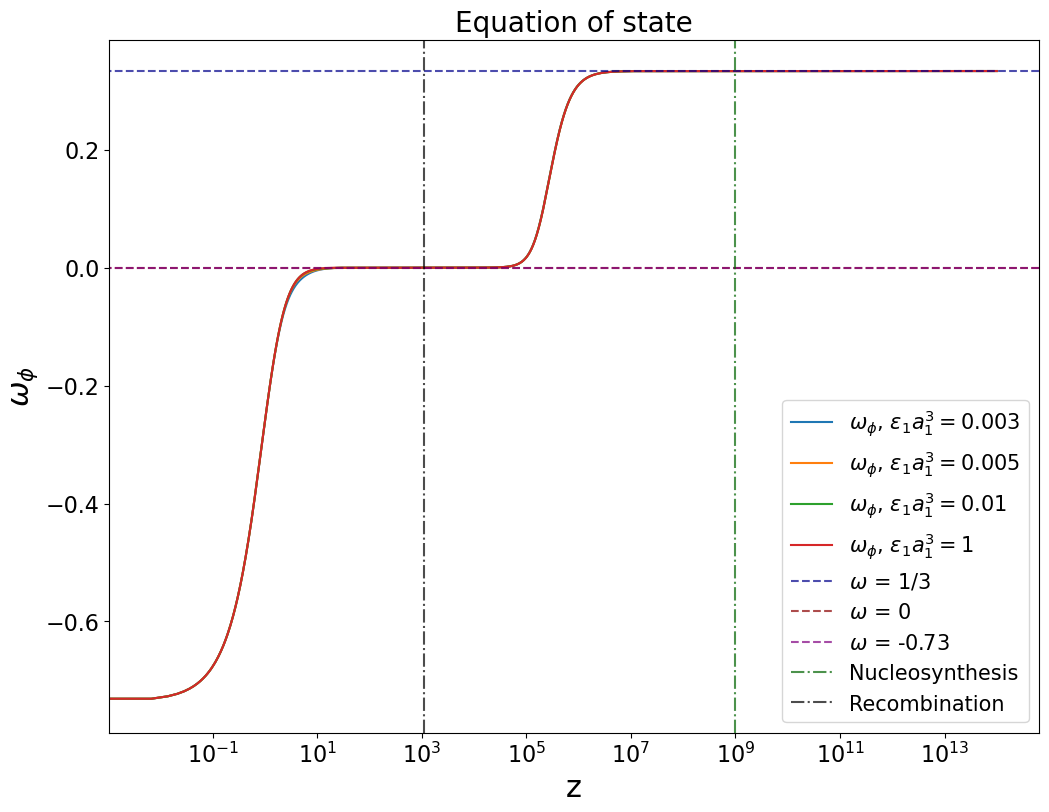

In [5]:
#plt.yscale("log")
plt.figure(figsize=(12, 9))
#plt.xlim(1e-10,1)

plt.xscale("log")
for i in range(len(Omega_rad_all)):
#plt.plot(a,w_sch0,"--", color="purple",label="$\omega _{\phi}$")
    plt.plot(z_all[i],w_sch_all[i],"-",label=r"$\omega _{\phi}$, $\epsilon_1 a_1^3 = $"+str(x_variable[i]))
    #plt.plot(z,w_sch_all[i],"-.",label="$\omega _\phi$")
    


#plt.plot(a,1/3, color="red",label="$\omega _{sch}$")
plt.axhline(1/3,xmin=z_all[0][0], xmax=z_all[0][-1], linestyle='--', alpha=0.7, color='darkblue',label=r'$\omega$ = 1/3')
plt.axhline(0, xmin=z_all[0][0], xmax=z_all[0][-1], linestyle='--', alpha=0.7, color='darkred',label=r'$\omega$ = 0')
plt.axhline(w_all[0][-1],xmin=z_all[0][0], xmax=z_all[0][-1], linestyle='--', alpha=0.7, color='purple', label=r'$\omega$ = {:.1f}3'.format(w_sch_all[0][-1]))
plt.axvline(x=10**9, ymin=0, ymax=3.8,color="darkgreen", label="Nucleosynthesis", linestyle = '-.', alpha=0.7)
plt.axvline(x=1100, ymin=0, ymax=3.8, color='black',label="Recombination", linestyle = '-.', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('Equation of state', fontsize=20)
plt.xlabel('z',fontsize=22)
plt.ylabel('$\omega _{\phi}$',fontsize=22)
plt.legend(fontsize=15)

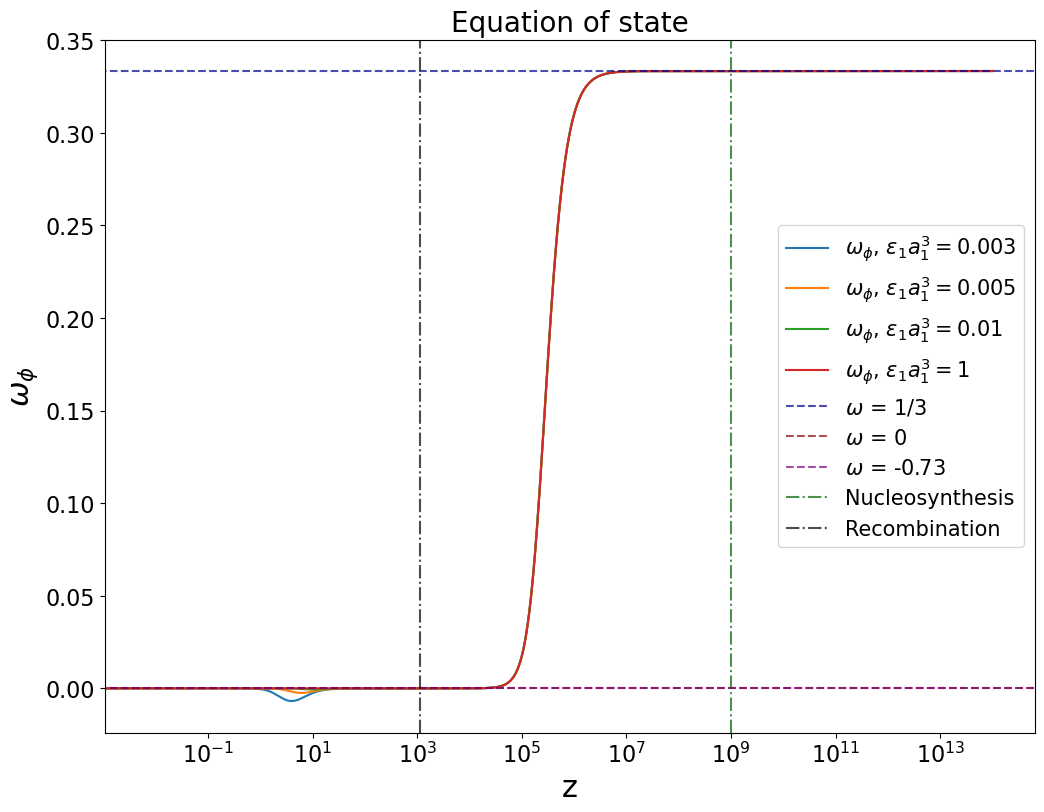

In [6]:
#plt.yscale("log")
plt.figure(figsize=(12, 9))
#plt.xlim(1e-10,1)

plt.xscale("log")
for i in range(len(Omega_rad_all)):
#plt.plot(a,w_sch0,"--", color="purple",label="$\omega _{\phi}$")
    plt.plot(z_all[i],w_all[i],"-",label=r"$\omega _{\phi}$, $\epsilon_1 a_1^3 = $"+str(x_variable[i]))
    #plt.plot(z,w_sch_all[i],"-.",label="$\omega _\phi$")
    


#plt.plot(a,1/3, color="red",label="$\omega _{sch}$")
plt.axhline(1/3,xmin=z_all[0][0], xmax=z_all[0][-1], linestyle='--', alpha=0.7, color='darkblue',label=r'$\omega$ = 1/3')
plt.axhline(0, xmin=z_all[0][0], xmax=z_all[0][-1], linestyle='--', alpha=0.7, color='darkred',label=r'$\omega$ = 0')
plt.axhline(w_all[0][-1],xmin=z_all[0][0], xmax=z_all[0][-1], linestyle='--', alpha=0.7, color='purple', label=r'$\omega$ = {:.1f}3'.format(w_sch_all[0][-1]))
plt.axvline(x=10**9, ymin=0, ymax=3.8,color="darkgreen", label="Nucleosynthesis", linestyle = '-.', alpha=0.7)
plt.axvline(x=1100, ymin=0, ymax=3.8, color='black',label="Recombination", linestyle = '-.', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('Equation of state', fontsize=20)
plt.xlabel('z',fontsize=22)
plt.ylabel('$\omega _{\phi}$',fontsize=22)
plt.legend(fontsize=15)

In [7]:
w_sch_all[0][-1]

-0.7348457260274447

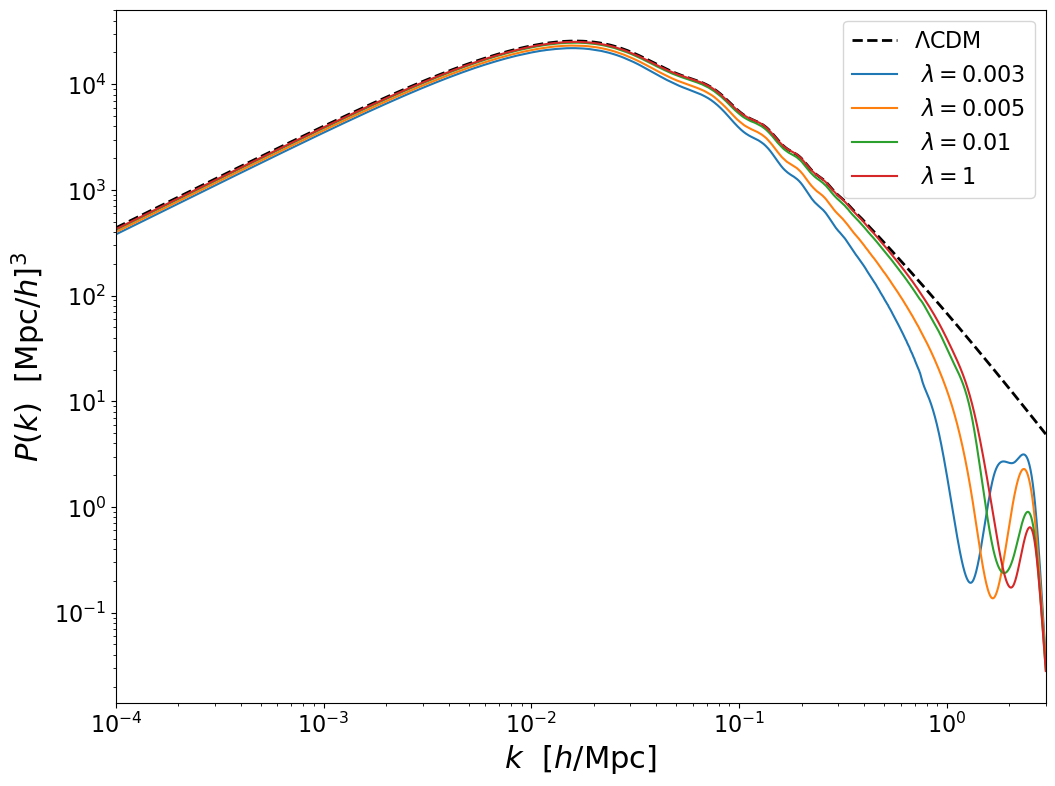

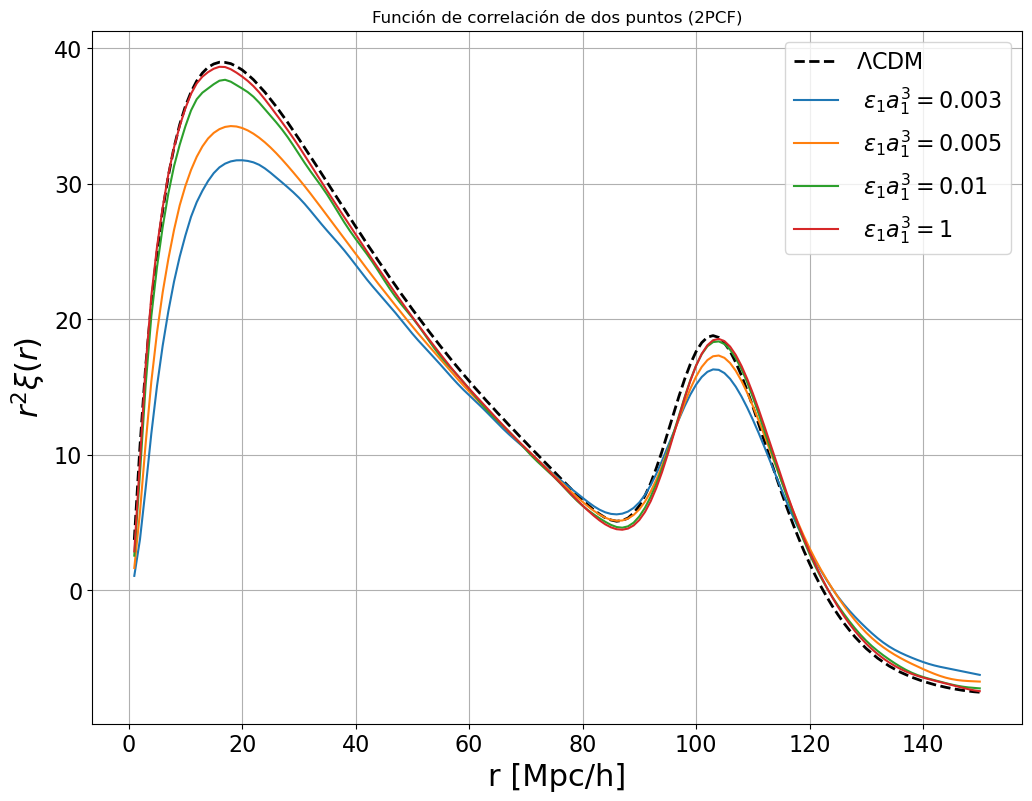

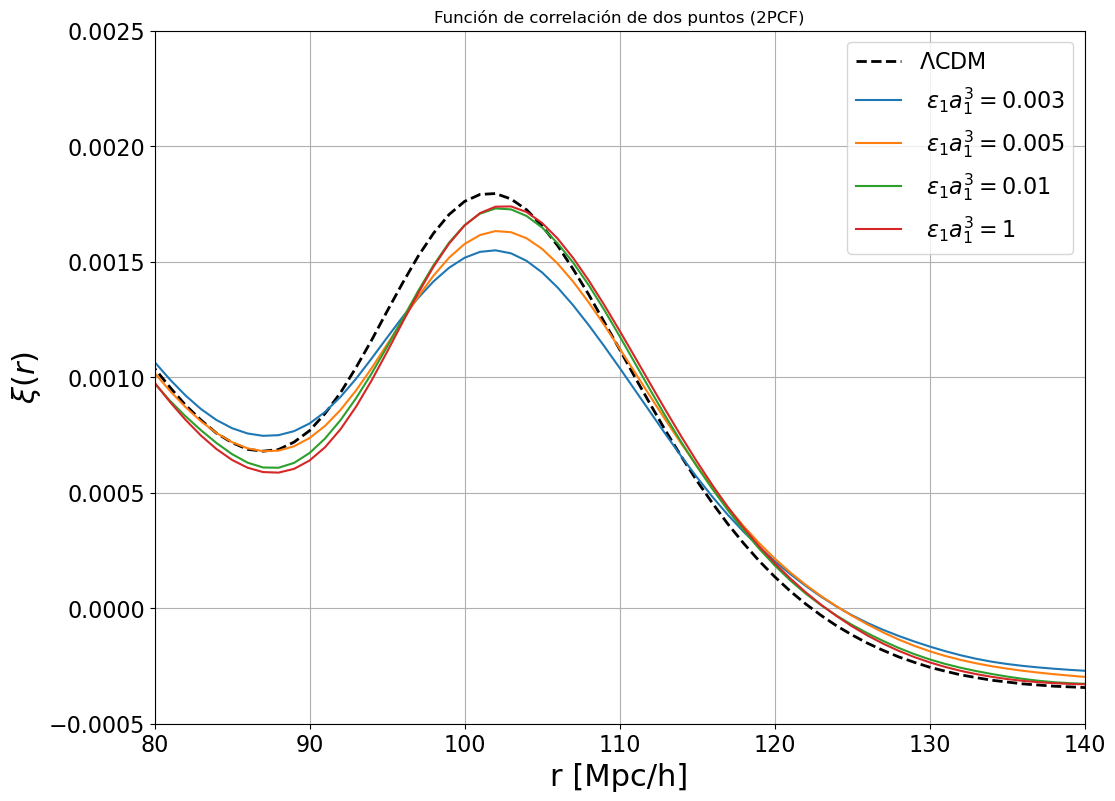

In [8]:
# ==============================================
# Graficar P(k) con comparación ΛCDM
# ==============================================
plt.figure(figsize=(12, 9))
plt.xscale('log')
plt.yscale('log')
plt.xlim(kk[0], kk[-1])
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$',fontsize=22)
plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$',fontsize=22)

# Graficar ΛCDM primero (para que quede detrás)
plt.plot(k_arr, Pk_lcdm, color='black', linestyle='--', linewidth=2, label=r'$\Lambda$CDM')

# Graficar modelos quintessencia
for i in range(len(Pk_all)):
    plt.plot(kk, Pk_all[i], label=" $\lambda = $"+str(x_variable[i]))
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=16)
#plt.grid(True, which="both", ls="--", alpha=0.3)
plt.show()


# ==============================================
# Graficar las funciones de correlación 2PCF (r²ξ(r))
# ==============================================
plt.figure(figsize=(12, 9))

# Graficar ΛCDM primero
plt.plot(r_xi_lcdm, r_xi_lcdm**2 * xi_xi_lcdm, 
         color='black', linestyle='--', linewidth=2, label=r'$\Lambda$CDM')

# Graficar modelos quintessencia
for i in range(len(r_xi_all)):
    plt.plot(r_xi_all[i], r_xi_all[i]**2 * xi_xi_all[i], 
             label=f" $\epsilon_1 a_1^3 = ${x_variable[i]}")
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel("r [Mpc/h]",fontsize=22)
plt.ylabel(r"$r^2 \xi(r)$",fontsize=22)
plt.title("Función de correlación de dos puntos (2PCF)")


plt.legend(fontsize=16)
plt.grid(True)
plt.show()

# ==============================================
# Graficar ξ(r) directamente
# ==============================================
plt.figure(figsize=(12, 9))

# Graficar ΛCDM primero
plt.plot(r_xi_lcdm, xi_xi_lcdm, 
         color='black', linestyle='--', linewidth=2, label=r'$\Lambda$CDM')

# Graficar modelos quintessencia
for i in range(len(r_xi_all)):
    plt.plot(r_xi_all[i], xi_xi_all[i], 
             label=f" $\epsilon_1 a_1^3 = ${x_variable[i]}")
plt.xlim(80,140)
plt.ylim(-5e-4,25e-4)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.xlabel("r [Mpc/h]",fontsize=22)
plt.ylabel(r"$\xi(r)$",fontsize=22)
plt.title("Función de correlación de dos puntos (2PCF)")
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

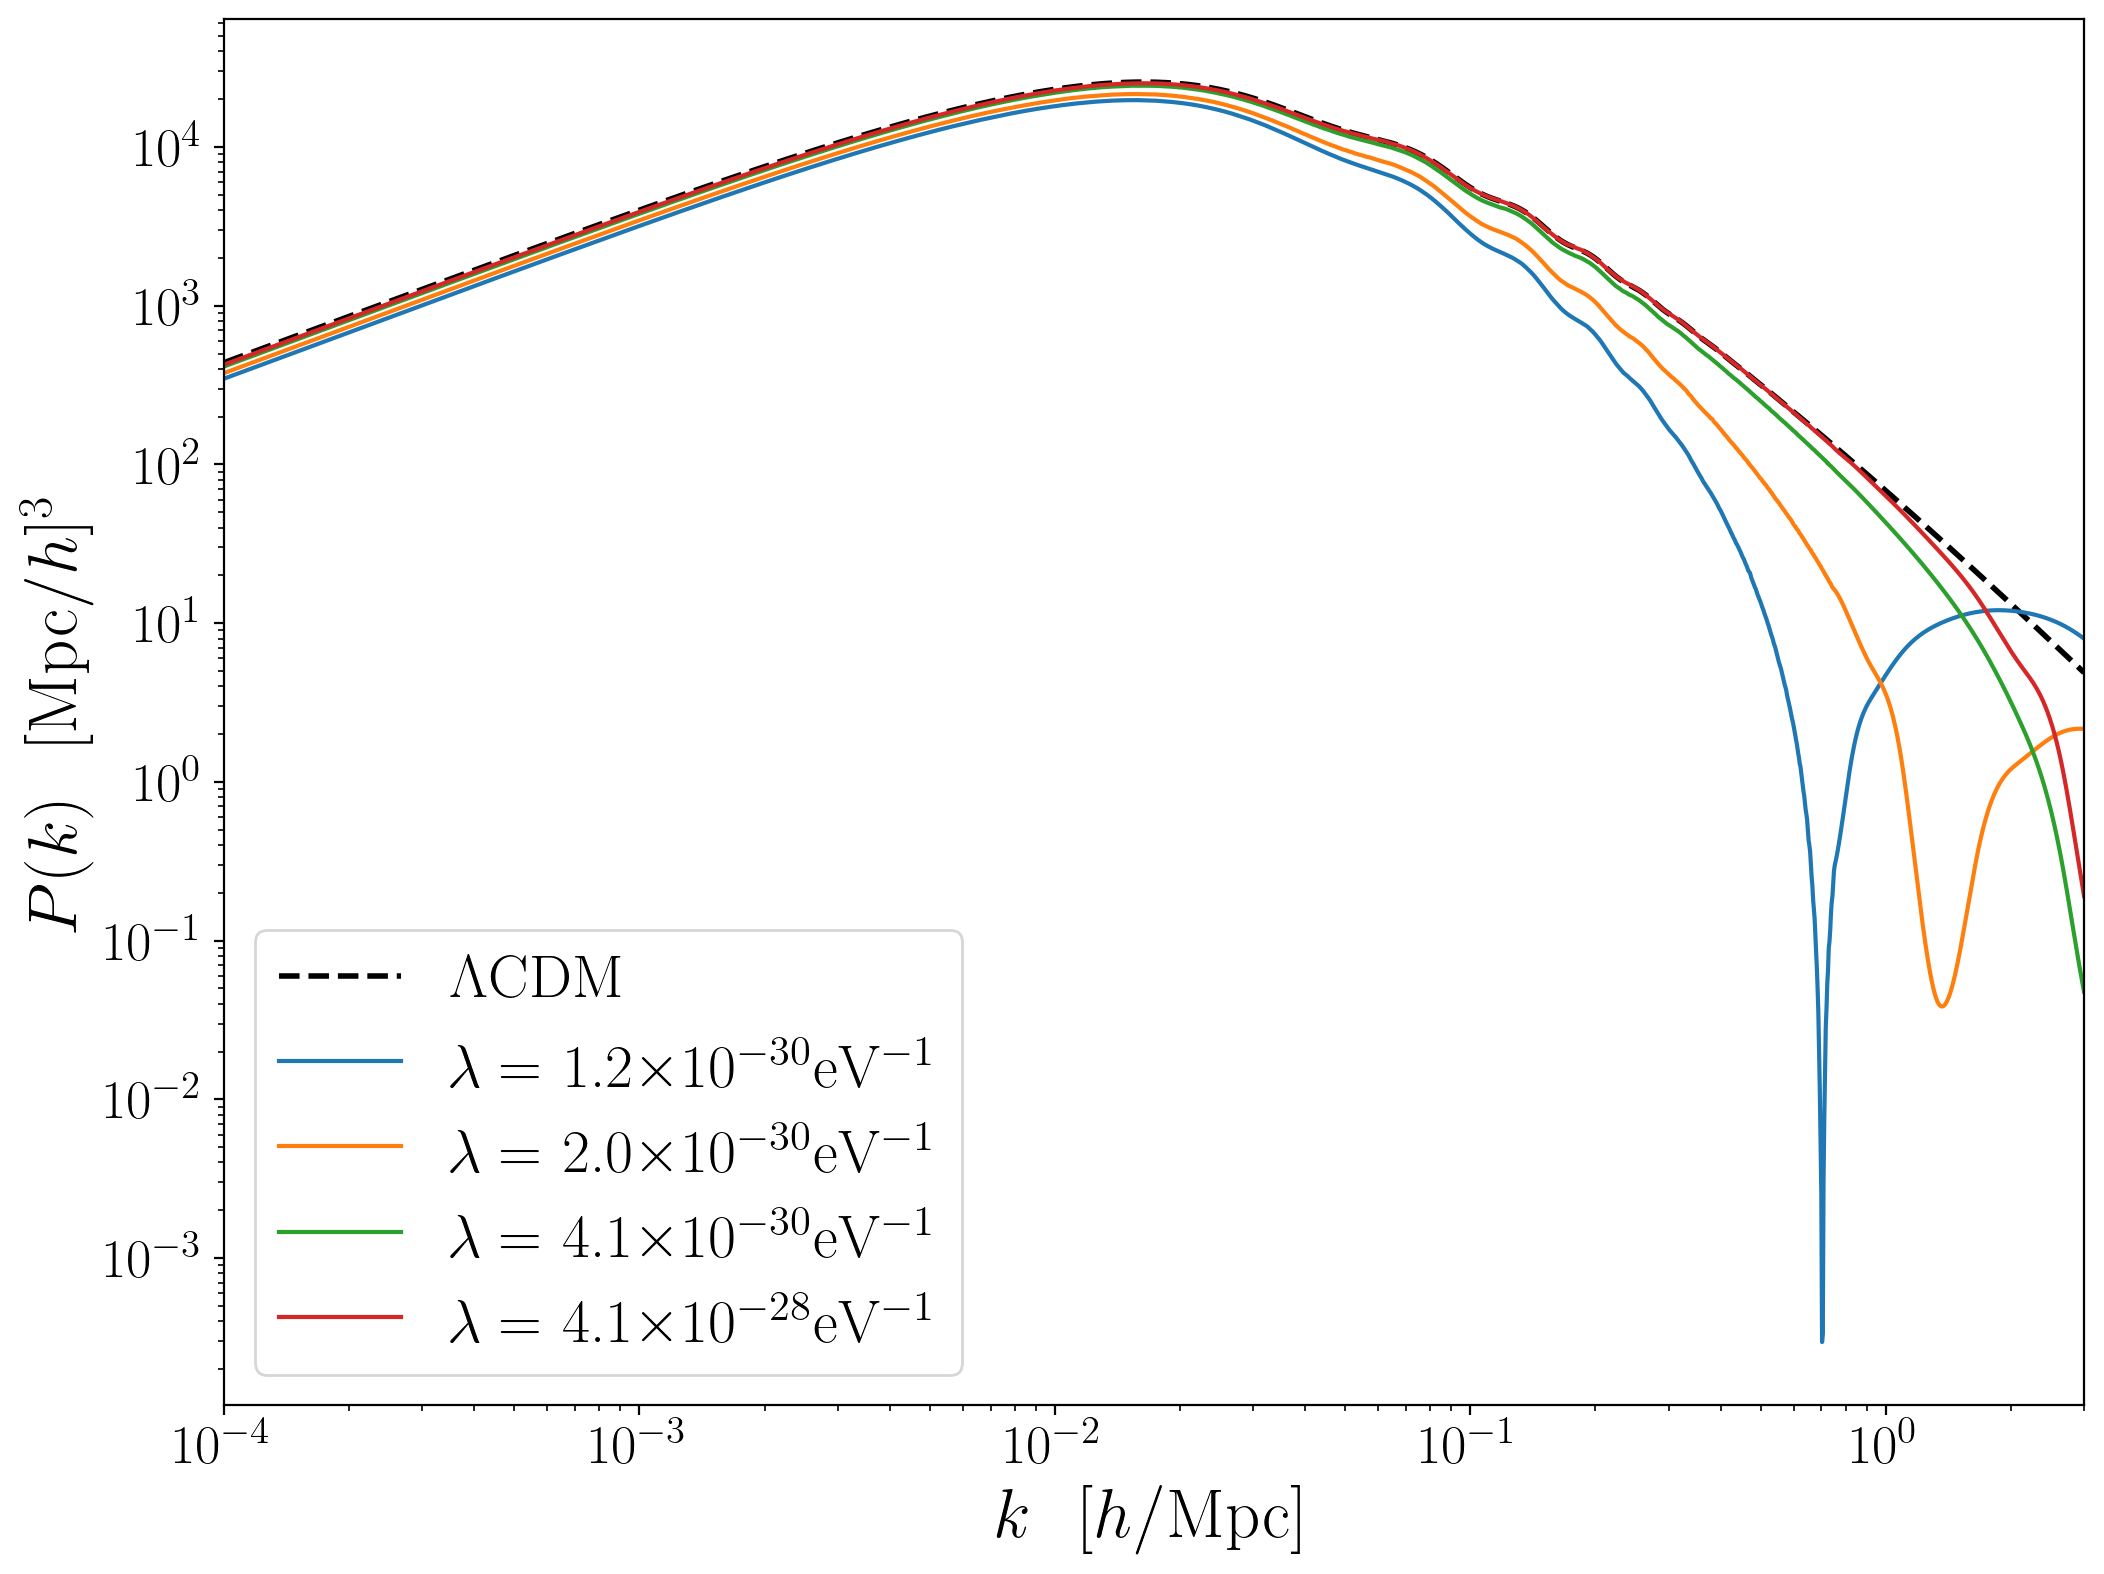

In [10]:
plt.rc('text', usetex=True)  # Activa el uso de LaTeX
plt.rc('font', family='serif')  # Usa una fuente tipo serif (como Computer Modern)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
label_list = [r"1.2$\times 10^{-30}$eV$^{-1}$",r"2.0$\times 10^{-30}$eV$^{-1}$",r"4.1$\times 10^{-30}$eV$^{-1}$", r"4.1$\times 10^{-28}$eV$^{-1}$"]
plt.figure(figsize=(12, 9))
plt.xscale('log')
plt.yscale('log')
plt.xlim(kk[0], kk[-1])
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$',fontsize=25)
plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$',fontsize=25)
# Graficar ΛCDM primero (para que quede detrás)
plt.plot(k_arr, Pk_lcdm, color='black', linestyle='--', linewidth=2, label=r'$\Lambda$CDM')

# Graficar modelos quintessencia
for i in range(len(Pk_all)):
    plt.plot(kk, Pk_all[i], label=" $\lambda = \, \, $"+str(label_list[i]))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=22)
#plt.grid(True, which="both", ls="--", alpha=0.3)
plt.savefig('matter_spectrum_exponential_lambda.pdf',dpi=300)
plt.show()



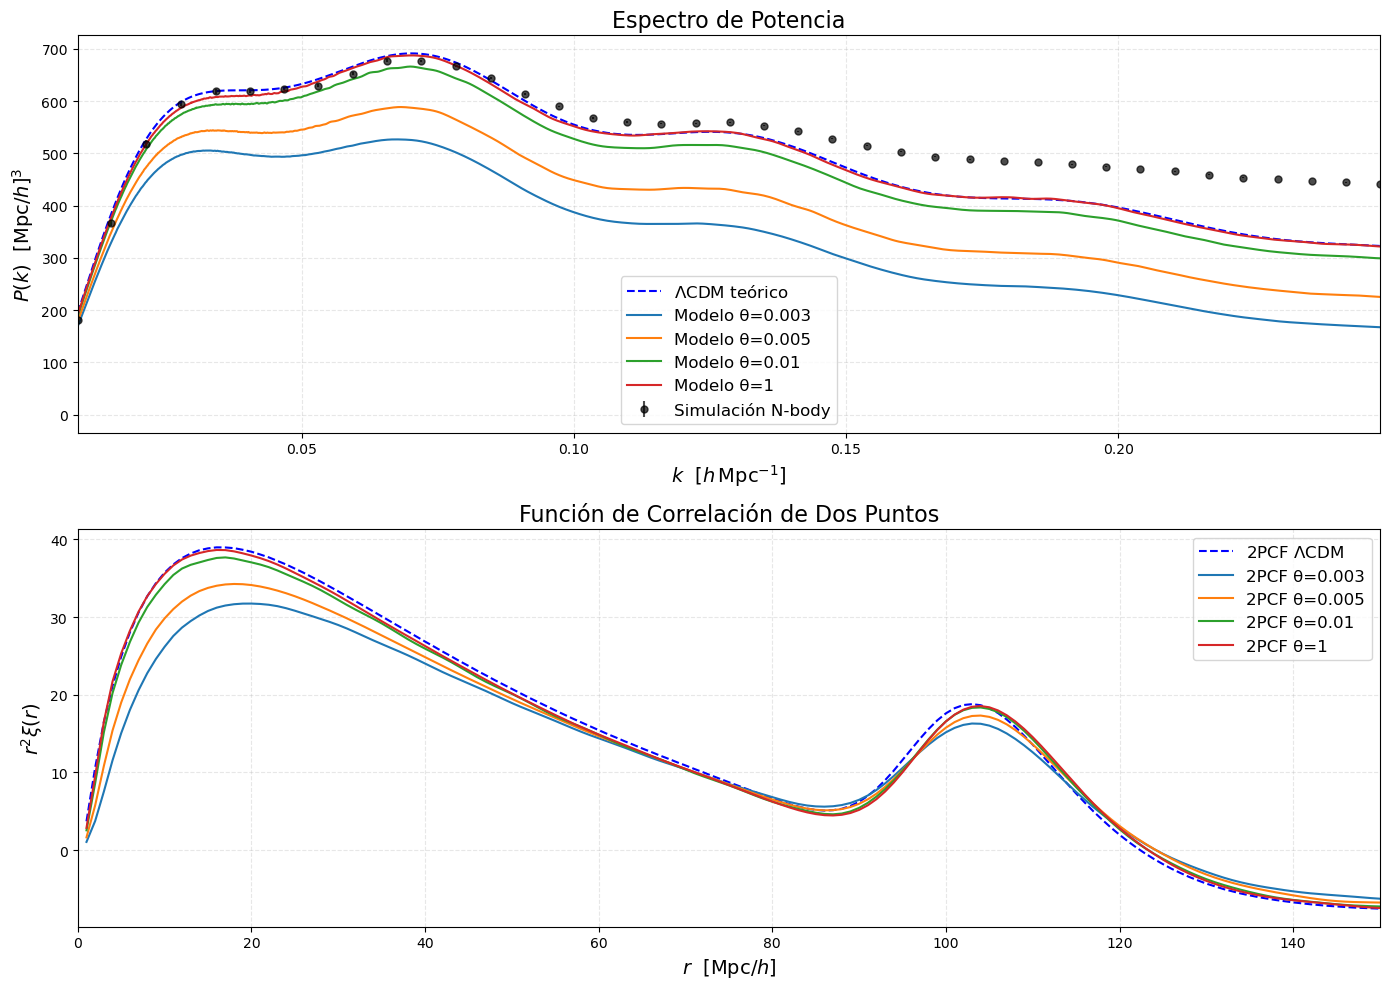

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy.interpolate import interp1d
from scipy.special import spherical_jn

# Datos de la simulación N-body
k_sim = np.array([0.00889964, 0.01507912, 0.0214479 , 0.02783661, 0.034351  ,
       0.04047887, 0.04676717, 0.05308225, 0.05945362, 0.06576225,
       0.07196633, 0.07827861, 0.08470399, 0.09096855, 0.0972079 ,
       0.1034763 , 0.10975764, 0.11605431, 0.12236697, 0.12868173,
       0.13495008, 0.14119496, 0.14751336, 0.15378651, 0.16006575,
       0.16639912, 0.17271956, 0.17897652, 0.18523537, 0.19148068,
       0.19778899, 0.20409377, 0.21039393, 0.21669097, 0.22297003,
       0.229262  , 0.23551415, 0.24179106, 0.24808565])
pk_sim_mean = np.array([20390.97384894, 24358.19992737, 24191.51569841, 21384.76950985,
      18024.71646773, 15307.20918092, 13336.89810885, 11858.70695086,
      10968.70253472, 10297.97911181,  9411.50055037,  8524.67530035,
       7602.68847137,  6751.28460248,  6067.16378742,  5490.03193675,
       5104.09503373,  4801.05979698,  4555.13469326,  4350.20232886,
       4096.59634401,  3838.24273863,  3581.61981222,  3348.446803  ,
       3144.91339009,  2968.04681755,  2830.43876657,  2713.55137222,
       2608.7608902 ,  2501.28331732,  2398.55804517,  2303.54857602,
       2214.48933648,  2119.75892283,  2034.21671299,  1966.74088607,
       1898.42995957,  1838.18481033,  1780.53240415])
pk_sim_err = np.array([566.12135069, 464.61953746, 295.55933493, 171.18271405,
      133.7773395 , 100.44473355,  69.1264847 ,  56.2722429 ,
       46.19382183,  39.32672044,  30.14508345,  28.50211645,
       22.48792954,  17.24657931,  16.87754306,  14.14144177,
       11.45758907,  10.91381189,  10.57199026,   8.97353884,
        7.01290078,   7.10190066,   6.13893694,   4.99286619,
        4.92570598,   4.83915481,   4.64839833,   4.05601564,
        3.35119203,   3.19039159,   3.52113414,   2.87087841,
        3.01662257,   2.50393343,   2.8802467 ,   2.28230952,
        2.33612513,   2.28502048,   2.13909821])

# Definir la función j0
def j0(x):
    return spherical_jn(0, x)

# Función mejorada para calcular la 2PCF a partir de P(k)
#def calculate_2pcf(k_values, psl_values, extend_k_range=True):
    # Interpolación de P(k) con extrapolación suave
#    log_k = np.log10(k_values)
#    log_pk = np.log10(psl_values)
#    log_interp = interp1d(log_k, log_pk, kind='cubic', 
#                         fill_value='extrapolate', bounds_error=False)
#    psl_interp = lambda k: 10**log_interp(np.log10(k))

    # Límites de k
#    kmin_input = k_values[0]
#    kmax_input = k_values[-1]

    # Constantes
#    pi = np.pi
#    twopi2 = 2 * pi**2

    # Configuración de r
#    rmin = 1
#    rmax = min(200, 1/kmin_input)  # Aumentamos el rango máximo
#    nrpoints = 300
#    r_values = np.linspace(rmin, rmax, nrpoints)

    # Configuración de k - ampliamos el rango para mejor integración
#    nkpoints = 5000
#    if extend_k_range:
#        kmin = max(1e-6, kmin_input/10)  # Extendemos hacia bajos k
#        kmax = min(100, kmax_input*10)   # Extendemos hacia altos k
#    else:
#        kmin = kmin_input
#        kmax = kmax_input
        
#    log_k_values = np.linspace(np.log10(kmin), np.log10(kmax), nkpoints)
#    k_values_interp = 10**log_k_values

    # Función de anti-aliasing mejorada
#    R0 = 1.5  # Suavizado ligeramente mayor
#    def W(k):
#        return np.exp(-(R0 * k)**2 / 2)

    # Cálculo de la correlación ξ(r) con integración más precisa
#    xi_values = []
#    for r in r_values:
#        integrand = k_values_interp**2 * psl_interp(k_values_interp) * j0(k_values_interp * r) * W(k_values_interp)
#        xip = np.trapz(integrand, k_values_interp) / twopi2
#        xi_values.append((r, xip))

    # Interpolación de ξ(r)
#    r_xi = np.array([x[0] for x in xi_values])
#    xi_xi = np.array([x[1] for x in xi_values])
#    xi_interp = interp1d(r_xi, xi_xi, kind='cubic', fill_value="extrapolate")

#    return r_xi, xi_xi, xi_interp

# =================================================================
# Calcular 2PCF para la simulación N-body
# =================================================================
#r_xi_sim, xi_xi_sim, xi_interp_sim = calculate_2pcf(k_sim, pk_sim_mean)

# =================================================================
# Configuración de CLASS para modelos teóricos (como antes)
# =================================================================
# [Aquí va todo tu código anterior de configuración de CLASS...]

# =================================================================
# Graficar todo
# =================================================================
plt.figure(figsize=(14, 10))

# Panel superior: P(k)
plt.subplot(2, 1, 1)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(1e-3, 1e0)
plt.xlabel(r'$k \,\,\,\, [h\,\mathrm{Mpc}^{-1}]$', fontsize=14)
plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$', fontsize=14)

# Graficar simulación N-body
plt.errorbar(k_sim,k_sim* pk_sim_mean, k_sim*pk_sim_err, 
             fmt='o', color='black', markersize=5,
             label='Simulación N-body', alpha=0.7)

# Graficar modelos teóricos (ejemplo con ΛCDM)
plt.plot(k_arr, k_arr*Pk_lcdm, color='blue', linestyle='--', 
         label=r'$\Lambda$CDM teórico')

# Graficar tus modelos quintessence (ejemplo)
for i in range(len(Pk_all)):
    plt.plot(kk, kk* Pk_all[i], label=f"Modelo θ={x_variable[i]}")
plt.xlim(k_sim[0],k_sim[-1])
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.title('Espectro de Potencia', fontsize=16)

# Panel inferior: 2PCF
plt.subplot(2, 1, 2)
plt.xlabel(r'$r \,\,\,\, [\mathrm{Mpc}/h]$', fontsize=14)
plt.ylabel(r'$r^2 \xi(r)$', fontsize=14)

# Graficar 2PCF de la simulación
#plt.plot(r_xi_sim, r_xi_sim**2 * xi_xi_sim, 
#         'o-', color='black', markersize=4, label='2PCF N-body')

# Graficar 2PCF teóricas
plt.plot(r_xi_lcdm, r_xi_lcdm**2 * xi_xi_lcdm, 
         color='blue', linestyle='--', label=r'2PCF $\Lambda$CDM')

for i in range(len(r_xi_all)):
    plt.plot(r_xi_all[i], r_xi_all[i]**2 * xi_xi_all[i], 
             label=f"2PCF θ={x_variable[i]}")

plt.legend(fontsize=12)
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.title('Función de Correlación de Dos Puntos', fontsize=16)
plt.xlim(0, 150)

plt.tight_layout()
plt.show()

# =================================================================
# Gráfica

Text(0.5, 1.0, 'Espectro de Potencia')

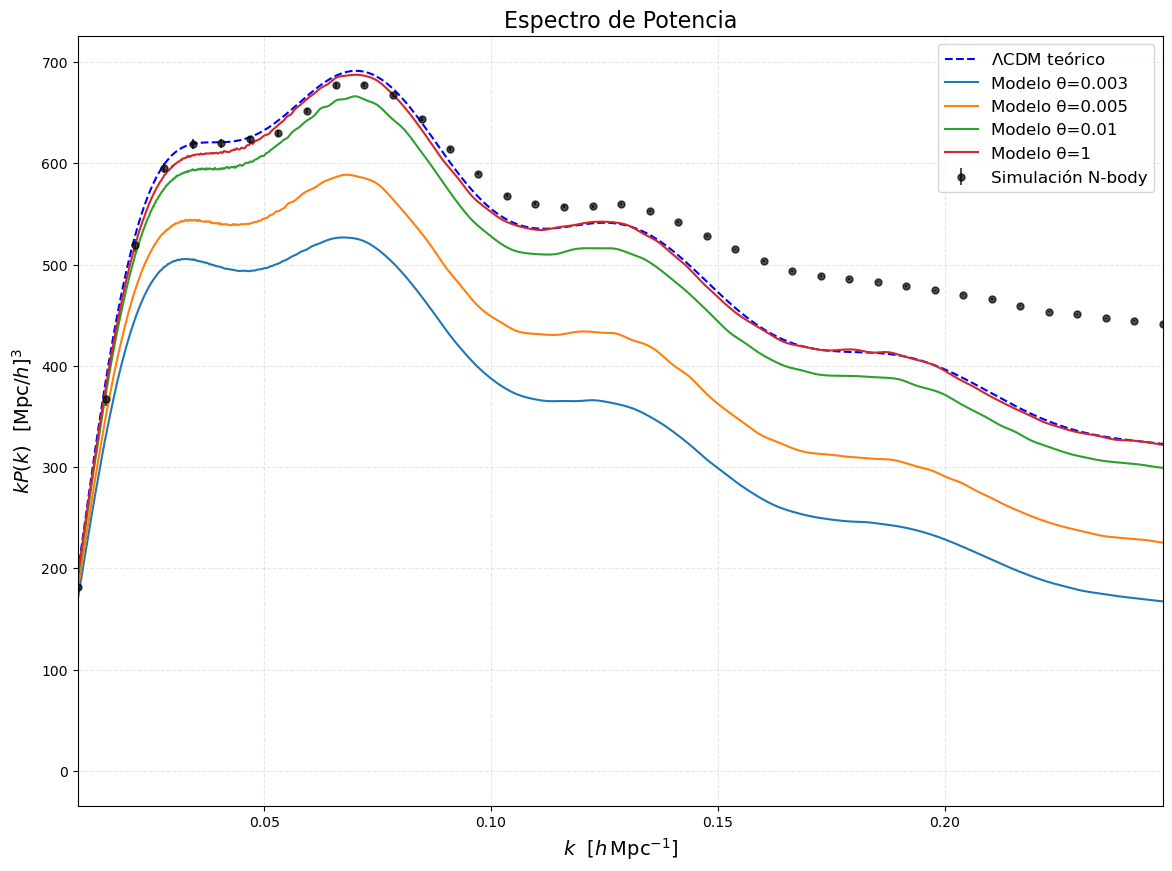

In [11]:
plt.figure(figsize=(14, 10))

# Panel superior: P(k)

#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(1e-3, 1e0)
plt.xlabel(r'$k \,\,\,\, [h\,\mathrm{Mpc}^{-1}]$', fontsize=14)
plt.ylabel(r'$kP(k) \,\,\,\, [\mathrm{Mpc}/h]^3$', fontsize=14)

# Graficar simulación N-body
plt.errorbar(k_sim,k_sim* pk_sim_mean, k_sim*pk_sim_err, 
             fmt='o', color='black', markersize=5,
             label='Simulación N-body', alpha=0.7)

# Graficar modelos teóricos (ejemplo con ΛCDM)
plt.plot(k_arr, k_arr*Pk_lcdm, color='blue', linestyle='--', 
         label=r'$\Lambda$CDM teórico')

# Graficar tus modelos quintessence (ejemplo)
for i in range(len(Pk_all)):
    plt.plot(kk, kk* Pk_all[i], label=f"Modelo θ={x_variable[i]}")
plt.xlim(k_sim[0],k_sim[-1])
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.title('Espectro de Potencia', fontsize=16)

In [12]:
cls = cosmo_lcdm.lensed_cl(2500)  # Espectros angulares lensed hasta l=2500
ll = cls['ell'][2:]  # Valores de l
clTT = cls['tt'][2:]  # C_l^TT
clEE = cls['ee'][2:]  # C_l^EE
clPP = cls['pp'][2:]  # C_l^PP

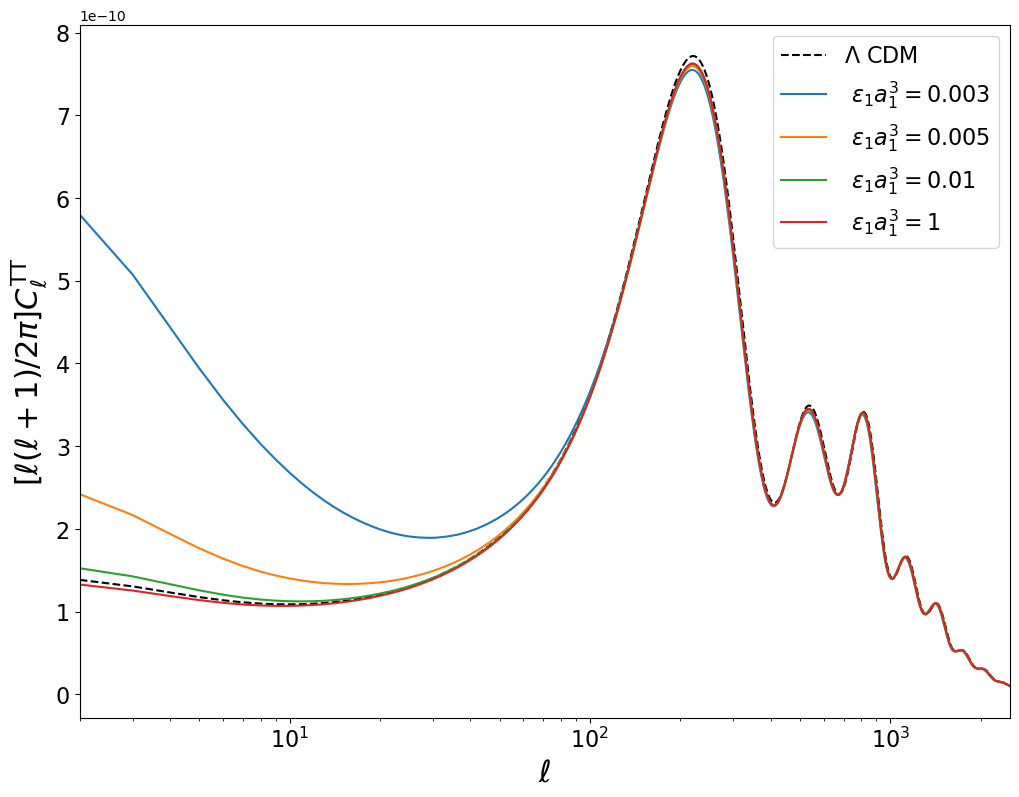

In [13]:
# plot C_l^TT

from math import pi
plt.figure(figsize=(12, 9))
#plt.figure(1)
plt.xscale('log');plt.yscale('linear');plt.xlim(2,2500)
plt.xlabel(r'$\ell$',fontsize=22)
plt.ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{TT}$', fontsize=22)
plt.plot(ll,clTT*ll*(ll+1)/2./pi, color = 'black', linestyle='--', label = '$\Lambda$ CDM')
for i in range(len(ll_all)):
    plt.plot(ll_all[i],clTT_all[i]*ll_all[i]*(ll_all[i]+1)/2./pi, label = " $\epsilon_1 a_1^3 = $"+str(x_variable[i]))
plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

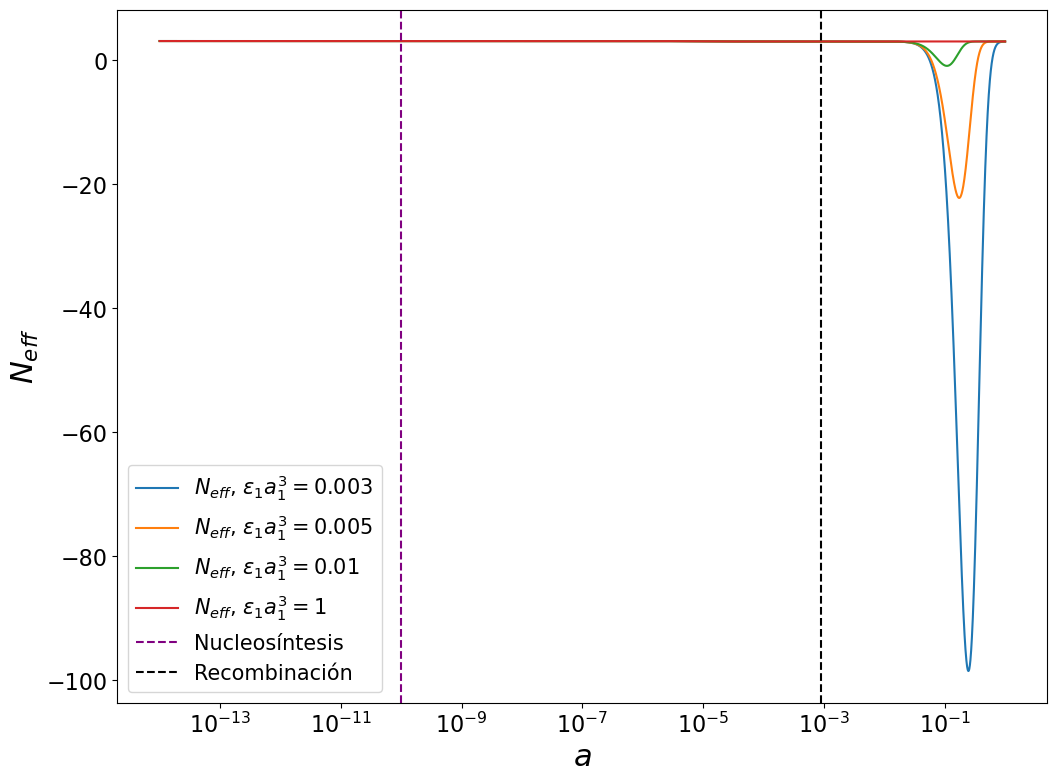

In [14]:
plt.figure(figsize=(12, 9))

plt.xscale("log")


#plt.plot(a,Neff13, color="red",label="Neff")
for i in range(len(Neff_all)):
#plt.plot(a,w_sch0,"--", color="purple",label="$\omega _{\phi}$")
    plt.plot(a_all[i],Neff_all[i],"-",label=r"$N _{eff}$, $\epsilon_1 a_1^3 = $"+str(x_variable[i]))
#plt.plot(a0,Neff0, color="red",label="Neff $\\theta=8.1 \\times 10^{-20}$")
#plt.plot(a,Neff15, color="green",label="Neff $\\theta=8.1 \\times 10^{-15}$")
#plt.plot(a,Neff17, color="purple",label="Neff $\\theta=8.1 \\times 10^{-17}$")
#plt.plot(a,Neff19, color="blue",label="Neff $\\theta=8.1 \\times 10^{-19}$")
plt.axvline(x=1e-10, ymin=0, ymax=3.8,color="purple", label="Nucleosíntesis", linestyle = '--')
plt.axvline(x=1/1100, ymin=0, ymax=3.8, color='black',label="Recombinación", linestyle = '--')
#plt.ylim(0,3.1)
#plt.plot(a,Neff, color="blue",label="Neff")
plt.tick_params(axis='both', which='major', labelsize=16)

#plt.title('Espectro de potencias', fontsize=20)
plt.xlabel('$a$',fontsize=22)
plt.ylabel('$N_{eff}$',fontsize=22)
plt.legend(fontsize=15)

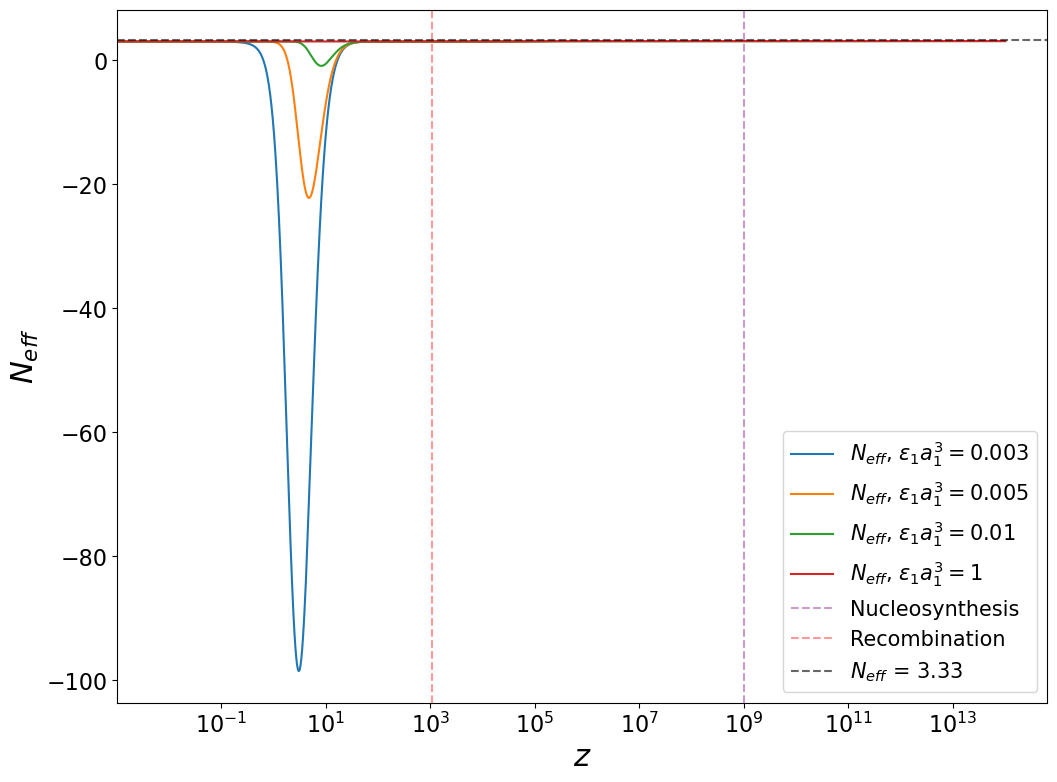

In [15]:
plt.figure(figsize=(12, 9))

plt.xscale("log")


#plt.plot(a,Neff13, color="red",label="Neff")
for i in range(len(Neff_all)):
#plt.plot(a,w_sch0,"--", color="purple",label="$\omega _{\phi}$")
    plt.plot(z_all[i],Neff_all[i],"-",label=r"$N _{eff}$, $\epsilon_1 a_1^3 = $"+str(x_variable[i]))
#plt.plot(a0,Neff0, color="red",label="Neff $\\theta=8.1 \\times 10^{-20}$")
#plt.plot(a,Neff15, color="green",label="Neff $\\theta=8.1 \\times 10^{-15}$")
#plt.plot(a,Neff17, color="purple",label="Neff $\\theta=8.1 \\times 10^{-17}$")
#plt.plot(a,Neff19, color="blue",label="Neff $\\theta=8.1 \\times 10^{-19}$")
plt.axvline(x=10**9, ymin=0, ymax=3.8,color="purple", label="Nucleosynthesis", linestyle = '--', alpha=0.4)
plt.axvline(x=1100, ymin=0, ymax=3.8, color='red',label="Recombination", linestyle = '--', alpha=0.4)
plt.axhline(3.33, color='black',label="$N_{eff}$ = 3.33", linestyle = '--', alpha=0.6)

#plt.ylim(0,3.1)
#plt.plot(a,Neff, color="blue",label="Neff")
plt.tick_params(axis='both', which='major', labelsize=16)

#plt.title('Espectro de potencias', fontsize=20)
plt.xlabel('$z$',fontsize=22)
plt.ylabel('$N_{eff}$',fontsize=22)
plt.legend(fontsize=15)

In [16]:
1/1e-10

10000000000.0

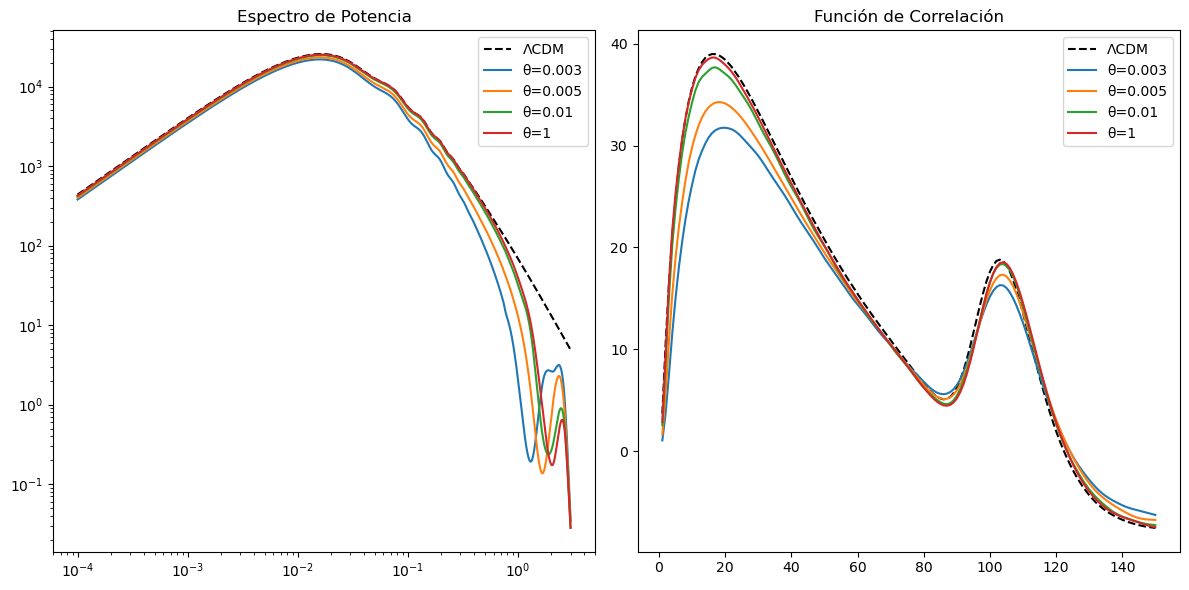

In [17]:
# ==============================================
# Graficar resultados (ejemplo)
# ==============================================
plt.figure(figsize=(12, 6))

# Graficar P(k)
plt.subplot(1, 2, 1)
plt.xscale('log')
plt.yscale('log')
plt.title('Espectro de Potencia')
plt.plot(lcdm_results['kk'], lcdm_results['Pk'], 'k--', label='ΛCDM')
for i in range(len(model_results['params'])):
    plt.plot(model_results['kk'], model_results['Pk'][i], 
             label=f"θ={model_results['params'][i]}")
plt.legend()

# Graficar 2PCF
plt.subplot(1, 2, 2)
plt.title('Función de Correlación')
plt.plot(lcdm_results['r_xi'], lcdm_results['r_xi']**2 * lcdm_results['xi_xi'], 
         'k--', label='ΛCDM')
for i in range(len(model_results['params'])):
    plt.plot(model_results['r_xi'][i], model_results['r_xi'][i]**2 * model_results['xi_xi'][i], 
             label=f"θ={model_results['params'][i]}")
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
2.89/10

0.28900000000000003

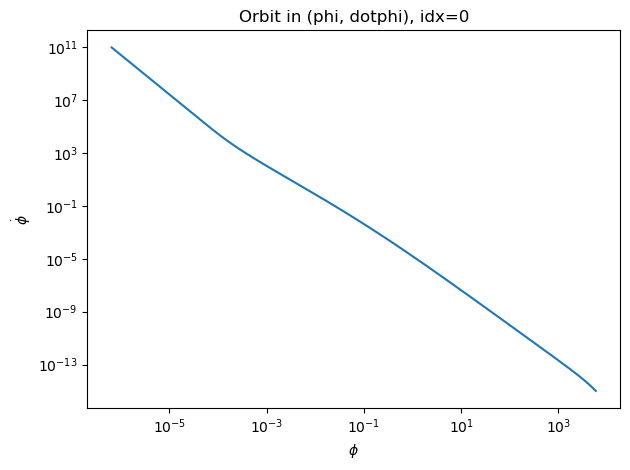

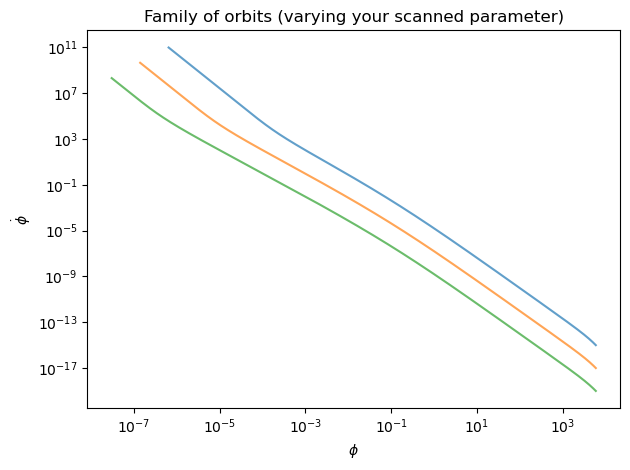

In [9]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('results/exponential_results_theta.pkl', 'rb') as f:
    R = pickle.load(f)

def get_ordered_arrays(R, idx, zmax=None):
    z = np.asarray(R['z'][idx])
    a = np.asarray(R['a'][idx])
    phi = np.asarray(R['phi'][idx])
    phi_p = np.asarray(R["phi'"][idx])

    # ordenar por a creciente
    order = np.argsort(a)
    z, a, phi, phi_p = z[order], a[order], phi[order], phi_p[order]

    if zmax is not None:
        m = (z <= zmax)
        z, a, phi, phi_p = z[m], a[m], phi[m], phi_p[m]

    dotphi = phi_p / a
    N = np.log(a)
    return N, phi, dotphi

# (A) una realización
idx = 0
N, phi, dotphi = get_ordered_arrays(R, idx, zmax=1e7)

plt.figure()
plt.plot(phi, dotphi)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\dot\phi$')
plt.title(f'Orbit in (phi, dotphi), idx={idx}')
plt.tight_layout()
plt.show()

# (B) superponer varias realizaciones (cambias parámetro => cambias el sistema)
plt.figure()
for idx in range(len(R['phi'])):
    N, phi, dotphi = get_ordered_arrays(R, idx, zmax=1e7)
    plt.plot(phi, dotphi, alpha=0.7)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\dot\phi$')
plt.yscale('log')
plt.xscale('log')
plt.title('Family of orbits (varying your scanned parameter)')
plt.tight_layout()
plt.show()


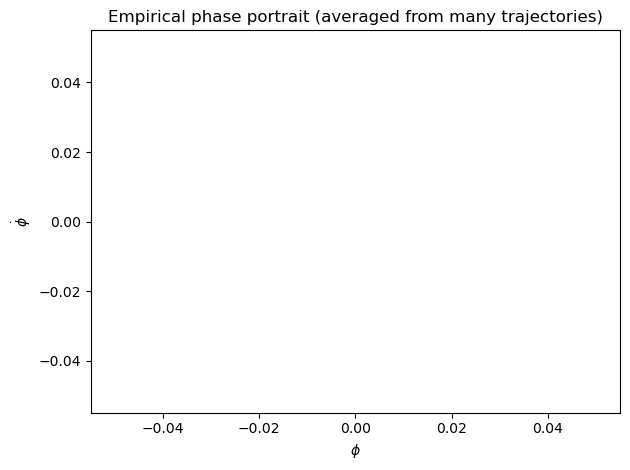

In [10]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('results/exponential_results_theta.pkl', 'rb') as f:
    R = pickle.load(f)

def collect_samples(R, zmax=1e7):
    PHI, VEL, U, V = [], [], [], []
    for idx in range(len(R['phi'])):
        z = np.asarray(R['z'][idx])
        a = np.asarray(R['a'][idx])
        phi = np.asarray(R['phi'][idx])
        phi_p = np.asarray(R["phi'"][idx])

        order = np.argsort(a)
        z, a, phi, phi_p = z[order], a[order], phi[order], phi_p[order]

        m = (z <= zmax)
        z, a, phi, phi_p = z[m], a[m], phi[m], phi_p[m]

        N = np.log(a)
        dotphi = phi_p / a

        # derivadas respecto a N
        dphi_dN = np.gradient(phi, N)
        ddotphi_dN = np.gradient(dotphi, N)

        # acumular
        PHI.append(phi); VEL.append(dotphi)
        U.append(dphi_dN); V.append(ddotphi_dN)

    return np.concatenate(PHI), np.concatenate(VEL), np.concatenate(U), np.concatenate(V)

phi_s, v_s, u_s, w_s = collect_samples(R, zmax=1e7)

# definir caja de la malla usando percentiles para evitar outliers
p1, p99 = 1, 99
phi_min, phi_max = np.percentile(phi_s, [p1, p99])
v_min, v_max     = np.percentile(v_s,   [p1, p99])

nx, ny = 60, 60
phi_edges = np.linspace(phi_min, phi_max, nx+1)
v_edges   = np.linspace(v_min, v_max, ny+1)

# binning: promedio de (u,w) por celda
Ugrid = np.zeros((ny, nx)); Vgrid = np.zeros((ny, nx))
Cgrid = np.zeros((ny, nx))  # conteos

ix = np.digitize(phi_s, phi_edges) - 1
iy = np.digitize(v_s,   v_edges)   - 1

mask = (ix >= 0) & (ix < nx) & (iy >= 0) & (iy < ny) & np.isfinite(u_s) & np.isfinite(w_s)
ix, iy, u_s2, w_s2 = ix[mask], iy[mask], u_s[mask], w_s[mask]

for i, j, uu, vv in zip(ix, iy, u_s2, w_s2):
    Ugrid[j, i] += uu
    Vgrid[j, i] += vv
    Cgrid[j, i] += 1

# evitar división por cero
nonzero = Cgrid > 0
Ugrid[nonzero] /= Cgrid[nonzero]
Vgrid[nonzero] /= Cgrid[nonzero]

# centros de celda
phi_cent = 0.5*(phi_edges[:-1] + phi_edges[1:])
v_cent   = 0.5*(v_edges[:-1]   + v_edges[1:])
PHI, VEL = np.meshgrid(phi_cent, v_cent)

plt.figure()
# dibuja el campo sólo donde hay datos
Uplot = np.where(nonzero, Ugrid, np.nan)
Vplot = np.where(nonzero, Vgrid, np.nan)

plt.streamplot(PHI, VEL, Uplot, Vplot, density=1.2)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\dot\phi$')
plt.title('Empirical phase portrait (averaged from many trajectories)')
plt.tight_layout()
plt.show()


aquí voy y todo bien 2
aquí voy y todo bien 2
aquí voy y todo bien 2.02167
aquí voy y todo bien 2.11016
aquí voy y todo bien 2.06591
aquí voy y todo bien 2.08008
aquí voy y todo bien 2.073
aquí voy y todo bien 2.08008



=== Reconstructed constants (from python) ===
theta       = 3.333333e-18
X0          = 1
lambda_V    = 1
V0          = 4.32
H0 [1/Mpc]  = 2.304928e-04
Omega0_smg  = 2.525807e-01
F2 (python) = 1.006413e+09
C=F2*X0     = 1.006413e+09
F0 (median) = 1.006413e+09


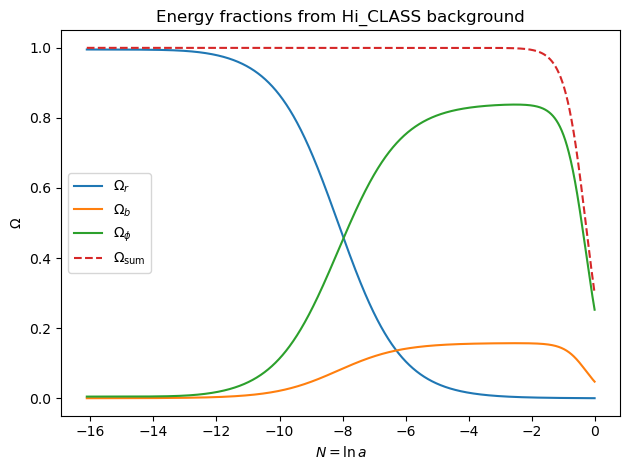

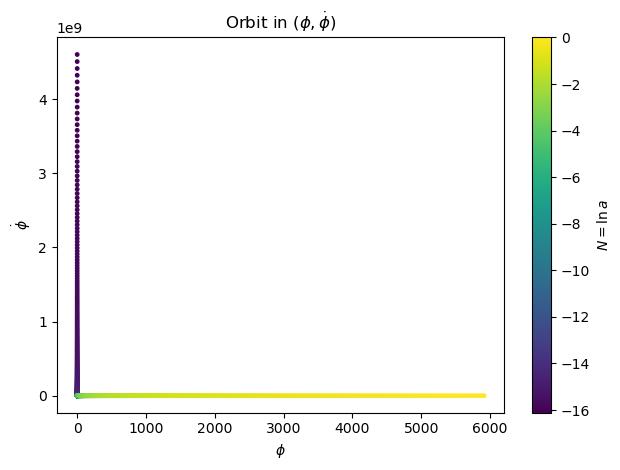

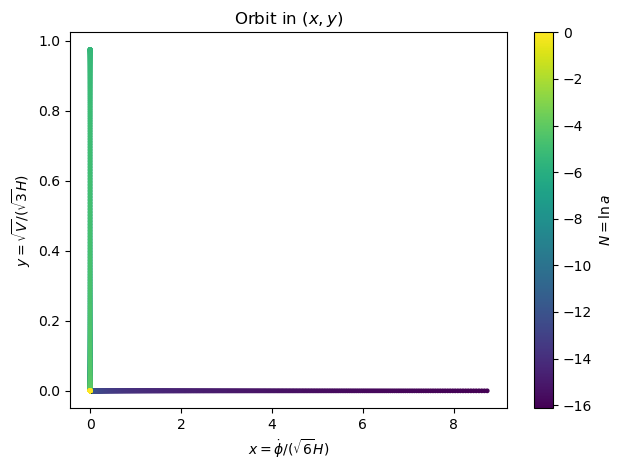

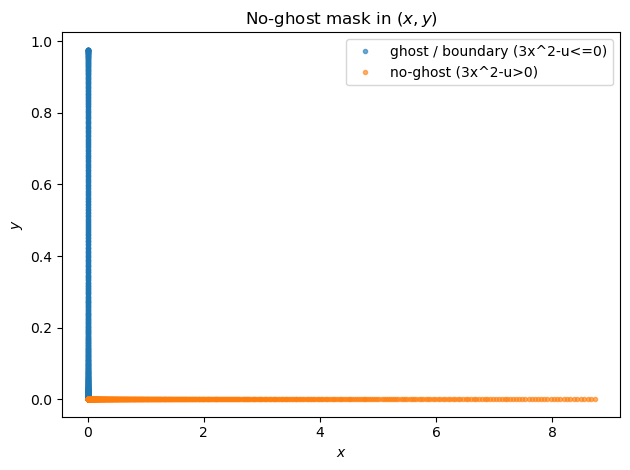

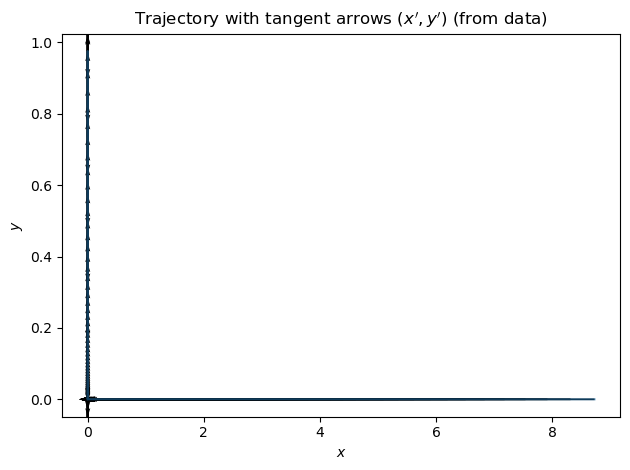

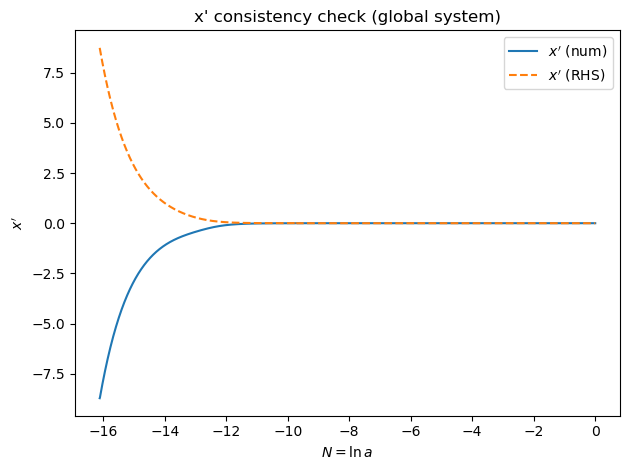

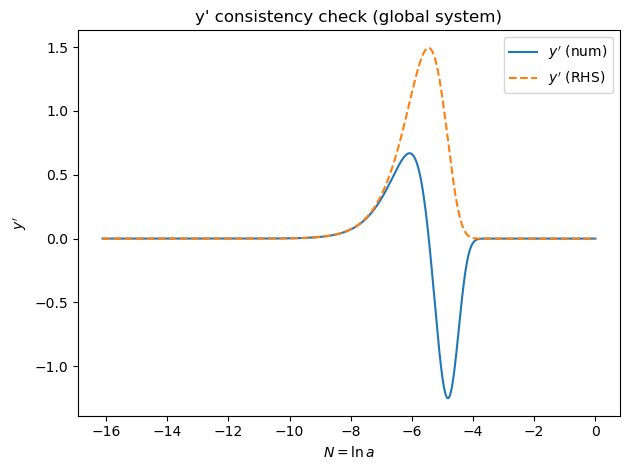

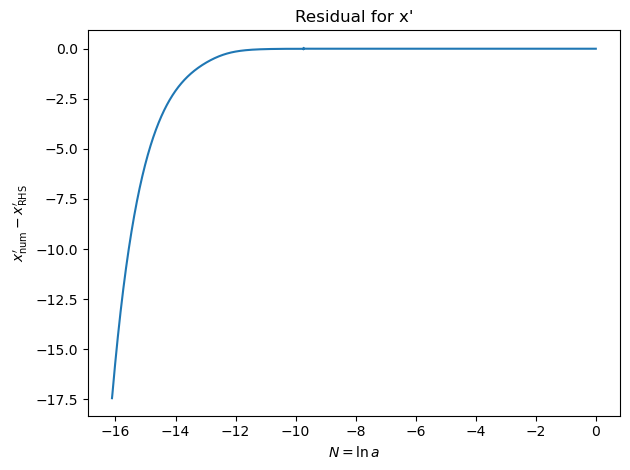

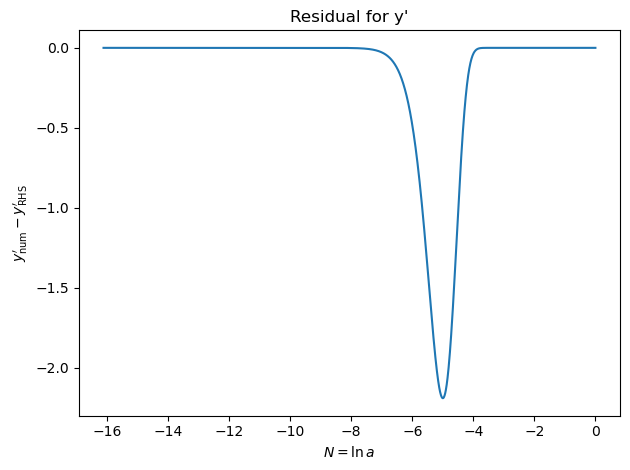

In [12]:
# ==============================================
# Phase space reconstruction from Hi_CLASS (one theta)
# Exponential potential: V(phi) = V0 * exp(-lambda * phi)
# Builds: (phi, dotphi), (x,y) trajectory + quiver, and checks x', y' vs RHS (global system)
# Requires: classy (Hi_CLASS) + numpy + matplotlib
# ==============================================

import numpy as np
import matplotlib.pyplot as plt
from classy import Class

# ------------------------------
# 1) Fixed-parameter run (ONE theta)
# ------------------------------
theta = (1/3) * 1e-17     # <-- choose your theta here
X0    = 1.0               # x0_schm (you said this is X_0)
V0    = 4.32              # V0_schm
lamV  = 1.0               # lambda_schm (slope of exponential potential)
DM_sch = 0.26             # DM_schm (as in your run)

settings = {
    'output': 'mPk,tCl,pCl,lCl',
    'P_k_max_1/Mpc': 3.0,
    'k_output_values': '0.5',
    'h': 0.691,

    # matter content choices (as in your scripts)
    'omega_b': 0.0226,
    'Omega_cdm': 0,
    'Omega_Lambda': 0.70,

    # modified gravity / k-essence model
    'Omega_fld': 0,
    'Omega_smg': -1,
    'gravity_model': 'quintessence_monomial',

    # Scherrer/exponential parameters in your Hi_CLASS branch
    'x0_schm': X0,
    'theta_schm': theta,
    'DM_schm': DM_sch,
    'h_schm': 2,          # shooting parameter (ignored in theory reconstruction)
    'V0_schm': V0,
    'lambda_schm': lamV,

    # perturbations (irrelevant for phase-space; keep if you want)
    'A_s': 2.06e-9,
    'n_s': 0.972,
    'tau_reio': 0.0477,
    'compute damping scale': 'yes',
    'lensing': 'yes',

    # more background sampling
    'output_background_smg': 10,
}

cosmo = Class()
cosmo.set(settings)
cosmo.compute()

bg = cosmo.get_background()

# ------------------------------
# 2) Extract background arrays
# ------------------------------
z        = np.asarray(bg['z'])
a        = 1.0 / (1.0 + z)
H        = np.asarray(bg['H [1/Mpc]'])        # <-- you confirmed this key

rho_g    = np.asarray(bg['(.)rho_g'])
rho_ur   = np.asarray(bg['(.)rho_ur'])
rho_b    = np.asarray(bg['(.)rho_b'])
rho_crit = np.asarray(bg['(.)rho_crit'])

rho_smg  = np.asarray(bg['(.)rho_smg'])
p_smg    = np.asarray(bg['(.)p_smg'])

phi      = np.asarray(bg['phi_smg'])
phi_p    = np.asarray(bg["phi'"])             # dphi/dtau (conformal time), per CLASS convention

# Order by a increasing (past -> present)
order = np.argsort(a)
z, a, H = z[order], a[order], H[order]
rho_g, rho_ur, rho_b = rho_g[order], rho_ur[order], rho_b[order]
rho_crit = rho_crit[order]
rho_smg, p_smg = rho_smg[order], p_smg[order]
phi, phi_p = phi[order], phi_p[order]

# Optional: cut very early times to avoid huge dynamic ranges in plots
zmax = 1e7
m_z = (z <= zmax)
z, a, H = z[m_z], a[m_z], H[m_z]
rho_g, rho_ur, rho_b = rho_g[m_z], rho_ur[m_z], rho_b[m_z]
rho_crit = rho_crit[m_z]
rho_smg, p_smg = rho_smg[m_z], p_smg[m_z]
phi, phi_p = phi[m_z], phi_p[m_z]

N = np.log(a)

# ------------------------------
# 3) Reconstruct kinetic quantities and phase variables
# ------------------------------
# dotphi = (dphi/dtau)/a
dotphi = phi_p / a
X      = 0.5 * dotphi**2

# Omegas (global content)
rho_r    = rho_g + rho_ur
Omega_r  = rho_r / rho_crit
Omega_b  = rho_b / rho_crit
Omega_phi = rho_smg / rho_crit
Omega_sum = Omega_r + Omega_b + Omega_phi

# Potential and y
V = V0 * np.exp(-lamV * phi)
y = np.sqrt(np.maximum(V, 0.0)) / (np.sqrt(3.0) * H)

# x and u from your definitions
x = dotphi / (np.sqrt(6.0) * H)
u = X0 / (H**2)

# No-ghost region in your variables: X > X0  <=>  3 x^2 - u > 0
Delta = 3.0 * x**2 - u
no_ghost = (Delta > 0)

# ------------------------------
# 4) Recover Omega0_smg and compute F2 from your C formula
#     f2_sch = Omega0_smg * H0^2 / (4 * x0^2 * theta)
#     We estimate Omega0_smg and H0 from the z~0 entry of the background.
# ------------------------------
i0 = np.argmin(np.abs(z))  # closest to z=0
H0_1Mpc = H[i0]
Omega0_smg = Omega_phi[i0]  # rho_smg0 / rho_crit0

F2 = (Omega0_smg * H0_1Mpc**2) / (4.0 * (X0**2) * theta)
C  = F2 * X0

print("\n=== Reconstructed constants (from python) ===")
print(f"theta       = {theta:.6e}")
print(f"X0          = {X0:g}")
print(f"lambda_V    = {lamV:g}")
print(f"V0          = {V0:g}")
print(f"H0 [1/Mpc]  = {H0_1Mpc:.6e}")
print(f"Omega0_smg  = {Omega0_smg:.6e}")
print(f"F2 (python) = {F2:.6e}")
print(f"C=F2*X0     = {C:.6e}")

# ------------------------------
# 5) Optional: reconstruct F0 from background to get z-variable of the dynamical system
#     Using p_phi = -F0 + F2 (X-X0)^2 - V   =>  F0 = F2 (X-X0)^2 - V - p_phi
# ------------------------------
F0_arr = F2 * (X - X0)**2 - V - p_smg
# Robust estimate (ignore negative/NaN if any)
F0_pos = F0_arr[np.isfinite(F0_arr) & (F0_arr > 0)]
F0_est = np.median(F0_pos) if F0_pos.size > 0 else np.nan

if np.isfinite(F0_est):
    zvar = np.sqrt(F0_est) / (np.sqrt(3.0) * H)  # z = sqrt(F0)/(sqrt(3) H)
    print(f"F0 (median) = {F0_est:.6e}")
else:
    zvar = np.full_like(H, np.nan)
    print("F0 could not be robustly reconstructed (no positive values).")

# ------------------------------
# 6) Compute x', y' numerically (vs N) and compare to your GLOBAL dynamical RHS
#     w_tot = p_tot / rho_tot = (p_phi + rho_r/3) / (rho_crit)  (since rho_tot = rho_crit)
# ------------------------------
# numerical derivatives
xprime_num = np.gradient(x, N)
yprime_num = np.gradient(y, N)

# global w_tot (uses CLASS p_smg and radiation)
w_tot = (p_smg + rho_r/3.0) / rho_crit

# RHS from your global system (exponential):
# x' = -3x(3x^2-u)/(9x^2-u) + (3 lambda y^2)/(2 sqrt6) * (u/C) * 1/(9x^2-u) + (3/2) x (1+w_tot)
den = (9.0*x**2 - u)
# avoid division by zero for safety
safe = np.isfinite(den) & (np.abs(den) > 1e-30) & np.isfinite(C) & (C != 0)

xprime_rhs = np.full_like(xprime_num, np.nan)
yprime_rhs = np.full_like(yprime_num, np.nan)

xprime_rhs[safe] = (
    -3.0*x[safe] * (3.0*x[safe]**2 - u[safe]) / den[safe]
    + (3.0*lamV*y[safe]**2)/(2.0*np.sqrt(6.0)) * (u[safe]/C) * (1.0/den[safe])
    + 1.5*x[safe]*(1.0 + w_tot[safe])
)

yprime_rhs[safe] = y[safe] * (1.5*(1.0 + w_tot[safe]) - (np.sqrt(6.0)/2.0)*lamV*x[safe])

# ------------------------------
# 7) Plots
# ------------------------------

# (A) sanity checks: Omegas
plt.figure()
plt.plot(N, Omega_r, label=r'$\Omega_r$')
plt.plot(N, Omega_b, label=r'$\Omega_b$')
plt.plot(N, Omega_phi, label=r'$\Omega_\phi$')
plt.plot(N, Omega_sum, '--', label=r'$\Omega_{\rm sum}$')
plt.xlabel(r'$N=\ln a$')
plt.ylabel(r'$\Omega$')
plt.legend()
plt.title('Energy fractions from Hi_CLASS background')
plt.tight_layout()
plt.show()

# (B) Orbit in (phi, dotphi)
plt.figure()
plt.yscale('log')
plt.xscale('log')

sc = plt.scatter(phi, dotphi, c=N, s=6)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\dot\phi$')
cb = plt.colorbar(sc); cb.set_label(r'$N=\ln a$')
plt.title(r'Orbit in $(\phi,\dot\phi)$')
plt.tight_layout()
plt.show()

# (C) Orbit in (x, y), color by N, and mark no-ghost region
plt.figure()
sc = plt.scatter(x, y, c=N, s=6)
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$x=\dot\phi/(\sqrt{6} H)$')
plt.ylabel(r'$y=\sqrt{V}/(\sqrt{3} H)$')
cb = plt.colorbar(sc); cb.set_label(r'$N=\ln a$')
plt.title(r'Orbit in $(x,y)$')
plt.tight_layout()
plt.show()

plt.figure()
plt.yscale('log')
plt.xscale('log')

plt.plot(x[~no_ghost], y[~no_ghost], '.', label='ghost / boundary (3x^2-u<=0)', alpha=0.6)
plt.plot(x[no_ghost],  y[no_ghost],  '.', label='no-ghost (3x^2-u>0)', alpha=0.6)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.title(r'No-ghost mask in $(x,y)$')
plt.tight_layout()
plt.show()

# (D) Quiver along the trajectory (numerical derivatives as arrows)
# Subsample for readability
step = max(1, len(x)//300)
plt.figure()
plt.yscale('log')
plt.xscale('log')

plt.plot(x, y, '-', alpha=0.5)
plt.quiver(
    x[::step], y[::step],
    xprime_num[::step], yprime_num[::step],
    angles='xy', scale_units='xy', scale=1.0, width=0.003
)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Trajectory with tangent arrows $(x^\prime,y^\prime)$ (from data)')
plt.tight_layout()
plt.show()

# (E) Check: numerical vs RHS (global system) along the same trajectory
plt.figure()
plt.yscale('log')
plt.xscale('log')

plt.plot(N, xprime_num, label=r'$x^\prime$ (num)')
plt.plot(N, xprime_rhs, '--', label=r'$x^\prime$ (RHS)')
plt.xlabel(r'$N=\ln a$')
plt.ylabel(r'$x^\prime$')
plt.legend()
plt.title("x' consistency check (global system)")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(N, yprime_num, label=r'$y^\prime$ (num)')
plt.plot(N, yprime_rhs, '--', label=r'$y^\prime$ (RHS)')
plt.xlabel(r'$N=\ln a$')
plt.ylabel(r'$y^\prime$')
plt.legend()
plt.title("y' consistency check (global system)")
plt.tight_layout()
plt.show()

# Residuals (useful to diagnose mismatch of conventions)
plt.figure()
plt.yscale('log')
plt.xscale('log')

plt.plot(N, xprime_num - xprime_rhs)
plt.xlabel(r'$N=\ln a$')
plt.ylabel(r'$x^\prime_{\rm num}-x^\prime_{\rm RHS}$')
plt.title("Residual for x'")
plt.tight_layout()
plt.show()

plt.figure()
plt.yscale('log')
plt.xscale('log')

plt.plot(N, yprime_num - yprime_rhs)
plt.xlabel(r'$N=\ln a$')
plt.ylabel(r'$y^\prime_{\rm num}-y^\prime_{\rm RHS}$')
plt.title("Residual for y'")
plt.tight_layout()
plt.show()

# Cleanup
cosmo.struct_cleanup()


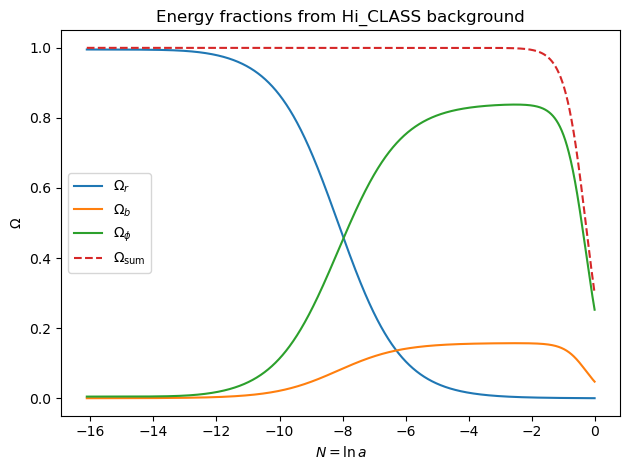

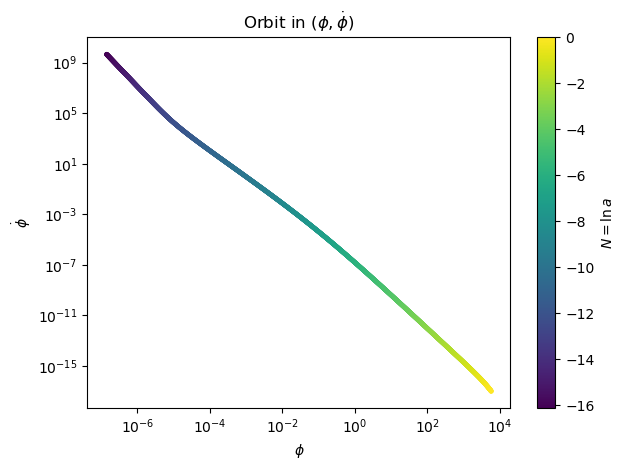

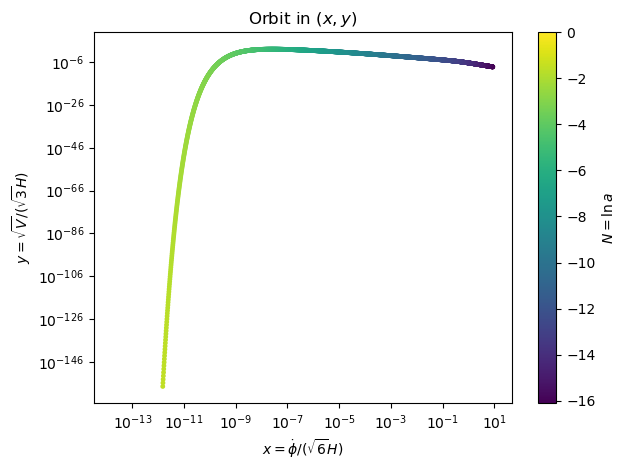

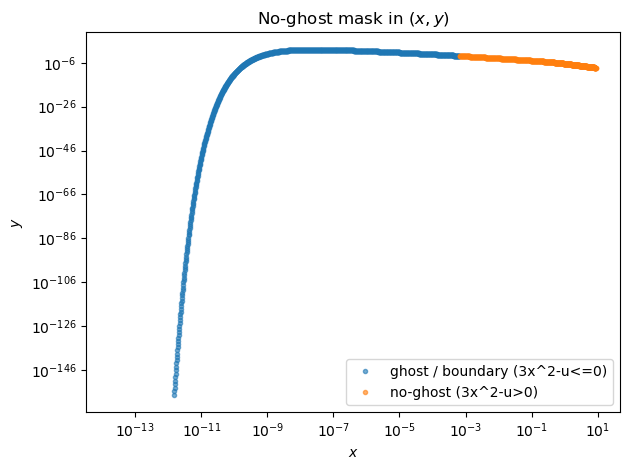

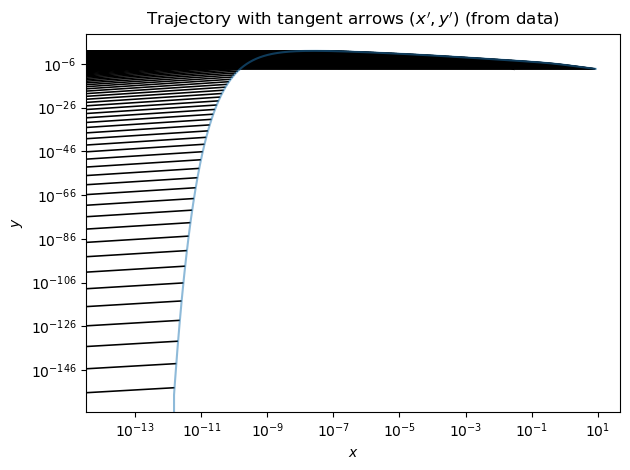

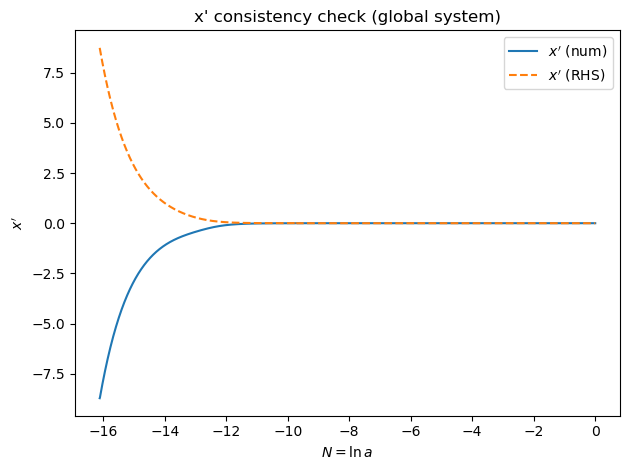

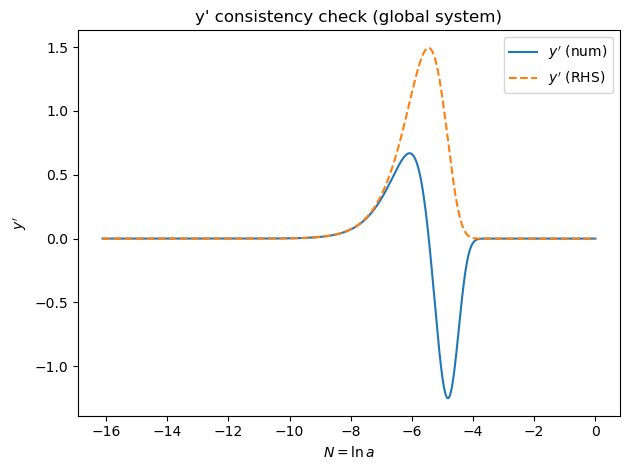

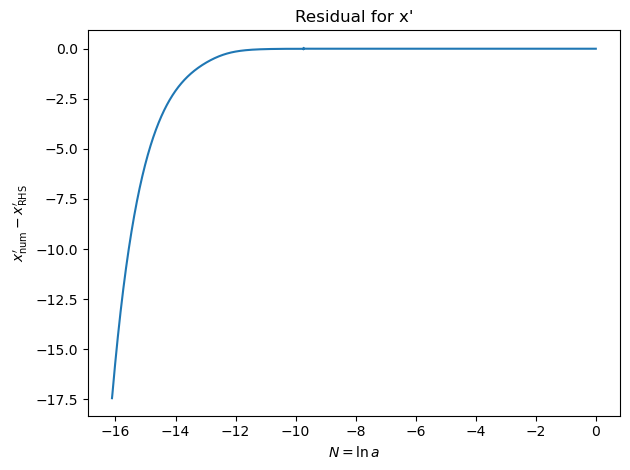

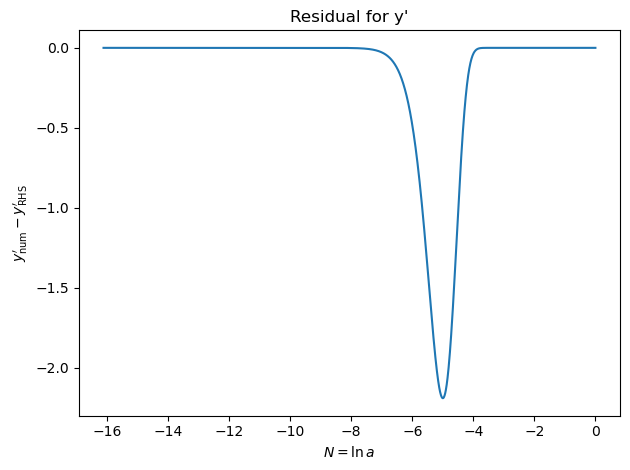

In [14]:
# (A) sanity checks: Omegas
plt.figure()
plt.plot(N, Omega_r, label=r'$\Omega_r$')
plt.plot(N, Omega_b, label=r'$\Omega_b$')
plt.plot(N, Omega_phi, label=r'$\Omega_\phi$')
plt.plot(N, Omega_sum, '--', label=r'$\Omega_{\rm sum}$')
plt.xlabel(r'$N=\ln a$')
plt.ylabel(r'$\Omega$')
plt.legend()
plt.title('Energy fractions from Hi_CLASS background')
plt.tight_layout()
plt.show()

# (B) Orbit in (phi, dotphi)
plt.figure()
plt.yscale('log')
plt.xscale('log')

sc = plt.scatter(phi, dotphi, c=N, s=6)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\dot\phi$')
cb = plt.colorbar(sc); cb.set_label(r'$N=\ln a$')
plt.title(r'Orbit in $(\phi,\dot\phi)$')
plt.tight_layout()
plt.show()

# (C) Orbit in (x, y), color by N, and mark no-ghost region
plt.figure()
sc = plt.scatter(x, y, c=N, s=6)
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$x=\dot\phi/(\sqrt{6} H)$')
plt.ylabel(r'$y=\sqrt{V}/(\sqrt{3} H)$')
cb = plt.colorbar(sc); cb.set_label(r'$N=\ln a$')
plt.title(r'Orbit in $(x,y)$')
plt.tight_layout()
plt.show()

plt.figure()
plt.yscale('log')
plt.xscale('log')

plt.plot(x[~no_ghost], y[~no_ghost], '.', label='ghost / boundary (3x^2-u<=0)', alpha=0.6)
plt.plot(x[no_ghost],  y[no_ghost],  '.', label='no-ghost (3x^2-u>0)', alpha=0.6)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.title(r'No-ghost mask in $(x,y)$')
plt.tight_layout()
plt.show()

# (D) Quiver along the trajectory (numerical derivatives as arrows)
# Subsample for readability
step = max(1, len(x)//300)
plt.figure()
plt.yscale('log')
plt.xscale('log')

plt.plot(x, y, '-', alpha=0.5)
plt.quiver(
    x[::step], y[::step],
    xprime_num[::step], yprime_num[::step],
    angles='xy', scale_units='xy', scale=1.0, width=0.003
)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Trajectory with tangent arrows $(x^\prime,y^\prime)$ (from data)')
plt.tight_layout()
plt.show()

# (E) Check: numerical vs RHS (global system) along the same trajectory
plt.figure()


plt.plot(N, xprime_num, label=r'$x^\prime$ (num)')
plt.plot(N, xprime_rhs, '--', label=r'$x^\prime$ (RHS)')
plt.xlabel(r'$N=\ln a$')
plt.ylabel(r'$x^\prime$')
plt.legend()
plt.title("x' consistency check (global system)")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(N, yprime_num, label=r'$y^\prime$ (num)')
plt.plot(N, yprime_rhs, '--', label=r'$y^\prime$ (RHS)')
plt.xlabel(r'$N=\ln a$')
plt.ylabel(r'$y^\prime$')
plt.legend()
plt.title("y' consistency check (global system)")
plt.tight_layout()
plt.show()

# Residuals (useful to diagnose mismatch of conventions)
plt.figure()


plt.plot(N, xprime_num - xprime_rhs)
plt.xlabel(r'$N=\ln a$')
plt.ylabel(r'$x^\prime_{\rm num}-x^\prime_{\rm RHS}$')
plt.title("Residual for x'")
plt.tight_layout()
plt.show()

plt.figure()


plt.plot(N, yprime_num - yprime_rhs)
plt.xlabel(r'$N=\ln a$')
plt.ylabel(r'$y^\prime_{\rm num}-y^\prime_{\rm RHS}$')
plt.title("Residual for y'")
plt.tight_layout()
plt.show()

aquí voy y todo bien 2
aquí voy y todo bien 2
aquí voy y todo bien 2.02167
aquí voy y todo bien 2.11016
aquí voy y todo bien 2.06591
aquí voy y todo bien 2.08008
aquí voy y todo bien 2.073
aquí voy y todo bien 2.08008



=== Constants reconstructed in python ===
theta       = 3.333333e-18
H0 [1/Mpc]  = 2.304928e-04
Omega0_smg  = 2.525807e-01
F2          = 1.006413e+09
C=F2*X0     = 1.006413e+09


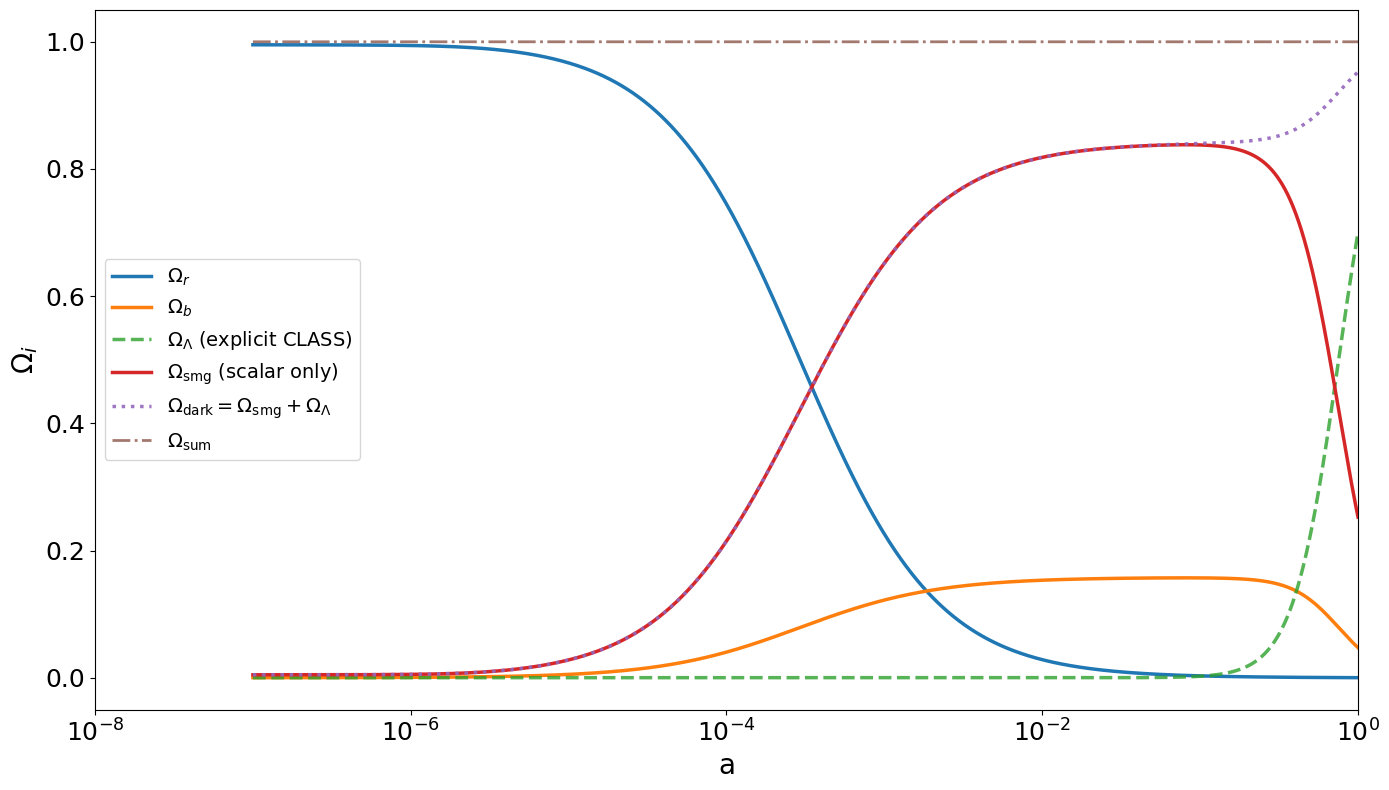

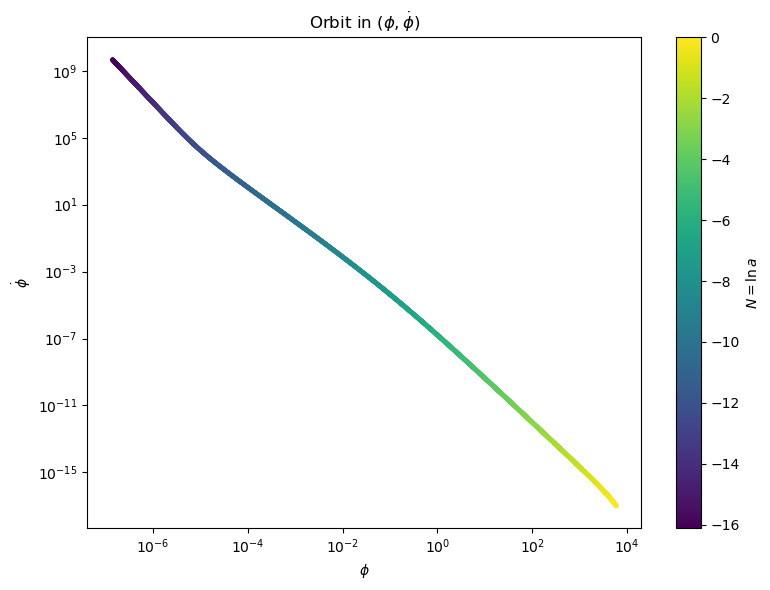

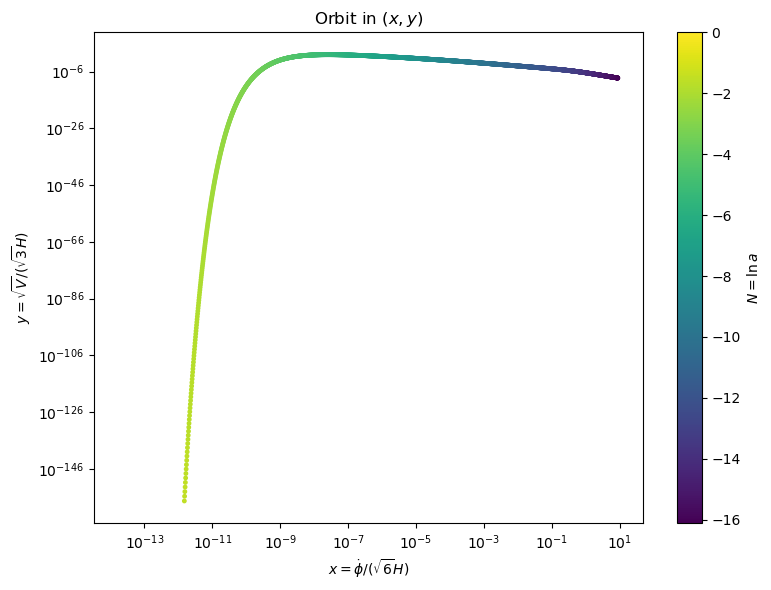

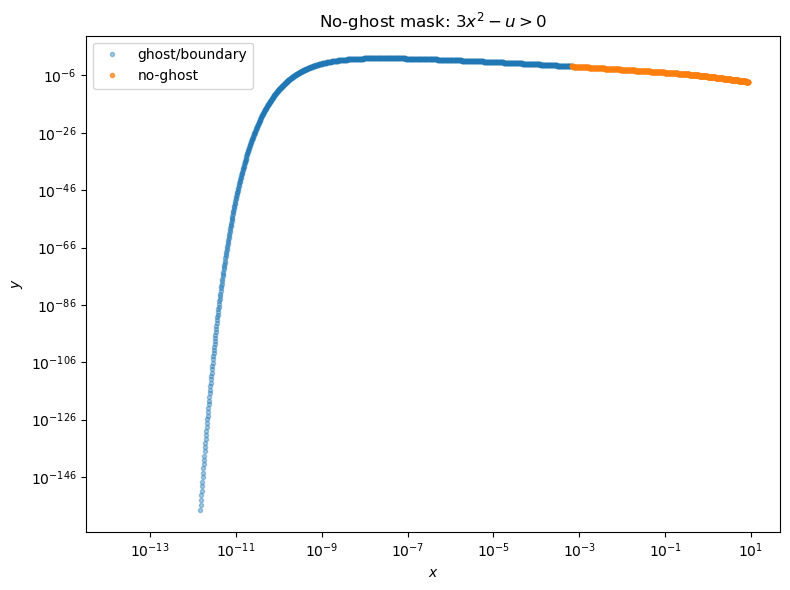

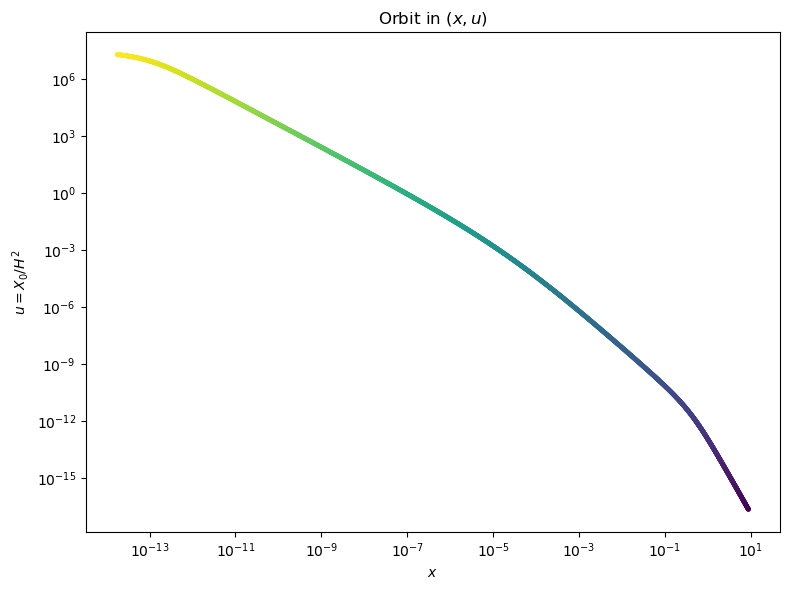

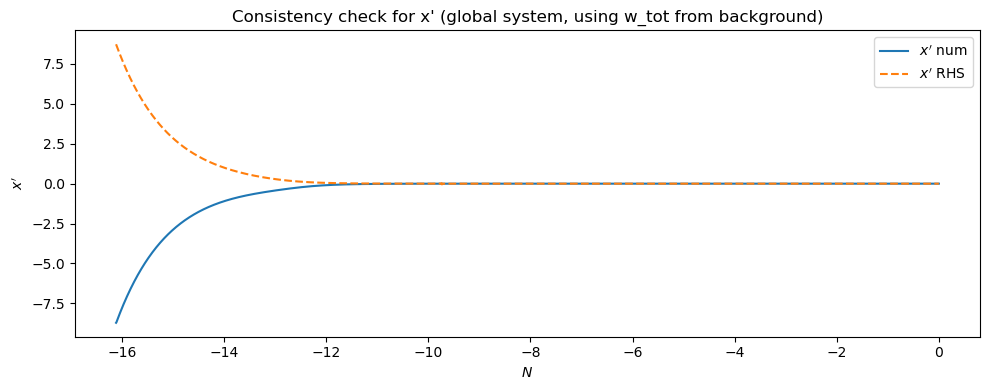

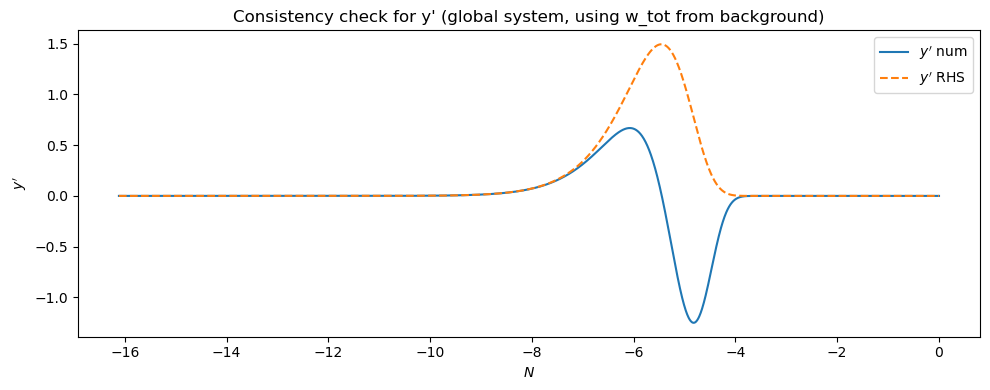

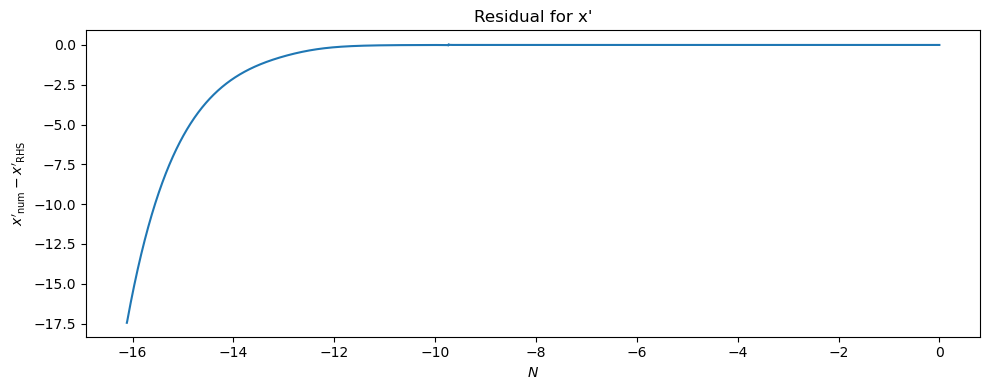

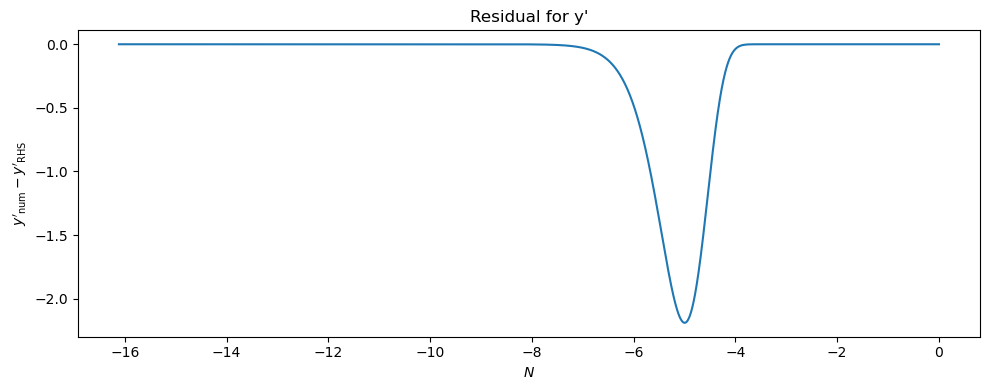

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class

# =========================================
# USER INPUTS (set these to your run)
# =========================================
theta = (1/3)*1e-17     # one theta
X0    = 1.0             # x0_schm (you said this IS X_0)
V0    = 4.32            # V0_schm
lamV  = 1.0             # lambda_schm (potential slope)
DM_sch = 0.26           # DM_schm
OmegaL = 0.70           # Omega_Lambda (explicit LCDM vacuum)

# =========================================
# Hi_CLASS settings (minimal)
# IMPORTANT: Here F0 is effectively 0 in your Hi_CLASS branch (as you said)
# =========================================
settings = {
    'output': 'mPk,tCl,pCl,lCl',
    'P_k_max_1/Mpc': 3.0,
    'k_output_values': '0.5',

    'h': 0.691,
    'omega_b': 0.0226,
    'Omega_cdm': 0,
    'Omega_Lambda': OmegaL,

    'Omega_fld': 0,
    'Omega_smg': -1,
    'gravity_model': 'quintessence_monomial',

    'x0_schm': X0,
    'theta_schm': theta,
    'DM_schm': DM_sch,
    'h_schm': 2,           # shooting param; ignored analytically
    'V0_schm': V0,
    'lambda_schm': lamV,

    'A_s': 2.06e-9,
    'n_s': 0.972,
    'tau_reio': 0.0477,
    'lensing': 'yes',
    'compute damping scale': 'yes',
    'output_background_smg': 10,
}

cosmo = Class()
cosmo.set(settings)
cosmo.compute()

bg = cosmo.get_background()

# =========================================
# Extract background arrays
# =========================================
z        = np.asarray(bg['z'])
a        = 1.0/(1.0+z)
N        = np.log(a)

H        = np.asarray(bg['H [1/Mpc]'])       # <- you confirmed this key
phi      = np.asarray(bg['phi_smg'])
phi_p    = np.asarray(bg["phi'"])            # CLASS convention: usually dphi/dtau

rho_g    = np.asarray(bg['(.)rho_g'])
rho_ur   = np.asarray(bg['(.)rho_ur'])
rho_r    = rho_g + rho_ur
rho_b    = np.asarray(bg['(.)rho_b'])
rho_lam  = np.asarray(bg['(.)rho_lambda'])
rho_crit = np.asarray(bg['(.)rho_crit'])

rho_smg  = np.asarray(bg['(.)rho_smg'])
p_smg    = np.asarray(bg['(.)p_smg'])
M2_smg   = np.asarray(bg['M*^2_smg'])
 

# Order by a increasing (early -> late)
order = np.argsort(a)
z, a, N = z[order], a[order], N[order]
H, phi, phi_p = H[order], phi[order], phi_p[order]
rho_r, rho_b, rho_lam, rho_crit = rho_r[order], rho_b[order], rho_lam[order], rho_crit[order]
rho_smg, p_smg = rho_smg[order], p_smg[order]

# Optional: cut extremely early times for readability
zmax = 1e7
m = (z <= zmax)
z, a, N = z[m], a[m], N[m]
H, phi, phi_p = H[m], phi[m], phi_p[m]
rho_r, rho_b, rho_lam, rho_crit = rho_r[m], rho_b[m], rho_lam[m], rho_crit[m]
rho_smg, p_smg = rho_smg[m], p_smg[m]
M2_smg  = M2_smg[m]

# =========================================
# Reconstruct phase variables
# =========================================
# If your build uses phi' = dphi/dtau, then dotphi = phi'/a.
# If later your consistency checks fail badly, try dotphi = phi_p instead.
dotphi = phi_p / a
X      = 0.5*dotphi**2

Omega_r   = rho_r / rho_crit
Omega_b   = rho_b / rho_crit
Omega_L   = rho_lam / rho_crit
Omega_smg = rho_smg / rho_crit
Omega_sum = Omega_r + Omega_b + Omega_L + Omega_smg

# x, u, y (exponential potential)
x = dotphi / (np.sqrt(6.0)*H)
u = X0 / (H**2)

V = V0 * np.exp(-lamV*phi)
y = np.sqrt(np.maximum(V, 0.0)) / (np.sqrt(3.0)*H)

# No-ghost region for your k-essence: X > X0 <=> 3 x^2 - u > 0
Delta = 3.0*x**2 - u
no_ghost = (Delta > 0)

# =========================================
# Reconstruct F2 from your internal Hi_CLASS formula:
# f2_sch = Omega0_smg * H0^2 / (4 * X0^2 * theta)
# =========================================
i0 = np.argmin(np.abs(z))        # closest to z=0 after cuts
H0 = H[i0]
Omega0_smg = Omega_smg[i0]
F2 = (Omega0_smg * H0**2) / (4.0*(X0**2)*theta)
C  = F2*X0

print("\n=== Constants reconstructed in python ===")
print(f"theta       = {theta:.6e}")
print(f"H0 [1/Mpc]  = {H0:.6e}")
print(f"Omega0_smg  = {Omega0_smg:.6e}")
print(f"F2          = {F2:.6e}")
print(f"C=F2*X0     = {C:.6e}")

# =========================================
# w_phi and w_tot from background (model-independent)
# =========================================
w_phi = p_smg / rho_smg
# p_tot = p_smg + p_r + p_Lambda = p_smg + rho_r/3 - rho_lambda
w_tot = (p_smg + rho_r/3.0 - rho_lam) / rho_crit

# =========================================
# Plots: Omegas
# =========================================
plt.figure(figsize=(14, 8))
plt.xscale('log')
plt.ylim(-0.05, 1.05)
plt.xlim(1e-8, 1.0)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('a', fontsize=20)
plt.ylabel(r'$\Omega_i$', fontsize=20)

plt.plot(a, Omega_r,   lw=2.5, label=r'$\Omega_r$')
plt.plot(a, Omega_b,   lw=2.5, label=r'$\Omega_b$')
plt.plot(a, Omega_L,   lw=2.5, ls='--', alpha=0.8, label=r'$\Omega_\Lambda$ (explicit CLASS)')
plt.plot(a, Omega_smg, lw=2.5, label=r'$\Omega_{\rm smg}$ (scalar only)')
plt.plot(a, Omega_smg+Omega_L, lw=2.5, ls=':', alpha=0.9, label=r'$\Omega_{\rm dark}=\Omega_{\rm smg}+\Omega_\Lambda$')
plt.plot(a, Omega_sum, lw=2.0, ls='-.', alpha=0.8, label=r'$\Omega_{\rm sum}$')

plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# =========================================
# Plots: phase trajectories
# =========================================
plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
sc = plt.scatter(phi, dotphi, c=N, s=6)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\dot\phi$')
cb = plt.colorbar(sc); cb.set_label(r'$N=\ln a$')
plt.title(r'Orbit in $(\phi,\dot\phi)$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
sc = plt.scatter(x, y, c=N, s=6)
plt.xlabel(r'$x=\dot\phi/(\sqrt{6} H)$')
plt.ylabel(r'$y=\sqrt{V}/(\sqrt{3} H)$')
cb = plt.colorbar(sc); cb.set_label(r'$N=\ln a$')
plt.title(r'Orbit in $(x,y)$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
plt.plot(x[~no_ghost], y[~no_ghost], '.', alpha=0.4, label='ghost/boundary')
plt.plot(x[no_ghost],  y[no_ghost],  '.', alpha=0.7, label='no-ghost')
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.legend()
plt.title(r'No-ghost mask: $3x^2-u>0$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(x, u, c=N, s=6)
plt.xlabel(r'$x$')
plt.ylabel(r'$u=X_0/H^2$')
plt.title(r'Orbit in $(x,u)$')
plt.tight_layout()
plt.show()

# =========================================
# Optional consistency check vs your GLOBAL dynamical system (exponential)
# Uses w_tot from background, C from reconstructed F2, and u,x,y above.
# =========================================
xprime_num = np.gradient(x, N)
yprime_num = np.gradient(y, N)

den = (9.0*x**2 - u)
safe = np.isfinite(den) & (np.abs(den) > 1e-30) & np.isfinite(C) & (C != 0)

xprime_rhs = np.full_like(xprime_num, np.nan)
yprime_rhs = np.full_like(yprime_num, np.nan)

xprime_rhs[safe] = (
    -3.0*x[safe]*(3.0*x[safe]**2 - u[safe])/den[safe]
    + (3.0*lamV*y[safe]**2)/(2.0*np.sqrt(6.0)) * (u[safe]/C) * (1.0/den[safe])
    + 1.5*x[safe]*(1.0 + w_tot[safe])
)

yprime_rhs[safe] = y[safe]*(1.5*(1.0 + w_tot[safe]) - (np.sqrt(6.0)/2.0)*lamV*x[safe])

plt.figure(figsize=(10,4))
plt.plot(N, xprime_num, label=r"$x'$ num")
plt.plot(N, xprime_rhs, '--', label=r"$x'$ RHS")
plt.xlabel(r'$N$'); plt.ylabel(r"$x'$")
plt.legend()
plt.title("Consistency check for x' (global system, using w_tot from background)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(N, yprime_num, label=r"$y'$ num")
plt.plot(N, yprime_rhs, '--', label=r"$y'$ RHS")
plt.xlabel(r'$N$'); plt.ylabel(r"$y'$")
plt.legend()
plt.title("Consistency check for y' (global system, using w_tot from background)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(N, xprime_num - xprime_rhs)
plt.xlabel(r'$N$'); plt.ylabel(r"$x'_{\rm num}-x'_{\rm RHS}$")
plt.title("Residual for x'")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(N, yprime_num - yprime_rhs)
plt.xlabel(r'$N$'); plt.ylabel(r"$y'_{\rm num}-y'_{\rm RHS}$")
plt.title("Residual for y'")
plt.tight_layout()
plt.show()

# cleanup
cosmo.struct_cleanup()


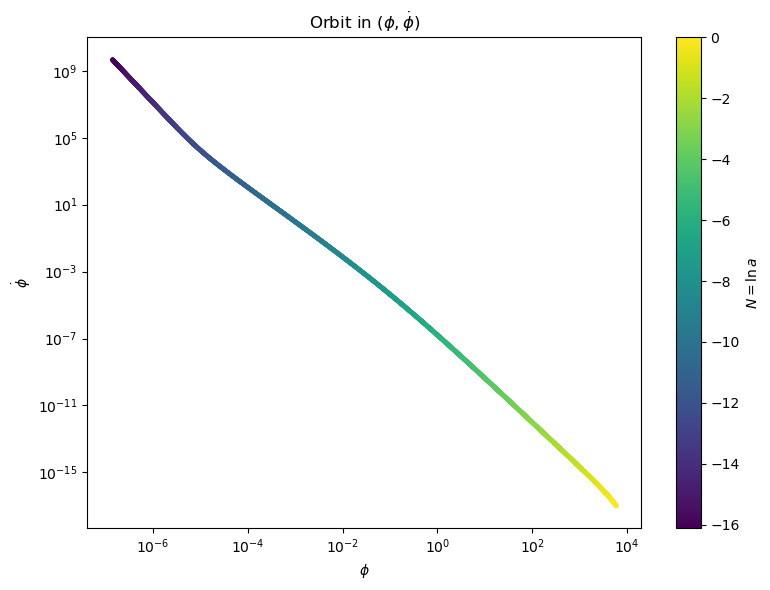

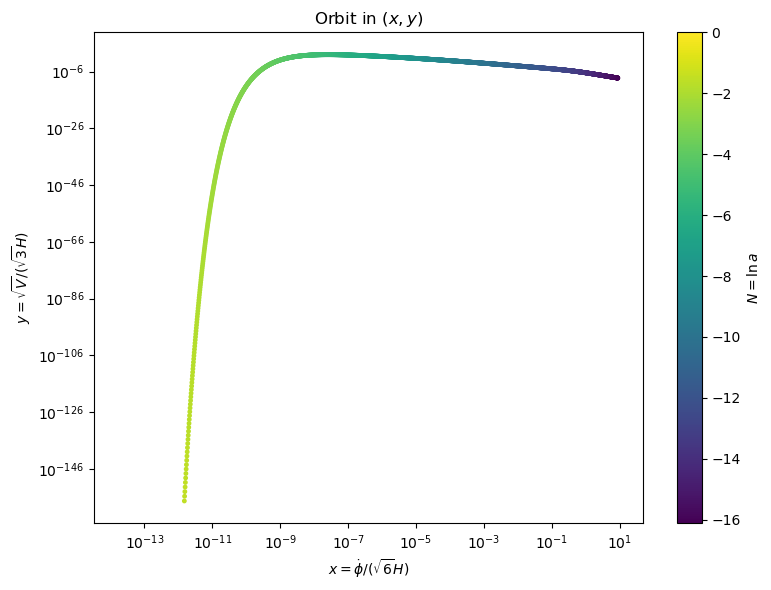

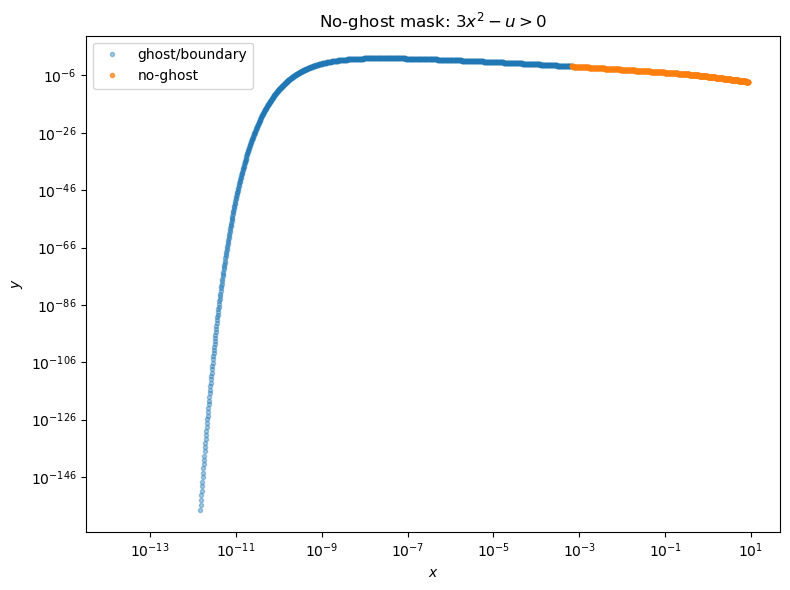

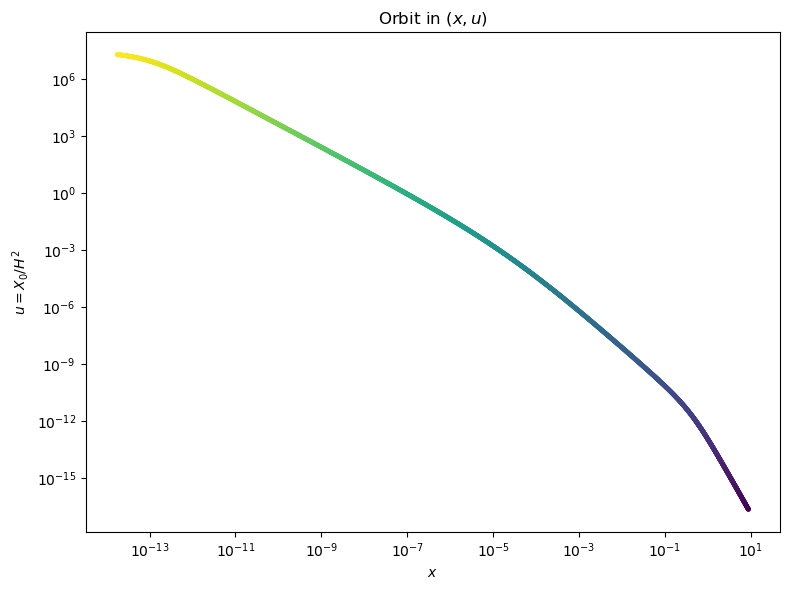

In [17]:
# =========================================
# Plots: phase trajectories
# =========================================
plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
sc = plt.scatter(phi, dotphi, c=N, s=6)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\dot\phi$')
cb = plt.colorbar(sc); cb.set_label(r'$N=\ln a$')
plt.title(r'Orbit in $(\phi,\dot\phi)$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
sc = plt.scatter(x, y, c=N, s=6)
plt.xlabel(r'$x=\dot\phi/(\sqrt{6} H)$')
plt.ylabel(r'$y=\sqrt{V}/(\sqrt{3} H)$')
cb = plt.colorbar(sc); cb.set_label(r'$N=\ln a$')
plt.title(r'Orbit in $(x,y)$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
plt.plot(x[~no_ghost], y[~no_ghost], '.', alpha=0.4, label='ghost/boundary')
plt.plot(x[no_ghost],  y[no_ghost],  '.', alpha=0.7, label='no-ghost')
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.legend()
plt.title(r'No-ghost mask: $3x^2-u>0$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(x, u, c=N, s=6)
plt.xlabel(r'$x$')
plt.ylabel(r'$u=X_0/H^2$')
plt.title(r'Orbit in $(x,u)$')
plt.tight_layout()
plt.show()

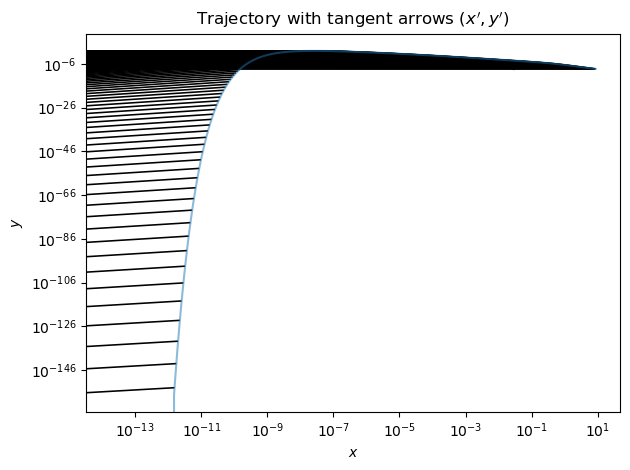

In [19]:
# (D) Quiver along the trajectory (numerical derivatives as arrows)
# Subsample for readability
step = max(1, len(x)//300)
plt.figure()
plt.yscale('log')
plt.xscale('log')

plt.plot(x, y, '-', alpha=0.5)
plt.quiver(
    x[::step], y[::step],
    xprime_num[::step], yprime_num[::step],
    angles='xy', scale_units='xy', scale=1.0, width=0.003
)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Trajectory with tangent arrows $(x^\prime,y^\prime)$ ')
plt.tight_layout()
plt.show()

In [5]:
rho_crit/3*H**2

array([7.14423981e+32, 6.75648265e+32, 6.38977126e+32, ...,
       9.64487715e-16, 9.52130971e-16, 9.40823567e-16])

In [4]:
M2_smg

array([1., 1., 1., ..., 1., 1., 1.])

aquí voy y todo bien 2
aquí voy y todo bien 2
aquí voy y todo bien 2.02167
aquí voy y todo bien 2.11016
aquí voy y todo bien 2.06591
aquí voy y todo bien 2.08008
aquí voy y todo bien 2.073
aquí voy y todo bien 2.08008


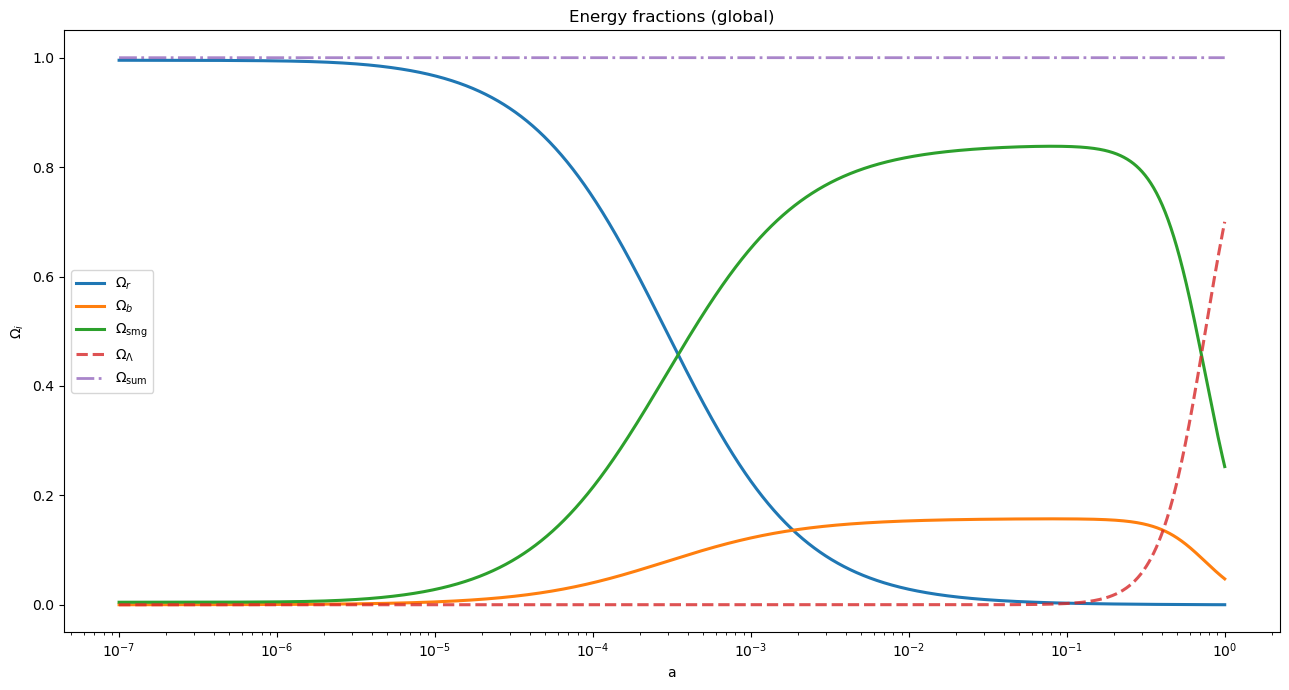

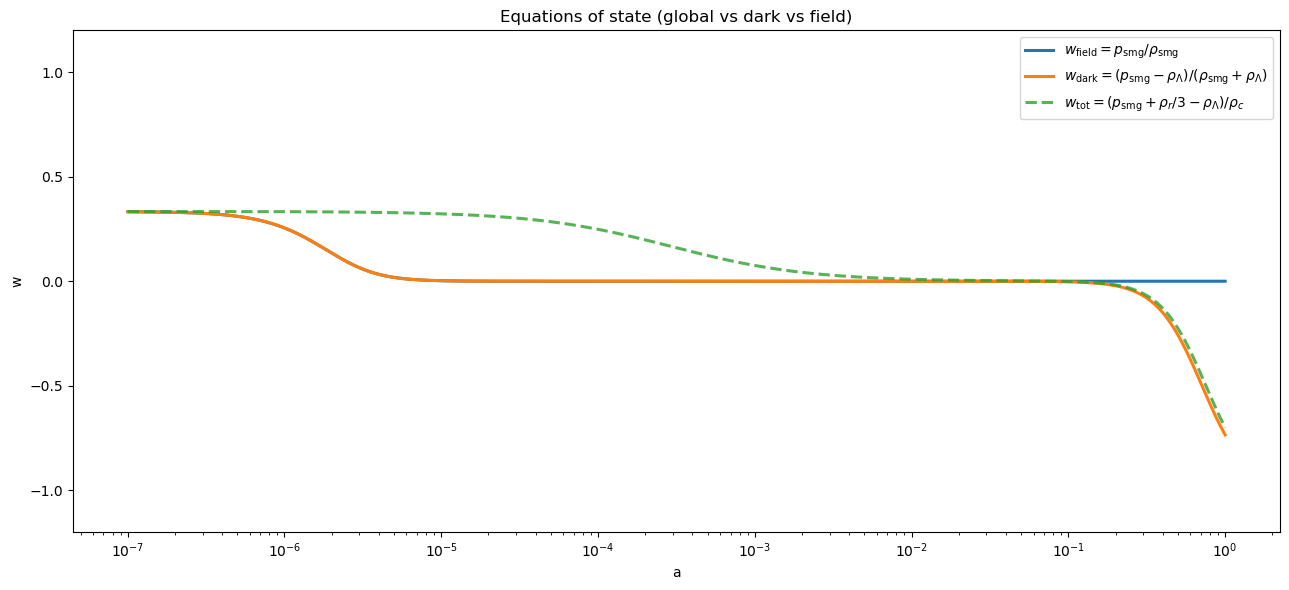

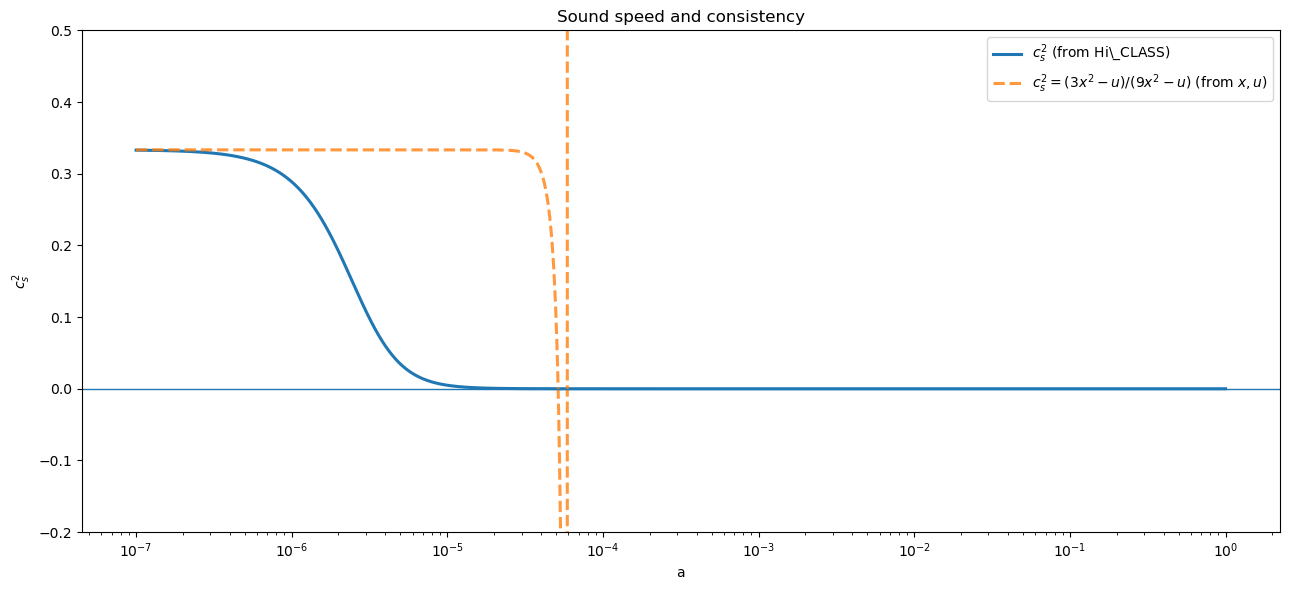

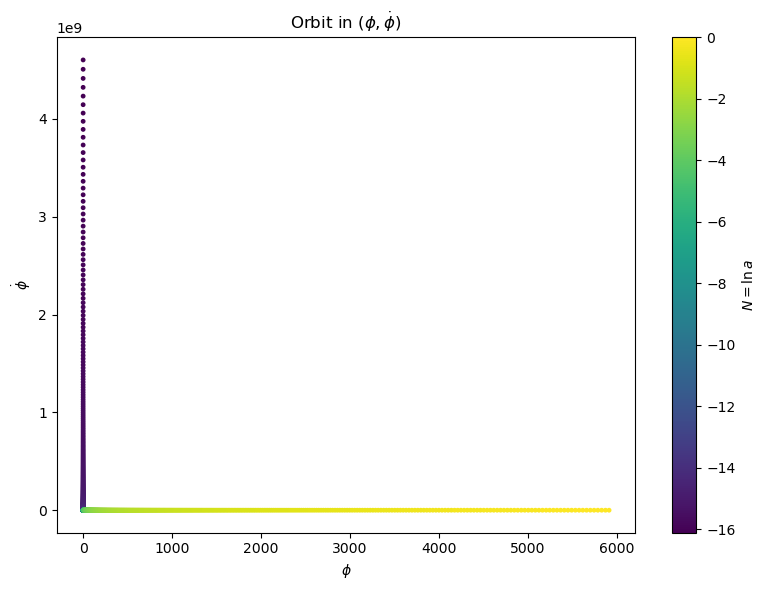

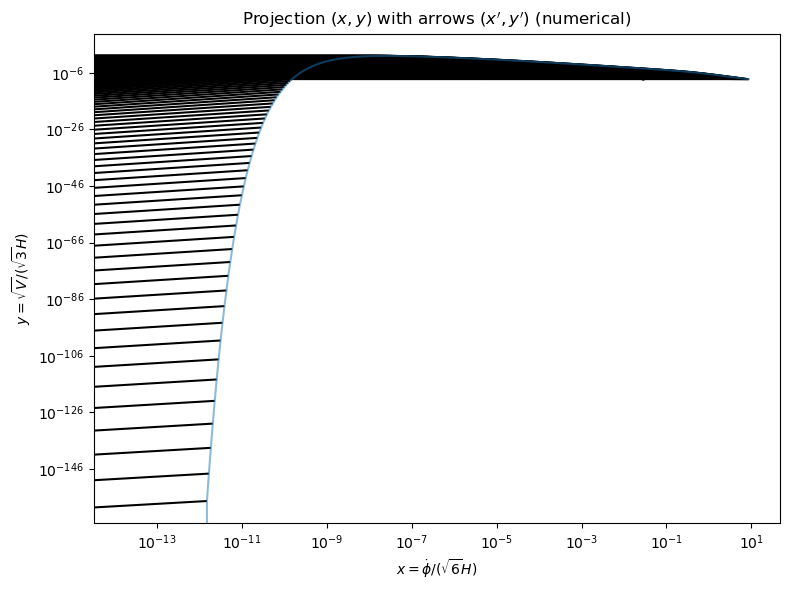

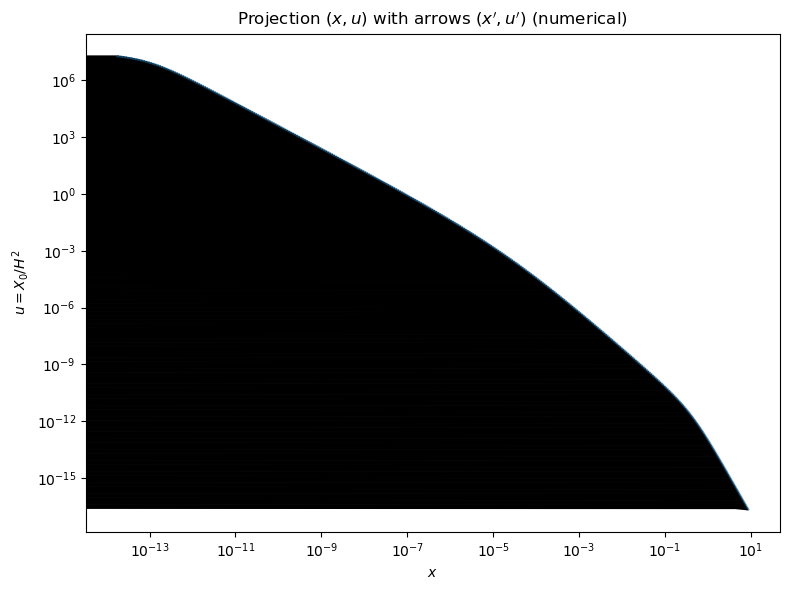

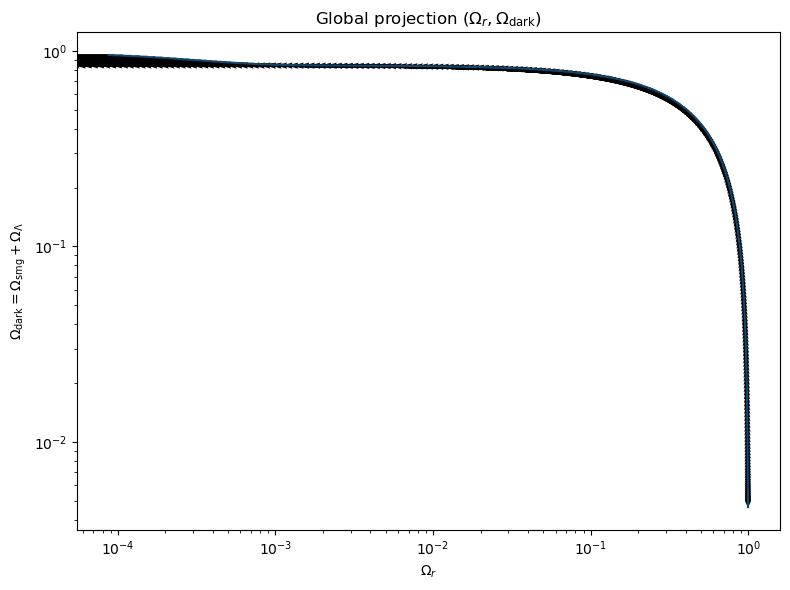

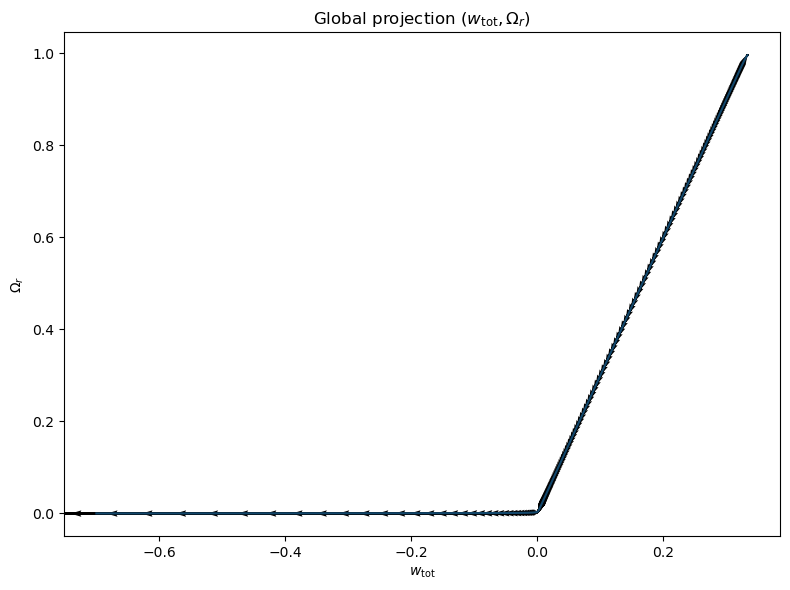

In [7]:
# ============================================================
# GLOBAL phase-space reconstruction from Hi_CLASS (ONE theta)
# Model: k-essence + Lambda + (standard rad + baryons)
# Potential: V(phi) = V0 * exp(-lambda * phi)
#
# Outputs:
#   - Trajectory projections (phase portraits) with arrows:
#       (phi, dotphi), (x,y), (x,u), (Omega_r, Omega_dark), (w_tot, Omega_r)
#   - Time evolution diagnostics: Omegas(a), w_field(a), w_dark(a), w_tot(a), c_s^2(a)
#
# Notes:
#   - Uses H from background['H [1/Mpc]'].
#   - Uses rho_lambda from background['(.)rho_lambda'] (your choice: F0=0 in code, Lambda explicit).
#   - For late-time "dark sector": Omega_dark = Omega_smg + Omega_Lambda.
#   - w_dark = (p_smg - rho_lambda)/(rho_smg + rho_lambda).
#   - w_tot  = (p_smg + rho_r/3 - rho_lambda)/rho_crit  (global, includes radiation).
#
# If your build stores phi' as dphi/dt instead of dphi/dtau:
#   set PHI_PRIME_IS_CONFORMAL=False below.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from classy import Class

# -----------------------
# 0) USER SETTINGS
# -----------------------
PHI_PRIME_IS_CONFORMAL = True  # True: phi' = dphi/dtau (CLASS usual). False: phi' = dphi/dt.

# choose one theta
theta = (1/3)*1e-17

# model parameters (consistent with your runs)
X0    = 1.0      # x0_schm = X_0
V0    = 4.32     # V0_schm
lamV  = 1.0      # lambda_schm (potential slope, NOT lambda_i outputs)
DM_sch = 0.26    # DM_schm
OmegaL = 0.70    # Omega_Lambda (explicit vacuum in CLASS)

# plot cuts
zmax = 1e7        # cut absurdly early times for plotting readability (optional)
arrow_max = 350   # max arrows in quiver plots

# -----------------------
# 1) RUN Hi_CLASS
# -----------------------
settings = {
    'output': 'mPk,tCl,pCl,lCl',
    'P_k_max_1/Mpc': 3.0,
    'k_output_values': '0.5',

    'h': 0.691,
    'omega_b': 0.0226,
    'Omega_cdm': 0,
    'Omega_Lambda': OmegaL,

    'Omega_fld': 0,
    'Omega_smg': -1,
    'gravity_model': 'quintessence_monomial',

    'x0_schm': X0,
    'theta_schm': theta,
    'DM_schm': DM_sch,
    'h_schm': 2,      # shooting parameter (ignored here)
    'V0_schm': V0,
    'lambda_schm': lamV,

    'A_s': 2.06e-9,
    'n_s': 0.972,
    'tau_reio': 0.0477,
    'lensing': 'yes',
    'compute damping scale': 'yes',
    'output_background_smg': 10,
}

cosmo = Class()
cosmo.set(settings)
cosmo.compute()
bg = cosmo.get_background()

# -----------------------
# 2) EXTRACT BACKGROUND
# -----------------------
z        = np.asarray(bg['z'])
a        = 1.0/(1.0+z)
N        = np.log(a)

H        = np.asarray(bg['H [1/Mpc]'])
phi      = np.asarray(bg['phi_smg'])
phi_p    = np.asarray(bg["phi'"])           # phi' output
cs2_bg   = np.asarray(bg['c_s^2']) if 'c_s^2' in bg else None

rho_g    = np.asarray(bg['(.)rho_g'])
rho_ur   = np.asarray(bg['(.)rho_ur'])
rho_r    = rho_g + rho_ur
rho_b    = np.asarray(bg['(.)rho_b'])
rho_lam  = np.asarray(bg['(.)rho_lambda'])
rho_crit = np.asarray(bg['(.)rho_crit'])

rho_smg  = np.asarray(bg['(.)rho_smg'])
p_smg    = np.asarray(bg['(.)p_smg'])

# order by a increasing
order = np.argsort(a)
z, a, N = z[order], a[order], N[order]
H, phi, phi_p = H[order], phi[order], phi_p[order]
rho_r, rho_b, rho_lam, rho_crit = rho_r[order], rho_b[order], rho_lam[order], rho_crit[order]
rho_smg, p_smg = rho_smg[order], p_smg[order]
if cs2_bg is not None:
    cs2_bg = cs2_bg[order]

# optional z-cut
m = (z <= zmax)
z, a, N = z[m], a[m], N[m]
H, phi, phi_p = H[m], phi[m], phi_p[m]
rho_r, rho_b, rho_lam, rho_crit = rho_r[m], rho_b[m], rho_lam[m], rho_crit[m]
rho_smg, p_smg = rho_smg[m], p_smg[m]
if cs2_bg is not None:
    cs2_bg = cs2_bg[m]

# -----------------------
# 3) RECONSTRUCT PHASE VARIABLES
# -----------------------
# dotphi from phi'
if PHI_PRIME_IS_CONFORMAL:
    dotphi = phi_p / a
else:
    dotphi = phi_p

X = 0.5*dotphi**2

# (x,u) as in your dynamical system
x = dotphi / (np.sqrt(6.0)*H)
u = X0 / (H**2)

# potential and y
V = V0 * np.exp(-lamV*phi)
y = np.sqrt(np.maximum(V, 0.0)) / (np.sqrt(3.0)*H)

# Omegas
Omega_r   = rho_r / rho_crit
Omega_b   = rho_b / rho_crit
Omega_L   = rho_lam / rho_crit
Omega_smg = rho_smg / rho_crit
Omega_dark = Omega_smg + Omega_L
Omega_sum  = Omega_r + Omega_b + Omega_smg + Omega_L

# equations of state
w_field = p_smg / rho_smg
w_dark  = (p_smg - rho_lam) / (rho_smg + rho_lam)              # your w_sch
w_tot   = (p_smg + rho_r/3.0 - rho_lam) / rho_crit             # global (controls H'/H)

# k-essence physical region diagnostics
Delta = 3.0*x**2 - u
no_ghost = (Delta > 0)
cs2_xu = (3.0*x**2 - u) / (9.0*x**2 - u)   # from your formula, may differ if conventions differ

# -----------------------
# 4) NUMERICAL DERIVATIVES w.r.t. N (for arrows)
# -----------------------
def d_by_dN(q, N):
    return np.gradient(q, N)

xN  = d_by_dN(x, N)
yN  = d_by_dN(y, N)
uN  = d_by_dN(u, N)
OmrN = d_by_dN(Omega_r, N)
OmdN = d_by_dN(Omega_dark, N)
wN  = d_by_dN(w_tot, N)

# subsample for quiver readability
def quiver_subsample(xx, yy, ux, vy, max_arrows=300):
    n = len(xx)
    step = max(1, n // max_arrows)
    return xx[::step], yy[::step], ux[::step], vy[::step]

# -----------------------
# 5) PLOTS
# -----------------------
# (A) Friedmann closure / components
plt.figure(figsize=(13,7))
plt.xscale('log')
plt.plot(a, Omega_r,   lw=2.2, label=r'$\Omega_r$')
plt.plot(a, Omega_b,   lw=2.2, label=r'$\Omega_b$')
plt.plot(a, Omega_smg, lw=2.2, label=r'$\Omega_{\rm smg}$')
plt.plot(a, Omega_L,   lw=2.2, ls='--', alpha=0.8, label=r'$\Omega_\Lambda$')
plt.plot(a, Omega_sum, lw=2.0, ls='-.', alpha=0.8, label=r'$\Omega_{\rm sum}$')
plt.ylim(-0.05, 1.05)
plt.xlabel('a'); plt.ylabel(r'$\Omega_i$')
plt.legend()
plt.title('Energy fractions (global)')
plt.tight_layout()
plt.show()

# (B) EOS diagnostics
plt.figure(figsize=(13,6))
plt.xscale('log')
plt.plot(a, w_field, lw=2.2, label=r'$w_{\rm field}=p_{\rm smg}/\rho_{\rm smg}$')
plt.plot(a, w_dark,  lw=2.2, label=r'$w_{\rm dark}=(p_{\rm smg}-\rho_\Lambda)/(\rho_{\rm smg}+\rho_\Lambda)$')
plt.plot(a, w_tot,   lw=2.2, ls='--', alpha=0.8, label=r'$w_{\rm tot}=(p_{\rm smg}+\rho_r/3-\rho_\Lambda)/\rho_c$')
plt.ylim(-1.2, 1.2)
plt.xlabel('a'); plt.ylabel('w')
plt.legend()
plt.title('Equations of state (global vs dark vs field)')
plt.tight_layout()
plt.show()

# (C) c_s^2 vs a and ghost diagnostic
plt.figure(figsize=(13,6))
plt.xscale('log')
if cs2_bg is not None:
    plt.plot(a, cs2_bg, lw=2.2, label=r'$c_s^2$ (from Hi\_CLASS)')
plt.plot(a, cs2_xu, lw=2.2, ls='--', alpha=0.8, label=r'$c_s^2=(3x^2-u)/(9x^2-u)$ (from $x,u$)')
plt.axhline(0.0, lw=1.0)
plt.ylim(-0.2, 0.5)
plt.xlabel('a'); plt.ylabel(r'$c_s^2$')
plt.legend()
plt.title('Sound speed and consistency')
plt.tight_layout()
plt.show()

# (D) Phase portrait: (phi, dotphi) colored by N
plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
sc = plt.scatter(phi, dotphi, c=N, s=6)
plt.xlabel(r'$\phi$'); plt.ylabel(r'$\dot\phi$')
cb = plt.colorbar(sc); cb.set_label(r'$N=\ln a$')
plt.title(r'Orbit in $(\phi,\dot\phi)$')
plt.tight_layout()
plt.show()

# (E) Phase portrait: (x, y) with tangent arrows (data-derived)
plt.figure(figsize=(8,6))
plt.plot(x, y, '-', alpha=0.5)
xx, yy, ux, vy = quiver_subsample(x, y, xN, yN, max_arrows=arrow_max)
plt.quiver(xx, yy, ux, vy, angles='xy', scale_units='xy', scale=1.0, width=0.003)
plt.xlabel(r'$x=\dot\phi/(\sqrt{6} H)$')
plt.ylabel(r'$y=\sqrt{V}/(\sqrt{3}H)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'Projection $(x,y)$ with arrows $(x^\prime,y^\prime)$ (numerical)')
plt.tight_layout()
plt.show()

# (F) Recommended global projection: (x, u) (since u controls ghost boundary and cs2)
plt.figure(figsize=(8,6))
plt.plot(x, u, '-', alpha=0.5)
xx, yy, ux, vy = quiver_subsample(x, u, xN, uN, max_arrows=arrow_max)
plt.quiver(xx, yy, ux, vy, angles='xy', scale_units='xy', scale=1.0, width=0.003)
plt.xlabel(r'$x$')
plt.ylabel(r'$u=X_0/H^2$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'Projection $(x,u)$ with arrows $(x^\prime,u^\prime)$ (numerical)')
plt.tight_layout()
plt.show()

# (G) Global-epoch portrait: (Omega_r, Omega_dark) with arrows
plt.figure(figsize=(8,6))
plt.plot(Omega_r, Omega_dark, '-', alpha=0.6)
xx, yy, ux, vy = quiver_subsample(Omega_r, Omega_dark, OmrN, OmdN, max_arrows=arrow_max)
plt.quiver(xx, yy, ux, vy, angles='xy', scale_units='xy', scale=1.0, width=0.003)
plt.xlabel(r'$\Omega_r$')
plt.ylabel(r'$\Omega_{\rm dark}=\Omega_{\rm smg}+\Omega_\Lambda$')
plt.title(r'Global projection $(\Omega_r,\Omega_{\rm dark})$')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.show()

# (H) Another global diagnostic portrait: (w_tot, Omega_r) with arrows
plt.figure(figsize=(8,6))
plt.plot(w_tot, Omega_r, '-', alpha=0.6)
xx, yy, ux, vy = quiver_subsample(w_tot, Omega_r, wN, OmrN, max_arrows=arrow_max)
plt.quiver(xx, yy, ux, vy, angles='xy', scale_units='xy', scale=1.0, width=0.003)
plt.xlabel(r'$w_{\rm tot}$')
plt.ylabel(r'$\Omega_r$')
plt.title(r'Global projection $(w_{\rm tot},\Omega_r)$')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.show()

# cleanup
cosmo.struct_cleanup()


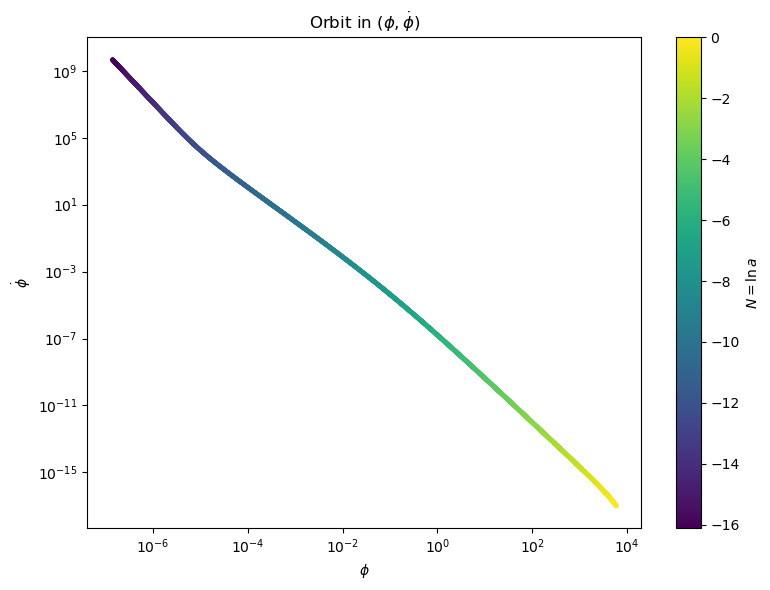

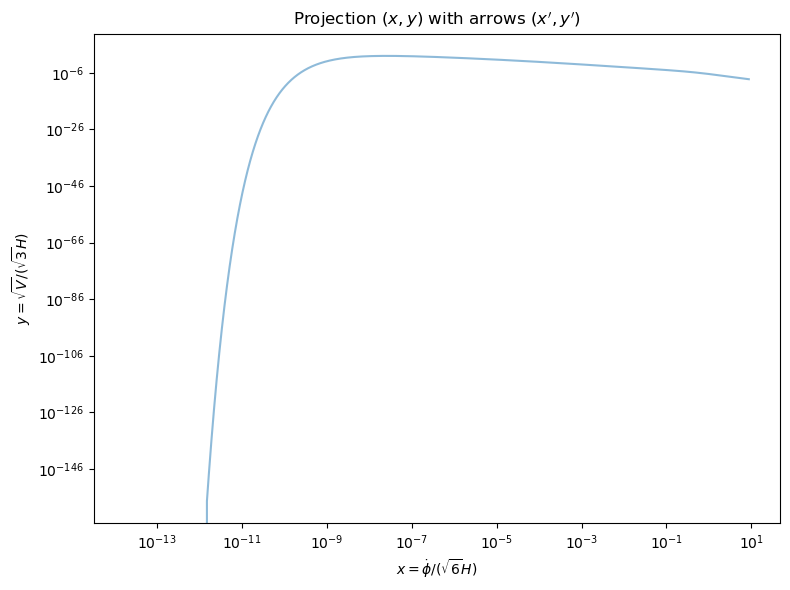

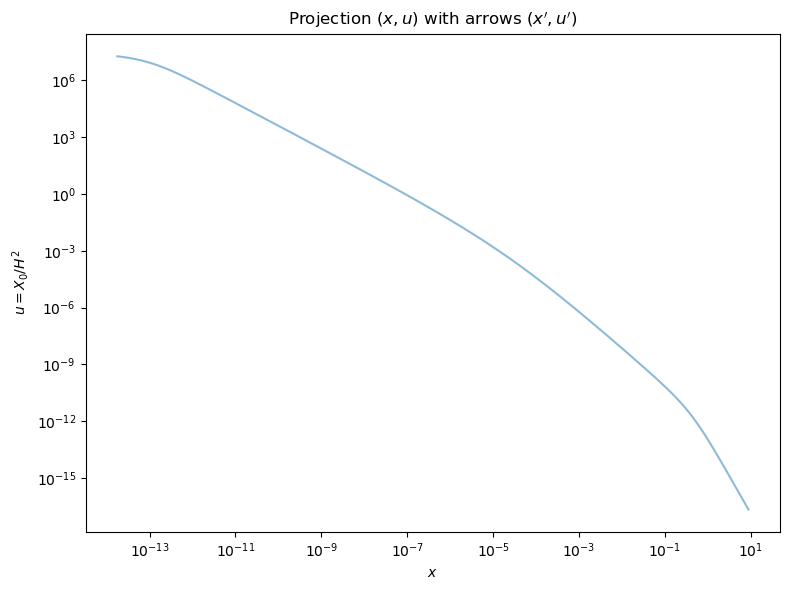

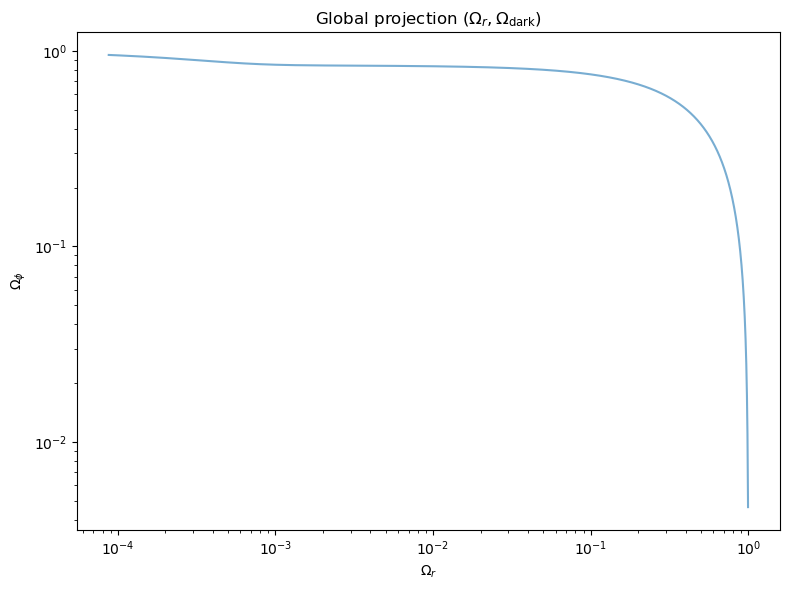

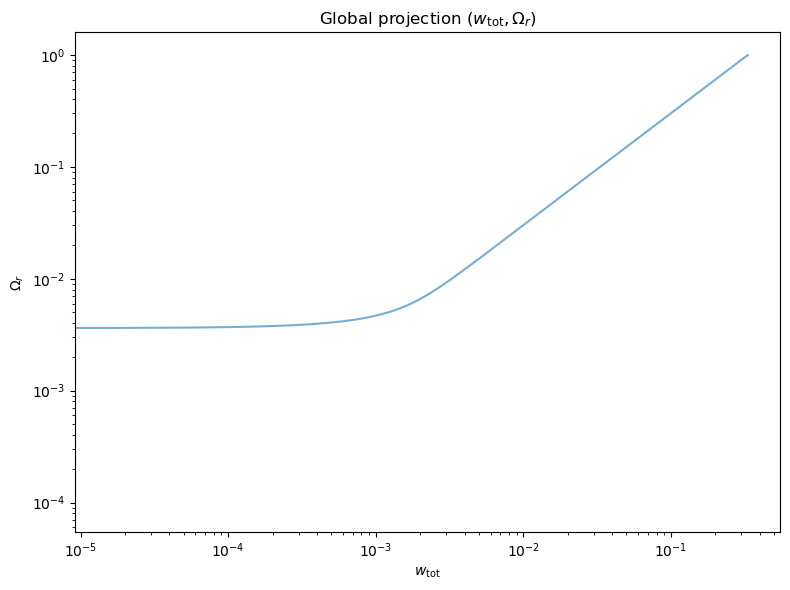

In [18]:




# (D) Phase portrait: (phi, dotphi) colored by N
plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
sc = plt.scatter(phi, dotphi, c=N, s=6)
plt.xlabel(r'$\phi$'); plt.ylabel(r'$\dot\phi$')
cb = plt.colorbar(sc); cb.set_label(r'$N=\ln a$')
plt.title(r'Orbit in $(\phi,\dot\phi)$')
plt.tight_layout()
plt.show()

# (E) Phase portrait: (x, y) with tangent arrows (data-derived)
plt.figure(figsize=(8,6))
plt.plot(x, y, '-', alpha=0.5)
#xx, yy, ux, vy = quiver_subsample(x, y, xN, yN, max_arrows=arrow_max)
#plt.quiver(xx, yy, ux, vy, angles='xy', scale_units='xy', scale=1.0, width=0.003)
plt.xlabel(r'$x=\dot\phi/(\sqrt{6} H)$')
plt.ylabel(r'$y=\sqrt{V}/(\sqrt{3}H)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'Projection $(x,y)$ with arrows $(x^\prime,y^\prime)$')
plt.tight_layout()
plt.show()

# (F) Recommended global projection: (x, u) (since u controls ghost boundary and cs2)
plt.figure(figsize=(8,6))
plt.plot(x, u, '-', alpha=0.5)
#xx, yy, ux, vy = quiver_subsample(x, u, xN, uN, max_arrows=arrow_max)
#plt.quiver(xx, yy, ux, vy, angles='xy', scale_units='xy', scale=1.0, width=0.003)
plt.xlabel(r'$x$')
plt.ylabel(r'$u=X_0/H^2$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'Projection $(x,u)$ with arrows $(x^\prime,u^\prime)$')
plt.tight_layout()
plt.show()

# (G) Global-epoch portrait: (Omega_r, Omega_dark) with arrows
plt.figure(figsize=(8,6))
plt.plot(Omega_r, Omega_dark, '-', alpha=0.6)
#xx, yy, ux, vy = quiver_subsample(Omega_r, Omega_dark, OmrN, OmdN, max_arrows=arrow_max)
#plt.quiver(xx, yy, ux, vy, angles='xy', scale_units='xy', scale=1.0, width=0.003)
plt.xlabel(r'$\Omega_r$')
plt.ylabel(r'$\Omega_{\phi}$')
plt.title(r'Global projection $(\Omega_r,\Omega_{\rm dark})$')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.show()

# (H) Another global diagnostic portrait: (w_tot, Omega_r) with arrows
plt.figure(figsize=(8,6))
plt.plot(w_tot, Omega_r, '-', alpha=0.6)
#xx, yy, ux, vy = quiver_subsample(w_tot, Omega_r, wN, OmrN, max_arrows=arrow_max)
#plt.quiver(xx, yy, ux, vy, angles='xy', scale_units='xy', scale=1.0, width=0.003)
plt.xlabel(r'$w_{\rm tot}$')
plt.ylabel(r'$\Omega_r$')
plt.title(r'Global projection $(w_{\rm tot},\Omega_r)$')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.show()


aquí voy y todo bien 2
aquí voy y todo bien 2
aquí voy y todo bien 2.02167
aquí voy y todo bien 2.11016
aquí voy y todo bien 2.06591
aquí voy y todo bien 2.08008
aquí voy y todo bien 2.073
aquí voy y todo bien 2.08008


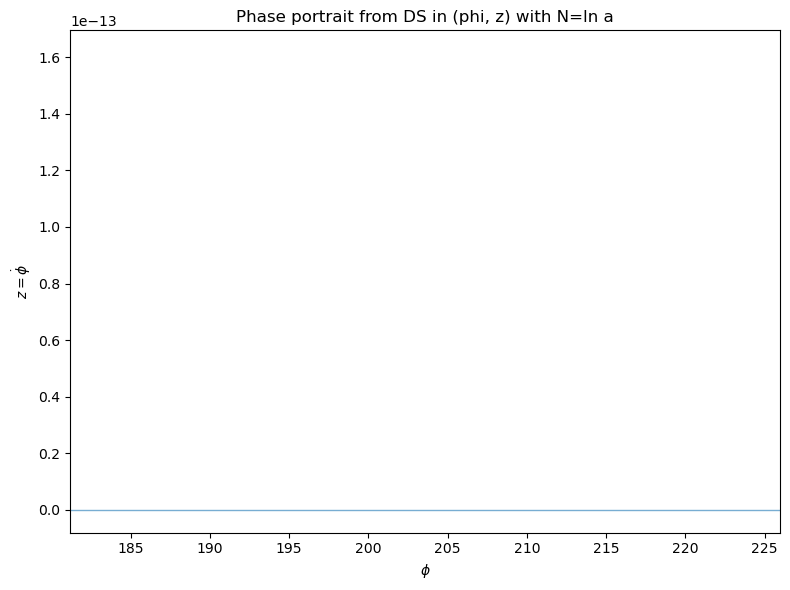

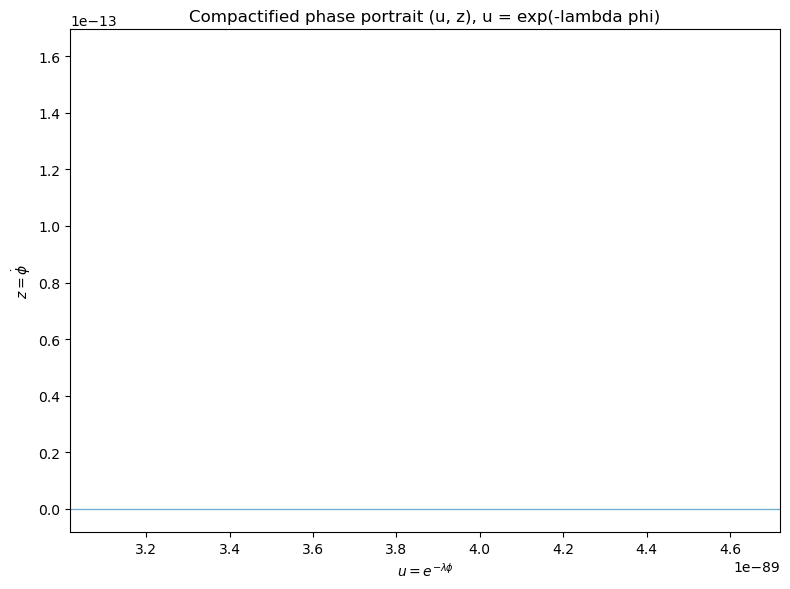

In [19]:
#!/usr/bin/env python3
# ============================================================
# Phase portraits from the dynamical system (phi,z) or (u,z) with N=ln a
# using Hi_CLASS only to (optionally) extract consistent parameters/units.
#
# Model:
#   L(X,phi) = F(X) - V(phi),
#   F(X) = -F0 + F2 (X - X0)^2,      X = 1/2 * dotphi^2,     z := dotphi
#
# Dynamical system in N=ln a (cosmic time derivative in z):
#   phi' = z / H
#   z'   = -3 z (z^2 - 2 X0)/(3 z^2 - 2 X0) - V_phi/(F2 H (3 z^2 - 2 X0))
#
# Compactified exponential (u = exp(-lambda phi), V = V0 u):
#   u' = -lambda * u * z / H
#   z' = -3 z (z^2 - 2 X0)/(3 z^2 - 2 X0) + lambda V0 u/(F2 H (3 z^2 - 2 X0))
#
# Friedmann closure (CLASS-consistent):
#   3 Mpl^2 H^2 = rho_tot
# We infer Mpl^2 from CLASS outputs: rho_crit0 = 3 Mpl^2 H0^2
# so Mpl^2 = rho_crit0/(3 H0^2), ensuring unit consistency.
#
# Optional: include standard fluids in rho_tot using today’s densities from CLASS:
#   rho_r(N)=rho_r0 * e^{-4N}, rho_b(N)=rho_b0 * e^{-3N}, rho_Lambda=const.
# This makes the 2D system explicitly N-dependent, but still integrable.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

try:
    from scipy.integrate import solve_ivp
except ImportError as e:
    raise ImportError("This script needs SciPy (solve_ivp). Install scipy and retry.") from e


# -----------------------
# 0) Hi_CLASS helpers
# -----------------------
def run_hiclass_background(settings, verbose=False):
    """
    Run Hi_CLASS/CLASS and return background dict.
    Requires: pip install classy (and a working Hi_CLASS build).
    """
    from classy import Class
    cosmo = Class()
    cosmo.set(settings)
    cosmo.compute()
    bg = cosmo.get_background()
    if not verbose:
        cosmo.struct_cleanup()
    return bg


def extract_today_quantities(bg):
    """Extract (H0, rho_crit0, rho_b0, rho_r0, rho_lambda0) at z~0 from CLASS bg."""
    z = np.asarray(bg["z"])
    idx0 = int(np.argmin(np.abs(z)))  # closest to z=0
    H0 = float(np.asarray(bg["H [1/Mpc]"])[idx0])

    rho_crit0 = float(np.asarray(bg["(.)rho_crit"])[idx0])

    rho_b0 = float(np.asarray(bg["(.)rho_b"])[idx0])
    rho_g0 = float(np.asarray(bg["(.)rho_g"])[idx0])
    rho_ur0 = float(np.asarray(bg["(.)rho_ur"])[idx0])
    rho_r0 = rho_g0 + rho_ur0

    rho_lambda0 = float(np.asarray(bg["(.)rho_lambda"])[idx0]) if "(.)rho_lambda" in bg else 0.0

    return H0, rho_crit0, rho_b0, rho_r0, rho_lambda0


def extract_ic_from_bg(bg, z_init=10.0, phi_prime_is_conformal=True):
    """
    Use CLASS bg to get initial conditions at a given redshift z_init.
    Returns (N_init, phi_init, z_init_dotphi).
    """
    z_arr = np.asarray(bg["z"])
    a_arr = 1.0 / (1.0 + z_arr)
    N_arr = np.log(a_arr)

    # pick closest point to z_init
    idx = int(np.argmin(np.abs(z_arr - z_init)))

    phi = float(np.asarray(bg["phi_smg"])[idx])
    phi_p = float(np.asarray(bg["phi'"])[idx])  # CLASS convention depends on model/build

    a = float(a_arr[idx])
    if phi_prime_is_conformal:
        dotphi = phi_p / a
    else:
        dotphi = phi_p

    N_init = float(N_arr[idx])
    return N_init, phi, dotphi


# -----------------------
# 1) Model: rho_phi, p_phi, potentials
# -----------------------
def rho_p_phi(phi, z, F0, F2, X0, V, include_F0=True):
    """
    Scalar energy density:
      rho = 2X F_X - F + V, with F(X)=-F0 + F2 (X-X0)^2.
    In terms of z=dotphi and X=1/2 z^2:
      rho = (3/4)F2 z^4 - F2 X0 z^2 + (F0 - F2 X0^2) + V(phi).
    If include_F0=False, treat F0=0 inside F(X) and handle Lambda separately.
    """
    X = 0.5 * z**2
    const = (F0 - F2 * X0**2) if include_F0 else (-F2 * X0**2)
    return 3.0 * F2 * X**2 - 2.0 * F2 * X0 * X + const + V


def p_phi(phi, z, F0, F2, X0, V, include_F0=True):
    """
    Scalar pressure p = F(X) - V, F(X)=-F0+F2(X-X0)^2.
    """
    X = 0.5 * z**2
    F = (-F0 if include_F0 else 0.0) + F2 * (X - X0)**2
    return F - V


def potential(phi, kind, V0=0.0, lam=1.0, m=1.0):
    """
    Returns (V(phi), dV/dphi).
    kind: "none", "exp", "quad"
    """
    if kind == "none":
        return 0.0, 0.0
    if kind == "exp":
        V = V0 * np.exp(-lam * phi)
        dV = -lam * V
        return V, dV
    if kind == "quad":
        V = 0.5 * m**2 * phi**2
        dV = m**2 * phi
        return V, dV
    raise ValueError(f"Unknown potential kind: {kind}")


# -----------------------
# 2) Hubble closure (CLASS-consistent)
# -----------------------
def mpl2_from_class(H0, rho_crit0):
    # By definition in CLASS outputs: rho_crit0 = 3 * Mpl^2 * H0^2
    return rho_crit0 / (3.0 * H0**2)


def rho_fluids(N, rho_r0=0.0, rho_b0=0.0, rho_lambda0=0.0):
    a = np.exp(N)
    rr = rho_r0 * a**(-4.0)
    rb = rho_b0 * a**(-3.0)
    rl = rho_lambda0
    return rr, rb, rl


def hubble_from_rho(rho_tot, Mpl2):
    if rho_tot <= 0.0:
        return np.nan
    return np.sqrt(rho_tot / (3.0 * Mpl2))


# -----------------------
# 3) RHS: system in (phi,z) and compactified (u,z)
# -----------------------
def rhs_phi_z(N, y, pars):
    """
    y = [phi, z], z = dotphi.
    """
    phi, z = y
    X0 = pars["X0"]
    F0 = pars["F0"]
    F2 = pars["F2"]
    Mpl2 = pars["Mpl2"]

    pot_kind = pars["pot_kind"]
    V0 = pars.get("V0", 0.0)
    lam = pars.get("lam", 1.0)
    m = pars.get("m", 1.0)

    include_F0 = pars.get("include_F0_in_F", True)

    # optional fluids
    include_fluids = pars.get("include_fluids", False)
    rho_r0 = pars.get("rho_r0", 0.0)
    rho_b0 = pars.get("rho_b0", 0.0)
    rho_lambda0 = pars.get("rho_lambda0", 0.0)

    V, Vphi = potential(phi, pot_kind, V0=V0, lam=lam, m=m)

    rho_phi_val = rho_p_phi(phi, z, F0, F2, X0, V, include_F0=include_F0)
    p_phi_val = p_phi(phi, z, F0, F2, X0, V, include_F0=include_F0)

    rr, rb, rl = (0.0, 0.0, 0.0)
    pr = 0.0
    if include_fluids:
        rr, rb, rl = rho_fluids(N, rho_r0=rho_r0, rho_b0=rho_b0, rho_lambda0=rho_lambda0)
        pr = rr / 3.0

    rho_tot = rho_phi_val + rr + rb + rl
    H = hubble_from_rho(rho_tot, Mpl2)

    D = 3.0 * z**2 - 2.0 * X0
    if (not np.isfinite(H)) or (H <= 0.0) or (np.abs(D) < pars.get("D_eps", 1e-14)):
        # stop dynamics in invalid region (solver event should catch it; this is a safe fallback)
        return [0.0, 0.0]

    phiN = z / H
    zN = -3.0 * z * (z**2 - 2.0 * X0) / D - Vphi / (F2 * H * D)

    return [phiN, zN]


def rhs_u_z(N, y, pars):
    """
    Compactified exponential: u = exp(-lam phi), V=V0 u, V_phi = -lam V0 u.
    y = [u, z]
    """
    u, z = y
    X0 = pars["X0"]
    F0 = pars["F0"]
    F2 = pars["F2"]
    Mpl2 = pars["Mpl2"]

    V0 = pars["V0"]
    lam = pars["lam"]
    include_F0 = pars.get("include_F0_in_F", True)

    include_fluids = pars.get("include_fluids", False)
    rho_r0 = pars.get("rho_r0", 0.0)
    rho_b0 = pars.get("rho_b0", 0.0)
    rho_lambda0 = pars.get("rho_lambda0", 0.0)

    # enforce u >= 0 numerically
    u = max(u, 0.0)

    V = V0 * u
    # in the u-formulation, the KG source term becomes + lam V0 u /(...)
    # (because V_phi = -lam V0 u enters with a minus sign in z')
    rho_phi_val = rho_p_phi(phi=np.nan, z=z, F0=F0, F2=F2, X0=X0, V=V, include_F0=include_F0)

    rr, rb, rl = (0.0, 0.0, 0.0)
    if include_fluids:
        rr, rb, rl = rho_fluids(N, rho_r0=rho_r0, rho_b0=rho_b0, rho_lambda0=rho_lambda0)

    rho_tot = rho_phi_val + rr + rb + rl
    H = hubble_from_rho(rho_tot, Mpl2)

    D = 3.0 * z**2 - 2.0 * X0
    if (not np.isfinite(H)) or (H <= 0.0) or (np.abs(D) < pars.get("D_eps", 1e-14)):
        return [0.0, 0.0]

    uN = -lam * u * z / H
    zN = -3.0 * z * (z**2 - 2.0 * X0) / D + (lam * V0 * u) / (F2 * H * D)
    return [uN, zN]


# -----------------------
# 4) Events (stop integration near singularities / invalid rho)
# -----------------------
def event_D_zero(N, y, pars, mode="phi"):
    z = y[1]
    return np.abs(3.0 * z**2 - 2.0 * pars["X0"]) - pars.get("D_stop", 1e-10)
event_D_zero.terminal = True
event_D_zero.direction = -1


def event_rho_nonpositive(N, y, pars, mode="phi"):
    if mode == "phi":
        phi, z = y
        V, _ = potential(phi, pars["pot_kind"], V0=pars.get("V0", 0.0), lam=pars.get("lam", 1.0), m=pars.get("m", 1.0))
    else:
        u, z = y
        V = pars["V0"] * max(u, 0.0)

    rho_phi_val = rho_p_phi(
        phi=np.nan, z=z, F0=pars["F0"], F2=pars["F2"], X0=pars["X0"], V=V,
        include_F0=pars.get("include_F0_in_F", True)
    )

    rr = rb = rl = 0.0
    if pars.get("include_fluids", False):
        rr, rb, rl = rho_fluids(N, rho_r0=pars.get("rho_r0", 0.0), rho_b0=pars.get("rho_b0", 0.0), rho_lambda0=pars.get("rho_lambda0", 0.0))

    rho_tot = rho_phi_val + rr + rb + rl
    return rho_tot - pars.get("rho_stop", 1e-14)
event_rho_nonpositive.terminal = True
event_rho_nonpositive.direction = -1


# -----------------------
# 5) Phase portrait plotting
# -----------------------
def vector_field_grid_phi_z(ax, pars, phi_range, z_range, nphi=80, nz=80, N_fix=0.0):
    """
    Vector field for autonomous (phi,z) system.
    If include_fluids=True, the field depends on N; we freeze it at N=N_fix for visualization.
    """
    phis = np.linspace(phi_range[0], phi_range[1], nphi)
    zs = np.linspace(z_range[0], z_range[1], nz)
    PHI, Z = np.meshgrid(phis, zs)

    U = np.zeros_like(PHI)
    W = np.zeros_like(PHI)

    for i in range(nz):
        for j in range(nphi):
            d = rhs_phi_z(N_fix, [PHI[i, j], Z[i, j]], pars)
            U[i, j] = d[0]
            W[i, j] = d[1]

    # mask invalid zeros (from guard)
    speed = np.sqrt(U**2 + W**2)
    U = np.ma.masked_where(speed == 0.0, U)
    W = np.ma.masked_where(speed == 0.0, W)

    ax.streamplot(PHI, Z, U, W, density=1.2, linewidth=0.8, arrowsize=1.0)


def vector_field_grid_u_z(ax, pars, u_range, z_range, nu=80, nz=80, N_fix=0.0):
    us = np.linspace(u_range[0], u_range[1], nu)
    zs = np.linspace(z_range[0], z_range[1], nz)
    UVAR, Z = np.meshgrid(us, zs)

    U = np.zeros_like(UVAR)  # u'
    W = np.zeros_like(UVAR)  # z'

    for i in range(nz):
        for j in range(nu):
            d = rhs_u_z(N_fix, [UVAR[i, j], Z[i, j]], pars)
            U[i, j] = d[0]
            W[i, j] = d[1]

    speed = np.sqrt(U**2 + W**2)
    U = np.ma.masked_where(speed == 0.0, U)
    W = np.ma.masked_where(speed == 0.0, W)

    ax.streamplot(UVAR, Z, U, W, density=1.2, linewidth=0.8, arrowsize=1.0)


def integrate_and_plot(pars, mode="phi", y0_list=None, N_span=(-8.0, 0.0), n_eval=2000,
                       show_field=True, field_ranges=None, N_fix_for_field=0.0, title=""):
    """
    mode: "phi" or "u"
    y0_list: list of initial conditions [ [phi0,z0], ... ] or [ [u0,z0], ... ]
    """
    if y0_list is None:
        raise ValueError("Provide y0_list with initial conditions.")

    N_eval = np.linspace(N_span[0], N_span[1], n_eval)

    fig, ax = plt.subplots(figsize=(8, 6))

    if show_field and field_ranges is not None:
        if mode == "phi":
            vector_field_grid_phi_z(ax, pars, field_ranges["phi"], field_ranges["z"], N_fix=N_fix_for_field)
            ax.set_xlabel(r"$\phi$")
        else:
            vector_field_grid_u_z(ax, pars, field_ranges["u"], field_ranges["z"], N_fix=N_fix_for_field)
            ax.set_xlabel(r"$u=e^{-\lambda\phi}$")

    ax.set_ylabel(r"$z=\dot\phi$")

    for y0 in y0_list:
        if mode == "phi":
            sol = solve_ivp(
                fun=lambda N, y: rhs_phi_z(N, y, pars),
                t_span=N_span, y0=y0, t_eval=N_eval,
                events=[
                    lambda N, y: event_D_zero(N, y, pars, mode="phi"),
                    lambda N, y: event_rho_nonpositive(N, y, pars, mode="phi"),
                ],
                rtol=1e-8, atol=1e-10, method="RK45"
            )
            ax.plot(sol.y[0], sol.y[1], lw=2.0)
        else:
            sol = solve_ivp(
                fun=lambda N, y: rhs_u_z(N, y, pars),
                t_span=N_span, y0=y0, t_eval=N_eval,
                events=[
                    lambda N, y: event_D_zero(N, y, pars, mode="u"),
                    lambda N, y: event_rho_nonpositive(N, y, pars, mode="u"),
                ],
                rtol=1e-8, atol=1e-10, method="RK45"
            )
            ax.plot(sol.y[0], sol.y[1], lw=2.0)

    ax.set_title(title)
    ax.axhline(0.0, lw=1.0, alpha=0.6)
    plt.tight_layout()
    plt.show()


# -----------------------
# 6) Example main (adjust to your run)
# -----------------------
if __name__ == "__main__":
    # --- Hi_CLASS settings (minimal changes vs your example) ---
    PHI_PRIME_IS_CONFORMAL = True

    theta = (1/3)*1e-17
    X0    = 1.0
    V0    = 4.32
    lamV  = 1.0
    DM_sch = 0.26
    OmegaL = 0.70

    settings = {
        "output": "mPk",
        "P_k_max_1/Mpc": 1.0,
        "k_output_values": "0.5",

        "h": 0.691,
        "omega_b": 0.0226,
        "Omega_cdm": 0.0,
        "Omega_Lambda": OmegaL,

        "Omega_fld": 0.0,
        "Omega_smg": -1.0,
        "gravity_model": "quintessence_monomial",

        "x0_schm": X0,
        "theta_schm": theta,
        "DM_schm": DM_sch,
        "h_schm": 2,
        "V0_schm": V0,
        "lambda_schm": lamV,

        "A_s": 2.06e-9,
        "n_s": 0.972,
        "tau_reio": 0.0477,
        "lensing": "no",
        "output_background_smg": 10,
    }

    # --- run Hi_CLASS and extract consistent unit factors ---
    bg = run_hiclass_background(settings)
    H0, rho_crit0, rho_b0, rho_r0, rho_lambda0 = extract_today_quantities(bg)
    Mpl2 = mpl2_from_class(H0, rho_crit0)

    # --- build DS parameters ---
    # Choose whether the cosmological constant is encoded as F0 in F(X), or as explicit rho_lambda0:
    LAMBDA_AS_F0 = True  # set False if you want to keep CLASS rho_lambda0 as explicit vacuum

    # Omega_b0 from CLASS (preferred over omega_b/h^2 when you have bg):
    Omega_b0 = rho_b0 / rho_crit0

    # Your Scherrer-inspired formula for F2 (same units as rho_crit0):
    # Omega_m0 used here = Omega_b0 + DM_schm  (adjust if in your convention DM_schm already includes baryons)
    Omega_m0 = Omega_b0 + DM_sch
    F2 = Omega_m0 * rho_crit0 / (4.0 * X0**2 * theta)

    # F0 connected to Omega_Lambda:
    F0 = OmegaL * rho_crit0 if LAMBDA_AS_F0 else 0.0

    pars = dict(
        X0=X0, F0=F0, F2=F2, Mpl2=Mpl2,
        pot_kind="exp", V0=V0, lam=lamV,
        include_F0_in_F=True,  # keep F0 inside F(X) if LAMBDA_AS_F0=True
        include_fluids=False,  # keep autonomous portrait by default

        # if you want global expansion effects, set include_fluids=True and provide today’s densities:
        rho_r0=rho_r0,
        rho_b0=rho_b0,
        rho_lambda0=(rho_lambda0 if (not LAMBDA_AS_F0) else 0.0),

        D_eps=1e-14, D_stop=1e-10, rho_stop=1e-14
    )

    # --- choose initial conditions ---
    # Late-time IC from CLASS (recommended if you want consistency of magnitudes):
    N0, phi0, z0 = extract_ic_from_bg(bg, z_init=10.0, phi_prime_is_conformal=PHI_PRIME_IS_CONFORMAL)

    # Integrate from N0 to today N=0 (adjust N_span to your interest)
    N_span = (max(N0, -8.0), 0.0)

    # Multiple nearby ICs (to visualize flow)
    y0_list_phi = [
        [phi0, z0],
        [phi0 * 0.9, z0 * 1.1],
        [phi0 * 1.1, z0 * 0.9],
    ]

    # --- (A) portrait in (phi,z) ---
    integrate_and_plot(
        pars, mode="phi", y0_list=y0_list_phi, N_span=N_span,
        show_field=True,
        field_ranges={"phi": (min(phi0, 0.0) - 5.0, max(phi0, 0.0) + 5.0),
                      "z": (min(z0, 0.0) - 3.0*abs(z0+1e-12), max(z0, 0.0) + 3.0*abs(z0+1e-12))},
        N_fix_for_field=0.0,
        title="Phase portrait from DS in (phi, z) with N=ln a"
    )

    # --- (B) compactified exponential portrait in (u,z), u = exp(-lam phi) ---
    # Convert IC:
    u0 = float(np.exp(-lamV * phi0))
    y0_list_u = [
        [u0, z0],
        [u0 * 1.2, z0 * 0.9],
        [u0 * 0.8, z0 * 1.1],
    ]

    integrate_and_plot(
        pars, mode="u", y0_list=y0_list_u, N_span=N_span,
        show_field=True,
        field_ranges={"u": (0.0, max(2.0*u0, 1.0)),
                      "z": (min(z0, 0.0) - 3.0*abs(z0+1e-12), max(z0, 0.0) + 3.0*abs(z0+1e-12))},
        N_fix_for_field=0.0,
        title="Compactified phase portrait (u, z), u = exp(-lambda phi)"
    )


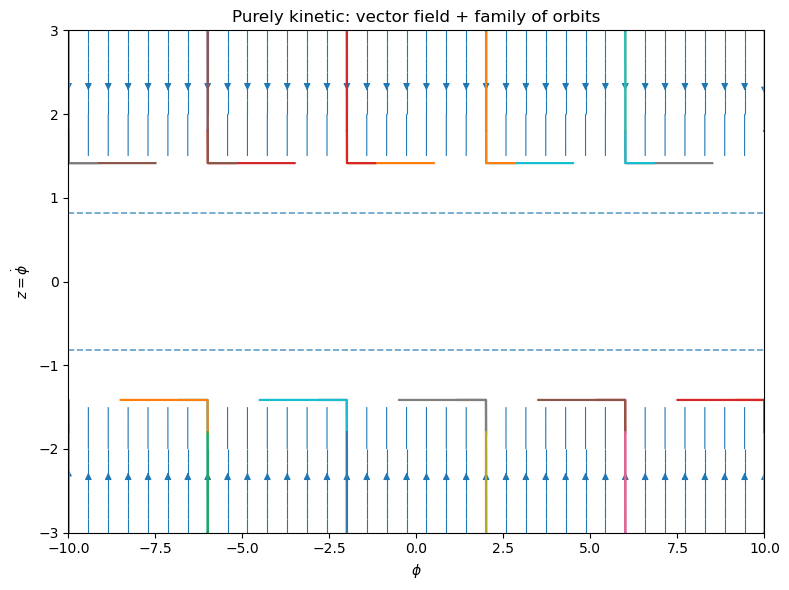

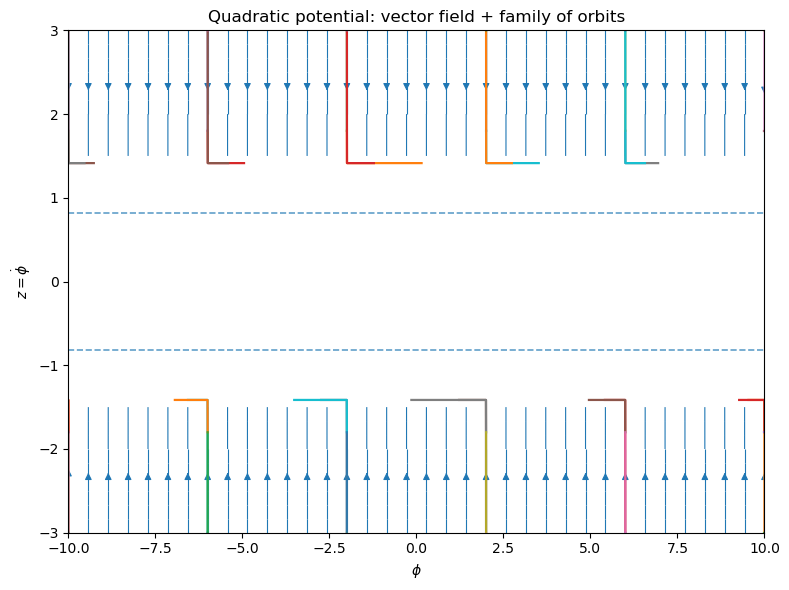

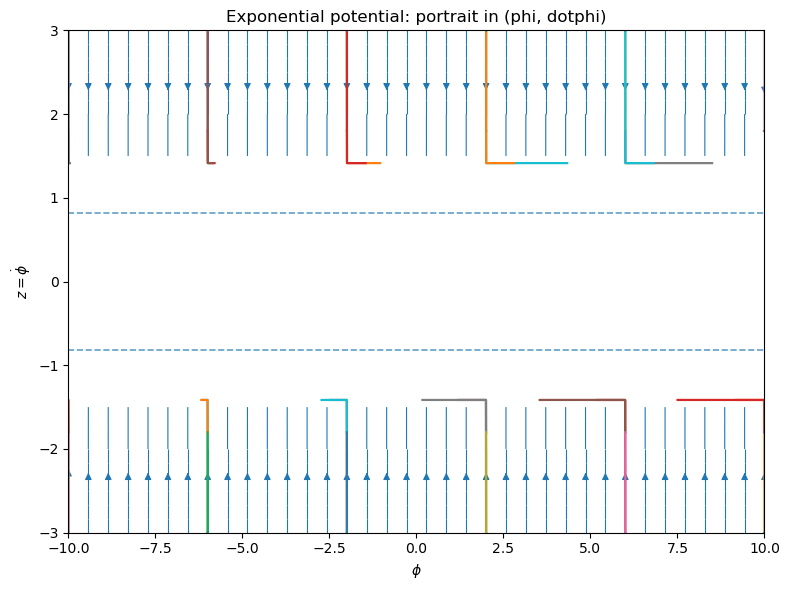

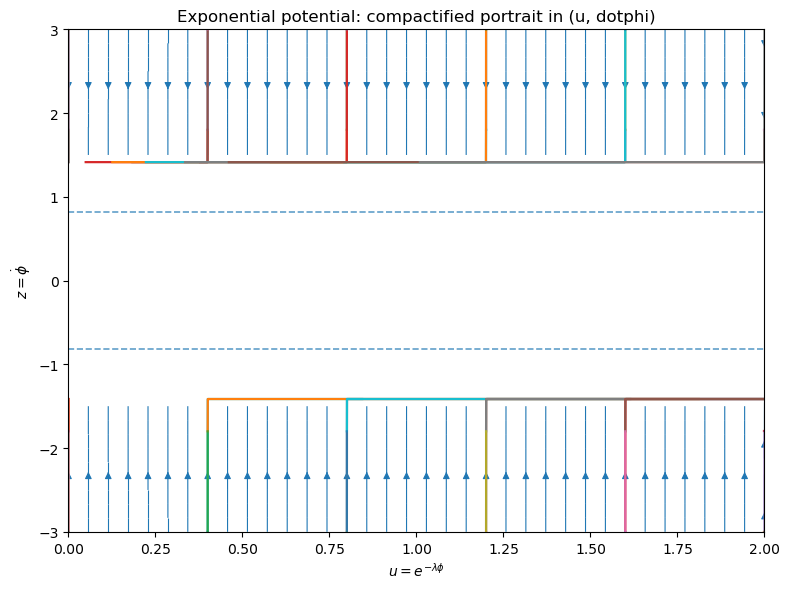

In [20]:
#!/usr/bin/env python3
# ============================================================
# Phase portrait (vector field + family of trajectories) built
# ONLY from the dynamical system (no CLASS background outputs).
#
# Variables (late-time, scalar-only, autonomous 2D):
#   z := dotphi,  X = 1/2 z^2
#   N := ln a
#
# System in N:
#   phi' = z / H
#   z'   = -3 z (z^2 - 2X0)/(3z^2 - 2X0) - V_phi/(F2 * H * (3z^2 - 2X0))
#
# Friedmann closure (M_pl^2 = 1 convention):
#   3 H^2 = rho_phi
#
# Model:
#   L = F(X) - V(phi),    F(X) = -F0 + F2 (X - X0)^2
#
# Potentials:
#   none: V=0
#   quadratic: V = 1/2 m^2 phi^2
#   exponential: V = V0 exp(-lam phi)
#
# Also includes a compactified portrait for exponential:
#   u := exp(-lam phi) >= 0,  V = V0 u
#   u' = -lam u z / H
#   z' = -3 z (z^2 - 2X0)/D + lam V0 u/(F2 H D),  D=3z^2-2X0
#
# ------------------------------------------------------------
# "Only constants from CLASS":
# If you want, compute (F0,F2) from cosmological inputs (h, Omega_L, Omega_m, theta, X0)
# without using any background outputs:
#   H0 = 100 h / c   [1/Mpc]   with c=299792.458 km/s
#   rho_c0 = 3 Mpl^2 H0^2      (set Mpl^2=1 if that is your CLASS convention)
#   F0 = Omega_L * rho_c0
#   F2 = Omega_m * rho_c0 / (4 X0^2 theta)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Tuple, List, Optional

try:
    from scipy.integrate import solve_ivp
except ImportError as e:
    raise ImportError("Necesitas SciPy: pip install scipy") from e


# -----------------------
# 1) Constants from (h, Omegas, theta)  -- no CLASS outputs needed
# -----------------------
def H0_Mpc_inv(h: float) -> float:
    c_km_s = 299792.458
    return 100.0 * h / c_km_s  # [1/Mpc]

def scherrer_constants_from_cosmo(
    h: float,
    Omega_L: float,
    Omega_m: float,
    X0: float,
    theta: float,
    Mpl2: float = 1.0,   # set 1.0 if your convention is M_pl^2=1
) -> Tuple[float, float, float]:
    """
    Returns (rho_c0, F0, F2) in units consistent with 3 Mpl^2 H^2 = rho.
    If Mpl2=1, then rho has units of H^2.
    """
    H0 = H0_Mpc_inv(h)
    rho_c0 = 3.0 * Mpl2 * H0**2
    F0 = Omega_L * rho_c0
    F2 = Omega_m * rho_c0 / (4.0 * X0**2 * theta)
    return rho_c0, F0, F2


# -----------------------
# 2) Model + DS
# -----------------------
@dataclass(frozen=True)
class Params:
    X0: float
    F0: float
    F2: float
    pot_kind: str          # "none" | "quad" | "exp"
    V0: float = 0.0        # for exp
    lam: float = 1.0       # for exp
    m: float = 1.0         # for quad
    D_eps: float = 1e-12   # avoid D=0
    rho_eps: float = 1e-14 # avoid rho<=0


def potential(phi: float, p: Params) -> Tuple[float, float]:
    if p.pot_kind == "none":
        return 0.0, 0.0
    if p.pot_kind == "quad":
        V = 0.5 * p.m**2 * phi**2
        Vphi = p.m**2 * phi
        return V, Vphi
    if p.pot_kind == "exp":
        V = p.V0 * np.exp(-p.lam * phi)
        Vphi = -p.lam * V
        return V, Vphi
    raise ValueError(f"pot_kind inválido: {p.pot_kind}")


def rho_phi(phi: float, z: float, p: Params) -> float:
    # F(X) = -F0 + F2 (X-X0)^2,  X=1/2 z^2
    X = 0.5 * z**2
    V, _ = potential(phi, p)
    # rho = 2X F_X - F + V, with F_X = 2F2(X-X0)
    # => rho = 3F2 X^2 - 2F2 X0 X + (F0 - F2 X0^2) + V
    return 3.0 * p.F2 * X**2 - 2.0 * p.F2 * p.X0 * X + (p.F0 - p.F2 * p.X0**2) + V


def H_from_state(phi: float, z: float, p: Params) -> float:
    r = rho_phi(phi, z, p)
    if r <= p.rho_eps:
        return np.nan
    return np.sqrt(r / 3.0)


def rhs_phi_z(N: float, y: np.ndarray, p: Params) -> np.ndarray:
    phi, z = float(y[0]), float(y[1])
    H = H_from_state(phi, z, p)
    D = 3.0 * z**2 - 2.0 * p.X0

    if (not np.isfinite(H)) or (H <= 0.0) or (abs(D) < p.D_eps):
        return np.array([0.0, 0.0], dtype=float)

    _, Vphi = potential(phi, p)

    phiN = z / H
    zN = -3.0 * z * (z**2 - 2.0 * p.X0) / D - Vphi / (p.F2 * H * D)
    return np.array([phiN, zN], dtype=float)


# --- Compactified exponential: u = exp(-lam phi) ---
def rho_phi_u(u: float, z: float, p: Params) -> float:
    X = 0.5 * z**2
    V = p.V0 * max(u, 0.0)
    return 3.0 * p.F2 * X**2 - 2.0 * p.F2 * p.X0 * X + (p.F0 - p.F2 * p.X0**2) + V


def H_from_state_u(u: float, z: float, p: Params) -> float:
    r = rho_phi_u(u, z, p)
    if r <= p.rho_eps:
        return np.nan
    return np.sqrt(r / 3.0)


def rhs_u_z(N: float, y: np.ndarray, p: Params) -> np.ndarray:
    # Only valid for p.pot_kind == "exp"
    u, z = float(y[0]), float(y[1])
    u = max(u, 0.0)

    H = H_from_state_u(u, z, p)
    D = 3.0 * z**2 - 2.0 * p.X0

    if (not np.isfinite(H)) or (H <= 0.0) or (abs(D) < p.D_eps):
        return np.array([0.0, 0.0], dtype=float)

    uN = -p.lam * u * z / H
    zN = -3.0 * z * (z**2 - 2.0 * p.X0) / D + (p.lam * p.V0 * u) / (p.F2 * H * D)
    return np.array([uN, zN], dtype=float)


# -----------------------
# 3) Events to stop integration near singularities / invalid rho
# -----------------------
def event_D(phi_or_u_mode: str, p: Params):
    def _ev(N, y):
        z = float(y[1])
        return abs(3.0 * z**2 - 2.0 * p.X0) - p.D_eps
    _ev.terminal = True
    _ev.direction = -1
    return _ev

def event_rho(phi_or_u_mode: str, p: Params):
    def _ev(N, y):
        if phi_or_u_mode == "phi":
            phi, z = float(y[0]), float(y[1])
            r = rho_phi(phi, z, p)
        else:
            u, z = float(y[0]), float(y[1])
            r = rho_phi_u(u, z, p)
        return r - p.rho_eps
    _ev.terminal = True
    _ev.direction = -1
    return _ev


# -----------------------
# 4) Plot: vector field + many trajectories
# -----------------------
def stream_field_phi_z(ax, p: Params, phi_lim, z_lim, n=120, normalize=True):
    phis = np.linspace(phi_lim[0], phi_lim[1], n)
    zs   = np.linspace(z_lim[0], z_lim[1], n)
    PHI, Z = np.meshgrid(phis, zs)
    U = np.zeros_like(PHI)  # phi'
    V = np.zeros_like(PHI)  # z'

    for i in range(n):
        for j in range(n):
            d = rhs_phi_z(0.0, np.array([PHI[i,j], Z[i,j]]), p)
            U[i,j], V[i,j] = d[0], d[1]

    speed = np.sqrt(U**2 + V**2)
    mask = (speed == 0.0) | (~np.isfinite(speed))
    U = np.ma.array(U, mask=mask)
    V = np.ma.array(V, mask=mask)

    if normalize:
        U = U / (speed + 1e-30)
        V = V / (speed + 1e-30)

    ax.streamplot(PHI, Z, U, V, density=1.2, linewidth=0.8, arrowsize=1.0)


def stream_field_u_z(ax, p: Params, u_lim, z_lim, n=120, normalize=True):
    us = np.linspace(u_lim[0], u_lim[1], n)
    zs = np.linspace(z_lim[0], z_lim[1], n)
    UVAR, Z = np.meshgrid(us, zs)
    U = np.zeros_like(UVAR)  # u'
    V = np.zeros_like(UVAR)  # z'

    for i in range(n):
        for j in range(n):
            d = rhs_u_z(0.0, np.array([UVAR[i,j], Z[i,j]]), p)
            U[i,j], V[i,j] = d[0], d[1]

    speed = np.sqrt(U**2 + V**2)
    mask = (speed == 0.0) | (~np.isfinite(speed))
    U = np.ma.array(U, mask=mask)
    V = np.ma.array(V, mask=mask)

    if normalize:
        U = U / (speed + 1e-30)
        V = V / (speed + 1e-30)

    ax.streamplot(UVAR, Z, U, V, density=1.2, linewidth=0.8, arrowsize=1.0)


def integrate_family(
    rhs: Callable,
    y0_list: List[np.ndarray],
    p: Params,
    Nmax: float = 8.0,
    n_eval: int = 4000,
    mode: str = "phi",
):
    """
    Integrate each y0 forward and backward in N, returning list of (sol_fwd, sol_bwd).
    """
    sols = []
    N_eval_f = np.linspace(0.0, +Nmax, n_eval)
    N_eval_b = np.linspace(0.0, -Nmax, n_eval)

    evs = [event_D(mode, p), event_rho(mode, p)]

    for y0 in y0_list:
        sol_f = solve_ivp(lambda N,y: rhs(N,y,p), (0.0, +Nmax), y0, t_eval=N_eval_f,
                          rtol=1e-8, atol=1e-10, events=evs)
        sol_b = solve_ivp(lambda N,y: rhs(N,y,p), (0.0, -Nmax), y0, t_eval=N_eval_b,
                          rtol=1e-8, atol=1e-10, events=evs)
        sols.append((sol_f, sol_b))
    return sols


def sample_initial_conditions_phi_z(p: Params, phi_lim, z_lim, nphi=5, nz=5) -> List[np.ndarray]:
    phis = np.linspace(phi_lim[0], phi_lim[1], nphi)
    zs   = np.linspace(z_lim[0], z_lim[1], nz)
    y0s = []
    for phi0 in phis:
        for z0 in zs:
            # discard invalid points (rho<=0 or too close to D=0)
            r = rho_phi(phi0, z0, p)
            D = 3.0 * z0**2 - 2.0 * p.X0
            if (r > p.rho_eps) and (abs(D) > 50.0 * p.D_eps):
                y0s.append(np.array([phi0, z0], dtype=float))
    return y0s


def sample_initial_conditions_u_z(p: Params, u_lim, z_lim, nu=5, nz=5) -> List[np.ndarray]:
    us = np.linspace(u_lim[0], u_lim[1], nu)
    zs = np.linspace(z_lim[0], z_lim[1], nz)
    y0s = []
    for u0 in us:
        for z0 in zs:
            r = rho_phi_u(u0, z0, p)
            D = 3.0 * z0**2 - 2.0 * p.X0
            if (r > p.rho_eps) and (abs(D) > 50.0 * p.D_eps):
                y0s.append(np.array([u0, z0], dtype=float))
    return y0s


def plot_phase_portrait_phi_z(
    p: Params,
    phi_lim=(-10.0, 10.0),
    z_lim=(-3.0, 3.0),
    seeds: Optional[List[np.ndarray]] = None,
    Nmax: float = 8.0,
    normalize_field: bool = True,
    title: str = "",
):
    fig, ax = plt.subplots(figsize=(8,6))
    stream_field_phi_z(ax, p, phi_lim, z_lim, n=140, normalize=normalize_field)

    # singular lines D=0: z = ±sqrt(2X0/3)
    if p.X0 > 0:
        zsing = np.sqrt(2.0 * p.X0 / 3.0)
        ax.axhline(+zsing, ls="--", lw=1.2, alpha=0.7)
        ax.axhline(-zsing, ls="--", lw=1.2, alpha=0.7)

    if seeds is None:
        seeds = sample_initial_conditions_phi_z(p, phi_lim, z_lim, nphi=6, nz=6)

    sols = integrate_family(rhs_phi_z, seeds, p, Nmax=Nmax, n_eval=2500, mode="phi")
    for sol_f, sol_b in sols:
        ax.plot(sol_f.y[0], sol_f.y[1], lw=1.6)
        ax.plot(sol_b.y[0], sol_b.y[1], lw=1.6, alpha=0.8)

    ax.set_xlim(phi_lim); ax.set_ylim(z_lim)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$z=\dot\phi$")
    ax.set_title(title if title else f"Phase portrait in $(\\phi,\\dot\\phi)$, pot={p.pot_kind}")
    plt.tight_layout()
    plt.show()


def plot_phase_portrait_u_z(
    p: Params,
    u_lim=(0.0, 2.0),
    z_lim=(-3.0, 3.0),
    seeds: Optional[List[np.ndarray]] = None,
    Nmax: float = 8.0,
    normalize_field: bool = True,
    title: str = "",
):
    if p.pot_kind != "exp":
        raise ValueError("El retrato compactificado (u,z) sólo aplica para pot_kind='exp'.")

    fig, ax = plt.subplots(figsize=(8,6))
    stream_field_u_z(ax, p, u_lim, z_lim, n=140, normalize=normalize_field)

    # singular lines D=0: z = ±sqrt(2X0/3)
    if p.X0 > 0:
        zsing = np.sqrt(2.0 * p.X0 / 3.0)
        ax.axhline(+zsing, ls="--", lw=1.2, alpha=0.7)
        ax.axhline(-zsing, ls="--", lw=1.2, alpha=0.7)

    if seeds is None:
        seeds = sample_initial_conditions_u_z(p, u_lim, z_lim, nu=6, nz=6)

    sols = integrate_family(rhs_u_z, seeds, p, Nmax=Nmax, n_eval=2500, mode="u")
    for sol_f, sol_b in sols:
        ax.plot(sol_f.y[0], sol_f.y[1], lw=1.6)
        ax.plot(sol_b.y[0], sol_b.y[1], lw=1.6, alpha=0.8)

    ax.set_xlim(u_lim); ax.set_ylim(z_lim)
    ax.set_xlabel(r"$u=e^{-\lambda\phi}$")
    ax.set_ylabel(r"$z=\dot\phi$")
    ax.set_title(title if title else r"Compactified phase portrait in $(u,\dot\phi)$")
    plt.tight_layout()
    plt.show()


# -----------------------
# 5) Minimal example
# -----------------------
if __name__ == "__main__":
    # --- Example: build F0,F2 from your cosmological inputs (no bg outputs) ---
    h     = 0.691
    OmegaL = 0.70
    Omega_m = 0.30       # define what you mean by "matter-like" today in your fit
    theta  = (1/3)*1e-17
    X0     = 1.0

    _, F0, F2 = scherrer_constants_from_cosmo(
        h=h, Omega_L=OmegaL, Omega_m=Omega_m, X0=X0, theta=theta, Mpl2=1.0
    )

    # --- Choose potential ---
    # (A) purely kinetic
    p_none = Params(X0=X0, F0=F0, F2=F2, pot_kind="none")
    plot_phase_portrait_phi_z(p_none, phi_lim=(-10,10), z_lim=(-3,3), Nmax=8.0,
                              title="Purely kinetic: vector field + family of orbits")

    # (B) quadratic
    p_quad = Params(X0=X0, F0=F0, F2=F2, pot_kind="quad", m=1.0)
    plot_phase_portrait_phi_z(p_quad, phi_lim=(-10,10), z_lim=(-3,3), Nmax=8.0,
                              title="Quadratic potential: vector field + family of orbits")

    # (C) exponential (phi,z portrait)
    p_exp = Params(X0=X0, F0=F0, F2=F2, pot_kind="exp", V0=4.32, lam=1.0)
    plot_phase_portrait_phi_z(p_exp, phi_lim=(-10,10), z_lim=(-3,3), Nmax=8.0,
                              title="Exponential potential: portrait in (phi, dotphi)")

    # (C2) exponential (compactified u,z portrait)
    plot_phase_portrait_u_z(p_exp, u_lim=(0.0, 2.0), z_lim=(-3,3), Nmax=8.0,
                            title="Exponential potential: compactified portrait in (u, dotphi)")
